<a href="https://colab.research.google.com/github/Sassotek/Mechanistic-Interpretability-for-Vision-Models-Optimization/blob/main/Mechanistic_Interpretability_for_Vision_Models_Optimization_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notes

In [ ]:
!swd

/bin/bash: line 1: swd: command not found


##########Dataset Description
File descriptions

    train.images.zip - the training set (images distributed into class labeled folders)
    test.zip
   
    wnids.txt - list of the used ids from the original full set of ImageNet
    words.txt - description of all ids of ImageNet


+++++ https://www.kaggle.com/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification


https://viso.ai/deep-learning/vision-transformer-vit/

https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

https://docs.pytorch.org/vision/main/models/vision_transformer.html

https://github.com/lucidrains/vit-pytorch

https://arxiv.org/pdf/2010.11929.pdf

https://www.youtube.com/watch?v=j3VNqtJUoz0

https://www.youtube.com/watch?v=vJF3TBI8esQ

https://www.youtube.com/watch?v=nZ22Ecg9XCQ


** Dataset link sbagliato**
https://www.kaggle.com/c/tiny-imagenet


Gradient Plot
https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/37

#####GuidaEinops

https://nbviewer.org/github/arogozhnikov/einops/blob/main/docs/1-einops-basics.ipynb


**latent_size** (o anche detto embedding_dim, hidden_dim, ecc.) è la dimensione del vettore che rappresenta ogni patch dopo la proiezione lineare, ovvero la dimensione dello spazio latente in cui il modello "lavora".

**class token** per ogni batch, un vettore speciale che sarà usato dal ViT per l'output della classificazione.

**positional embedding** iniziale. Verrà poi ripetuta per il numero di patch + 1 (per il class token). Serve a dare informazioni sulla posizione dei patch nel Transformer.

**patches = einops.rearrange**(
    input,
    'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
    p1=self.patch_size, p2=self.patch_size
)*
Usa Einops per dividere ogni immagine in patch:

    Input: (b, c, H, W)

    Output: (b, N_patch, patch_dim), dove:

        N_patch = (H // patch_size) * (W // patch_size)

        patch_dim = patch_size * patch_size * c

Esempio: immagine 64x64, patch_size=16 → 16 patch da 16x16x3

In [ ]:
#save_path_model= ................./ciao.pth
#save_path_opt= ..../ott.pth

# Running Settings

In [ ]:
Pi_gpu=0


#Imports

In [ ]:
import math
import matplotlib
import matplotlib.pyplot as plt
plt.ion()
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch
import matplotlib.ticker as mtick
import numpy as np
from PIL import Image
import cv2
from skimage import io, color
from collections import Counter


#Kaggle
!pip install kagglehub --quiet
import kagglehub


#PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler, ConcatDataset
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as TF
from torchsummary import summary
import torch.optim as optim
from torch.fx import symbolic_trace
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.cuda.amp import GradScaler, autocast


import random
import os
import pandas as pd
from tqdm.notebook import tqdm
import time
import seaborn as sns
import einops
import sys
import requests
import urllib.request
from io import BytesIO
from prettytable import PrettyTable
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
import plotly.express as px
import networkx as nx
!pip install nbformat --quiet

import nbformat
from pathlib import Path



from IPython.display import display, Markdown, clear_output
from IPython.display import HTML
#from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, Dropdown, Output


import sklearn
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report, accuracy_score

from timm.layers import DropPath
from timm.data.mixup import Mixup
from timm.loss.cross_entropy import SoftTargetCrossEntropy



# Setting the seed
torch.manual_seed(240700)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("Device",device)
if torch.cuda.is_available():
   torch.cuda.manual_seed(240700)
   torch.cuda.manual_seed_all(240700)

#ensure that all operations are deterministic on GPU if used,for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
device_list = ["NVIDIA GeForce RTX 3070", ""]

def hardware_check():
    # Check if GPU is available and return the device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = torch.cuda.get_device_name()
        print(f"GPU is available!")
        print(f"  -> GPU - {torch.cuda.get_device_name()}")
        #print(f"  -> Total Memory: {torch.cuda.get_device_properties().total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU.")
        print("\nCPU Information:")

        # Fix the backslash issue in the command string by escaping it
        cpu_model = os.popen("cat /proc/cpuinfo | grep \"model name\" | uniq").read().strip()
        print(f"CPU Model: {cpu_model}")
        print(f"Number of CPU cores: {os.cpu_count()}")

    return device, device_name

device, device_name = hardware_check()
print(f"\nUsing {device} for computation")


## Google Drive settings, only if is not local runtime
if device_name not in device_list:
  from google.colab.patches import cv2_imshow
  from google.colab import drive
  drive.mount('/content/drive')


GPU is available!
  -> GPU - Tesla T4

Using cuda for computation
Mounted at /content/drive


# Globals

In [ ]:
directory_drive="/content/drive/File_projects_CV"
directory_saved_models_drive="/content/drive/MyDrive//File_projects_CV/"
directory_saved_optimizers_drive="/content/drive/MyDrive//File_projects_CV/"
#notebook_path= Path("/content/drive/MyDrive/File_projects_CV/Mechanistic_Interpretability_for_Vision_Models_Optimization_code.ipynb")

path_saves_pc_pi = "/home/user/work/Saved_Models/"
local_path = "/home/user/work/tiny-imagenet-200"

RED = "\033[31m"
GREEN = "\033[32m"
BLUE = "\033[34m"
RESET = "\033[0m"
CYAN="\033[36m"
MAGENTA="\033[35m"

#Transformer hyperparameters
patch_size = 16
#latent_size = 768
#n_heads = 12
#n_encoders = 12

#patch_size = 8
latent_size = 384
n_heads = 6
n_encoders = 6

n_channels = 3
dropout = 0.1
n_classes = 200 #According to tinyimagenet
image_size = 64 #According to tinyimagenet

#Training
batch_size = 128
threshold = 10e-3
weight_decay = 0.01
label_smoothing = 0.1
learning_rate = 1e-4

# ImageNet mean and std
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

#Data

##Dataset Loading

In [ ]:
#data_path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")
if device_name in device_list:
  data_path = local_path
else:
  data_path= kagglehub.dataset_download("wissamsalam/tiny-imagenet-cleaned-for-classification")
  data_path= data_path+'/tiny-imagenet-200/'
  print("Path to dataset files:", data_path)

100%|██████████| 214M/214M [00:02<00:00, 79.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification/versions/1/tiny-imagenet-200/


In [ ]:
def print_dataset_structure(root_dir, max_classes=3, max_images=3):
    print(f"📁 Directory: {root_dir}\n")

    class_dirs_all = []
    root_items = sorted(os.listdir(root_dir))
    for item in root_items:
        item_path = os.path.join(root_dir, item)

        if os.path.isfile(item_path):
            print(f"📄 {item}")

        elif os.path.isdir(item_path) and item in ['train', 'val', 'test']:
            print(f"\n📂 {item}/")

            class_dirs_all = sorted([
                d for d in os.listdir(item_path)
                if os.path.isdir(os.path.join(item_path, d))
            ])
            class_dirs = class_dirs_all[:max_classes]

            if not class_dirs:
                print(f"  (No subdirectory found into {item}/)")
                continue

            for cls in class_dirs:
                cls_path = os.path.join(item_path, cls)
                print(f"  ├── {cls}/")

                image_files_all = sorted([
                    f for f in os.listdir(cls_path)
                    if os.path.isfile(os.path.join(cls_path, f))
                ])
                image_files = image_files_all[:max_images]

                for img in image_files:
                    print(f"  │   ├── {img}")

                if len(image_files_all) > max_images:
                    print(f"  │   └── ...")

            if len(class_dirs_all) > max_classes:
                print(f"  └── ...")

    dataset_data = []

    for item_ in root_items:
        item_path_ = os.path.join(root_dir, item_)

        if os.path.isdir(item_path_) and item_ in ['train', 'val', 'test']:
            class_dirs_ = sorted([
                d for d in os.listdir(item_path_)
                if os.path.isdir(os.path.join(item_path_, d))
            ])

            if not class_dirs_:
                continue

            for cls in class_dirs_:
                cls_path_ = os.path.join(item_path_, cls)

                image_files_ = sorted([
                    f for f in os.listdir(cls_path_)
                    if os.path.isfile(os.path.join(cls_path_, f))
                ])
                if(item_ == 'train'):
                  size = len(image_files_)-1
                else:
                  size = len(image_files_)
                dataset_data.append((item_, cls, size))

    return class_dirs_all, dataset_data

In [ ]:
#Print some data about the dataset
print(data_path)
class_labels , data = print_dataset_structure(data_path)
labels_encoding = {label: i for i, label in enumerate(class_labels)}
inverse_labels_encoding = {v: k for k, v in labels_encoding.items()}
set_samples = {}

for set_, lab, num in data:
    if(set_ not in set_samples):
        set_samples[set_] = {}
        set_samples[set_] = (num, 1)
    else:
        set_samples[set_] = (set_samples[set_][0]+num, set_samples[set_][1]+1)

mean_for_training = set_samples['train'][0]/set_samples['train'][1]
mean_for_validation = set_samples['val'][0]/set_samples['val'][1]
mean_for_test = set_samples['test'][0]/set_samples['test'][1]

print("\n")
print("Raw Data")
print(data)
print("\n")
print("Mean_for_training")
print(mean_for_training)
print("Mean_for_validation")
print(mean_for_validation)
print("Mean_for_test")
print(mean_for_test)
print("\n")

samples_by_set = {}

c = 0
for set_, lab, num in data:
  if set_ == 'train':
    if num != mean_for_training:
      print("Train dimensions different for mean for class "+lab)
      c = 1
  elif set_ == 'val':
    if num != mean_for_validation:
      print("Validation dimensions different for mean for class "+lab)
      c = 1
  elif set_ == 'test':
    if num != mean_for_test:
      print("Test dimensions different for mean for class "+lab)
      c = 1

if c == 0:
  print("Class distributions identical\n")
  samples_by_set = {'train': int(mean_for_training),
                    'val': int(mean_for_validation),
                    'test': int(mean_for_test)
                    }


print("All Class Labels")
print(class_labels)
print("\n")
print("Number of Class Labels")
print(len(class_labels))
print("\n")
print("Lables Encoding")
print(labels_encoding)

/root/.cache/kagglehub/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification/versions/1/tiny-imagenet-200/
📁 Directory: /root/.cache/kagglehub/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification/versions/1/tiny-imagenet-200/


📂 test/
  ├── n01443537/
  │   ├── n01443537_0.JPEG
  │   ├── n01443537_1.JPEG
  │   ├── n01443537_101.JPEG
  │   └── ...
  ├── n01629819/
  │   ├── n01629819_0.JPEG
  │   ├── n01629819_1.JPEG
  │   ├── n01629819_10.JPEG
  │   └── ...
  ├── n01641577/
  │   ├── n01641577_0.JPEG
  │   ├── n01641577_1.JPEG
  │   ├── n01641577_104.JPEG
  │   └── ...
  └── ...

📂 train/
  ├── n01443537/
  │   ├── n01443537_10.JPEG
  │   ├── n01443537_100.JPEG
  │   ├── n01443537_102.JPEG
  │   └── ...
  ├── n01629819/
  │   ├── n01629819_100.JPEG
  │   ├── n01629819_101.JPEG
  │   ├── n01629819_102.JPEG
  │   └── ...
  ├── n01641577/
  │   ├── n01641577_10.JPEG
  │   ├── n01641577_100.JPEG
  │   ├── n01641577_101.JPEG
  │   └── ...
  └── ...

📂 val/
  ├── n01443537/

In [ ]:
def print_first_lines(file_path, num_lines=10):
    """
    Stampa le prime `num_lines` righe del file di testo specificato.

    Args:
      file_path (str): percorso al file .txt da aprire
      num_lines (int): numero di righe da stampare (default 5)
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for i in range(num_lines):
                line = f.readline()
                if not line:
                    break  # fine file raggiunta
                print(line.rstrip('\n'))
    except FileNotFoundError:
        print(f"Errore: file non trovato -> {file_path}")
    except Exception as e:
        print(f"Errore aprendo il file: {e}")


In [ ]:
def load_label_dict_as_list(file_path):
    """
    Restituisce un dict { codice: [nome1, nome2, ...] }
    """
    label_dict = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            code, desc = line.strip().split(None, 1)
            names = [name.strip() for name in desc.split(',')]
            label_dict[code] = names
    return label_dict




In [ ]:
print_first_lines(data_path+'words.txt')
print("\nMaking the dictionary for labels...")
if device_name not in device_list:
  labels_dict = load_label_dict_as_list(data_path+'words.txt')
else:
  labels_dict = load_label_dict_as_list(local_path+'/words.txt')
print("Checking...\n")
count = 0
for code, desc in labels_dict.items():
    print(f"{code}\t→ {desc}")
    count += 1
    if count == 5:
        break

n00001740	entity
n00001930	physical entity
n00002137	abstraction, abstract entity
n00002452	thing
n00002684	object, physical object
n00003553	whole, unit
n00003993	congener
n00004258	living thing, animate thing
n00004475	organism, being
n00005787	benthos

Making the dictionary for labels...
Checking...

n00001740	→ ['entity']
n00001930	→ ['physical entity']
n00002137	→ ['abstraction', 'abstract entity']
n00002452	→ ['thing']
n00002684	→ ['object', 'physical object']


##Transforms



In [ ]:

def denormalize(tensor, mean, std):
    """
    tensor: torch.Tensor C×H×W normalized
    mean, std: liste di lunghezza C
    return: torch.Tensor C×H×W denormalized
    """
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1,1,1)
    std  = torch.tensor(std,  dtype=tensor.dtype, device=tensor.device).view(-1,1,1)
    img = tensor * std + mean
    return img.clamp(0, 1)

In [ ]:
def make_transform(image_size: int, augment: bool = False, aug_prob: float = 0.5):
    """
    Restituisce un unico Compose che, se augment==True, applica:
      - flip, crop, rotate, jitter su PIL,
      - ToTensor(),
      - rumore gaussiano leggero,
      - erasing,
      - Normalize

    Se augment==False, fa solo Resize/CenterCrop, ToTensor e Normalize.
    """
    # Mean e std usati per la normalizzazione
    MEAN = [0.485, 0.456, 0.406]
    STD  = [0.229, 0.224, 0.225]
    MEAN_RGB = (int(0.485*255), int(0.456*255), int(0.406*255))

    # 1) Fasi PIL-only
    pil_transforms = []
    if augment:
        pil_transforms += [
            transforms.RandomHorizontalFlip(p=aug_prob),
            transforms.RandomResizedCrop(
                size=image_size,
                scale=(0.8, 1.0),
                ratio=(1.0, 1.0),
                interpolation=InterpolationMode.BILINEAR
            ),
            transforms.RandomRotation(
                degrees=10,
                interpolation=InterpolationMode.BILINEAR,
                fill=MEAN_RGB
            ),
            transforms.ColorJitter(
                brightness=0.1,
                contrast=0.1,
                saturation=0.1,
                hue=0.05
            ),
        ]
    else:
        pil_transforms += [
            transforms.Resize(image_size, interpolation=InterpolationMode.BILINEAR),
            transforms.CenterCrop(image_size),
        ]

    # 2) Fasi Tensor-only
    tensor_transforms = [
        transforms.ToTensor(),  # ora PIL → Tensor [0,1]
    ]
    if augment:
        tensor_transforms += [
            # gaussiano leggero
            transforms.Lambda(
                lambda t: torch.clamp(t + torch.randn_like(t) * 0.02, 0.0, 1.0)
            ),
            # erasing
            transforms.RandomErasing(
                p=aug_prob,
                scale=(0.02, 0.03),
                ratio=(0.5, 1.5),
                value=0
            ),
        ]

    # 3) Normalizzazione finale (sempre)
    tensor_transforms += [
        transforms.Normalize(mean=MEAN, std=STD)
    ]

    # Metti tutto in un solo Compose
    return transforms.Compose(pil_transforms + tensor_transforms)

##Data Augmentation

In [ ]:
def DataAugmentation(image, aug_prob = 0.50):
  # 1. Random Horizontal Flip
  if random.random() < aug_prob:
      print("Random Horizontal Flip")
      image = TF.hflip(image)

  # 2. Random Crop (with probability)
  if random.random() < aug_prob:
      print("Random Crop")
      # Get original dimensions
      h, w = image.shape[1:3]

      # Determine crop dimensions (between 80-100% of original dimensions)
      new_h = int(h * random.uniform(0.8, 1.0))
      new_w = int(w * random.uniform(0.8, 1.0))

      # Determine crop position
      top = random.randint(0, h - new_h)
      left = random.randint(0, w - new_w)

      # Apply crop
      image = image[:, top:top + new_h, left:left + new_w]

      # Resize back to original dimensions
      image = TF.resize(image, [h, w],
                                        interpolation=transforms.InterpolationMode.BILINEAR)

  # 3. Random Rotation (small angles)
  if random.random() < aug_prob:
      print("Random Rotation")
      angle = random.uniform(-10, 10)  # Rotation of ±10 degrees
      image = TF.rotate(image, angle,
                                        interpolation=transforms.InterpolationMode.BILINEAR)


  # 4. Random Color Jitter (only for RGB image)
  if random.random() < aug_prob:
      print("Random Color Jitter")
      color_jitter = transforms.ColorJitter(
          brightness=0.2,
          contrast=0.2,
          saturation=0.2,
          hue=0.1
      )
      image = color_jitter(image)



  # 5. Random Gaussian Noise (only for RGB image)
  if random.random() < aug_prob:
      print("Random Gaussian Noise")
      noise = torch.randn_like(image) * 0.02  # Adjust standard deviation to control noise intensity
      print("Clamping in augmentation between 0 and 1")
      image = torch.clamp(image + noise, 0.0, 1.0)  # Clamp values between 0 and 1

  #if random.random()<aug_prob:
  print("Random Erasing")
  transforms.RandomErasing()

  return image

##Dataset Loader


In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, root_dir, mode, transform_size = (image_size, image_size), augmentation = False):
        self.root_dir = root_dir
        self.mode = mode
        self.transform_size = transform_size
        self.augmentation = augmentation and mode == 'train'
        self.samples = [] #flatten the dataset

        if self.mode == 'train':
            self.data_path = os.path.join(self.root_dir, 'train')
        elif self.mode == 'test':
            self.data_path = os.path.join(self.root_dir, 'test')
        elif self.mode == 'val':
            self.data_path = os.path.join(self.root_dir, 'val')
        else:
          raise ValueError("Invalid mode")

        self.labels = sorted([d for d in os.listdir(self.data_path)])

        for label_idx, label in enumerate(self.labels):
            label_dir = os.path.join(self.data_path, label)
            image_files = sorted(os.listdir(label_dir))
            for img_file in image_files:
                if(img_file != label + "_boxes.txt"):
                  img_path = os.path.join(label_dir, img_file)
                  self.samples.append(( label, img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label_name, img_path = self.samples[idx]
        #print("im in getitem")
        #print(label_name)
        #print(img_path)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image")
            raise e

        #trans = DataTransform(image, label_name, self.transform_size)
        # Convert to tensor if needed
        #if not isinstance(image, torch.Tensor):
        #  image = transforms.ToTensor()(image)

        #encode label
        label = labels_encoding[label_name]

        composition=None
        if(self.augmentation):
          composition=make_transform(image_size=64, augment=True, aug_prob=0.5)
          image = composition(image)
        else:
          composition=make_transform(image_size=64, augment=False, aug_prob=0.5)
          image = composition(image)

        return {'image': image, 'label': label}


    def getitem(self, chosen_label, idx):
        if(chosen_label not in self.labels):
            print("Invalid label for "+self.mode)
            return None

        sample_path = os.path.join(self.data_path, chosen_label)

        image_files = sorted([
                    f for f in os.listdir(sample_path)
                ])

        sample_number = len(image_files)

        if(idx > sample_number):
          print("Invalid index for "+chosen_label+" in "+self.mode)

        image_idx = image_files[idx]
        #print(image_idx)
        try:
            image = Image.open(os.path.join(sample_path, image_idx)).convert('RGB')
        except Exception as e:
            print(f"Error loading image")
            raise e
        #print(image)

        #trans = DataTransform(image, chosen_label, self.transform_size)
        #image = trans['image']
        #label = trans['label']
        # Convert to tensor if needed
        #if not isinstance(image, torch.Tensor):
        #  image = transforms.ToTensor()(image)

        #encode label
        label = labels_encoding[chosen_label]

        composition=None
        if(self.augmentation):
          composition=make_transform(image_size=64, augment=True, aug_prob=0.5)
          image = composition(image)
        else:
          composition=make_transform(image_size=64, augment=False, aug_prob=0.5)
          image = composition(image)



        return {'image': image, 'label': label}

##Show Sample

In [ ]:

def show_sample_2(dataset, mode, label_1, idx_1, label_2, idx_2,aug:bool,denormalizing=False):
    label_dec_1 = labels_encoding[label_1]
    label_dec_2 = labels_encoding[label_2]

    mul = 0

    if(mode == 'train'):
        mul = samples_by_set['train']
    elif(mode == 'val'):
        mul = samples_by_set['val']
    elif(mode == 'test'):
        mul = samples_by_set['test']
    else:
        print("Invalid mode")
        return

    sample_idx_1 = label_dec_1*mul+idx_1
    sample_idx_2 = label_dec_2*mul+idx_2

    sample_1 = dataset.__getitem__(sample_idx_1)
    image_1 = sample_1['image']


    sample_2 = dataset.__getitem__(sample_idx_2)
    image_2 = sample_2['image']

    if(denormalizing):
      image_1 = denormalize(image_1, MEAN, STD)
      image_2= denormalize(image_2, MEAN, STD)


    label1 = sample_1['label']
    image_1 = image_1.permute(1, 2, 0).numpy()
    label2 = sample_2['label']
    image_2 = image_2.permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First image
    axs[0].imshow(image_1)
    #axs[0].set_title(f"Label: {label_1}")
    axs[0].set_title(f"Pietro-label{label1}- {labels_dict[label_1][0]}")
    axs[0].set_xlabel('Width (pixels)')
    axs[0].set_ylabel('Height (pixels)')
    axs[0].grid(False)

    # Second image
    axs[1].imshow(image_2)
    #axs[1].set_title(f"Label: {label_2}")
    axs[1].set_title(f"Cami-label{label2}--{labels_dict[label_2][0]}")
    axs[1].set_xlabel('Width (pixels)')
    axs[1].set_ylabel('Height (pixels)')
    axs[1].grid(False)

    # Titolo generale
    if(aug):
      fig.suptitle("With augmentation", fontsize=12, fontweight='bold')
    else:
      fig.suptitle("Without augmentation", fontsize=12, fontweight='bold')

    # Per non sovrapporre il supertitle ai subplot
    fig.tight_layout(rect=(0.0, 0.0, 1.0, 0.95))

    plt.show()



Let's visualize a pic :D


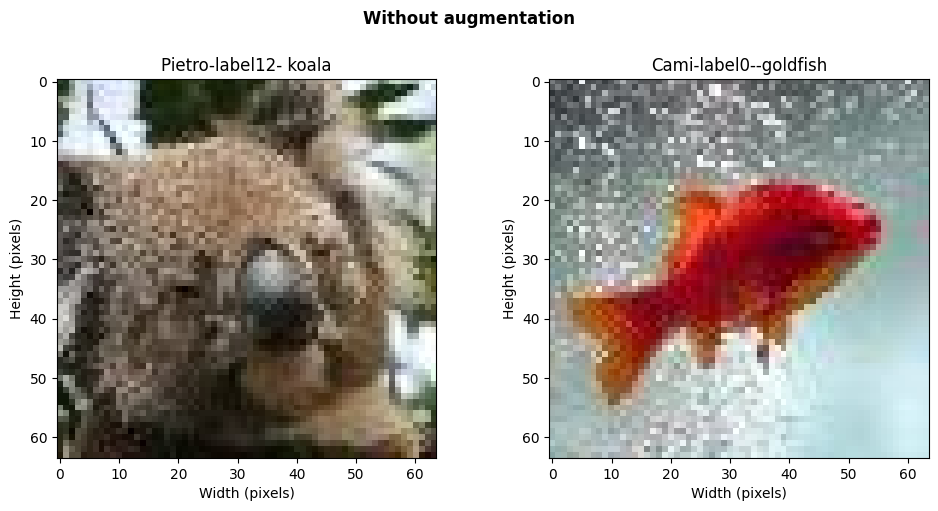

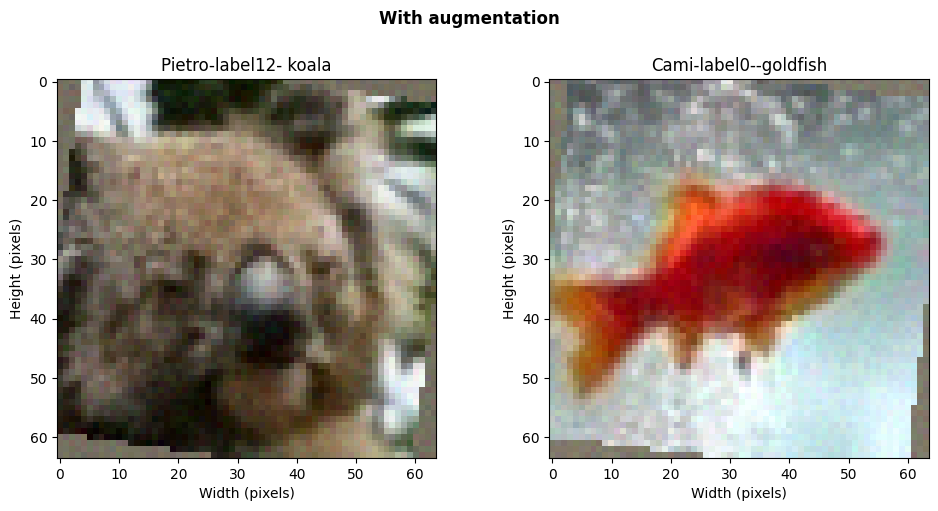

In [ ]:
mode = 'train'
datset_1 = DatasetLoader(data_path, mode, augmentation=False)
datset_2 = DatasetLoader(data_path, mode, augmentation=True)
#show_sample_1(datset_1, 'n01644900', 0, 'n01443537', 0)
show_sample_2(datset_1, mode, 'n01882714', 44, 'n01443537', 0,aug=False,denormalizing=True)
show_sample_2(datset_2, mode, 'n01882714', 44, 'n01443537', 0,aug=True,denormalizing=True)

#Network Functions


##Input Embedding

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               channels,
               latent_size):
    super().__init__()
    #self.img_size = img_size
    self.patch_size = patch_size
    #self.channels = channels
    #self.latent_size = latent_size
    self.proj = nn.Conv2d(in_channels= channels,
                          out_channels= latent_size,
                          kernel_size= patch_size,
                          stride= patch_size)

    self.num_patches = (img_size // patch_size)**2

    self.cls_token = nn.Parameter(torch.randn(1, 1, latent_size)) #classification token to train
    self.pos_embed = nn.Parameter(torch.randn(1, (1+ self.num_patches), latent_size)) #positional embedding within image

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x) #(B, E, H/P, W/P)
    x = x.flatten(2).transpose(1, 2) #(B, N, E)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token,x), dim=1)
    x = x + self.pos_embed
    return x

##Multilayer Perceptron

In [ ]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features= in_features,
                         out_features= hidden_features)
    self.fc2 = nn.Linear(in_features= hidden_features,
                         out_features= in_features)
    self.Dropout = nn.Dropout(p= drop_rate)

    self.ReLU = nn.ReLU()

  def forward(self, x):
    x = self.fc1(x)
    x = F.gelu(x)
    #x = self.ReLU(x)
    x = self.Dropout(x)
    x = self.fc2(x)
    x = self.Dropout(x)
    return x

In [ ]:
class DropPath(nn.Module):
    def __init__(self, drop_prob=0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # broadcast over batch
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        binary_tensor = torch.floor(random_tensor)
        return x / keep_prob * binary_tensor

##Encorder Block

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               latent_size,
               num_heads,
               mlp_dim,
               dropout,
               drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(latent_size)
    self.attn = nn.MultiheadAttention(latent_size, num_heads, dropout= dropout, batch_first= True)
    #self.drop_path1 = DropPath(drop_rate)
    self.norm2 = nn.LayerNorm(latent_size)
    self.mlp = MLP(latent_size, mlp_dim, dropout)
    #self.drop_path2 = DropPath(drop_rate)

  def forward(self, x):
    #x = x + self.drop_path1(self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0])
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    #x = x + self.drop_path2(self.mlp(self.norm2(x)))
    x = x + self.mlp(self.norm2(x))
    return x

##Transformer

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self,
               img_size,
               batch_size,
               channels,
               num_classes,
               latent_size,
               encoders,
               num_heads,
               mlp_dim,
               dropout,
               drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size,
                                      patch_size,
                                      channels,
                                      latent_size)
    self.encoder = nn.Sequential(*[
        TransformerEncoder(latent_size, num_heads, mlp_dim, dropout, drop_rate)
        for _ in range(encoders)
        ])
    self.norm = nn.LayerNorm(latent_size)
    self.head = nn.Linear(latent_size, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    x = self.head(cls_token)
    return x

##Test block

In [ ]:
#test_input = torch.randn(1,3,64,64)
#test_class = InputEmbedding(batch_size=1).to(device)
#test_class(test_input)
#test_encoder = Encoder().to(device)
#test_encoder(test_class(test_input))

#Pre-training


Create tuttecose

In [ ]:
#Transformer hyperparameters
#patch_size = 16
#latent_size = 768
#n_channels = 3
#n_heads = 12
#n_encoders = 12
#dropout = 0.1
#n_classes = 200 #According to tinyimagenet
#image_size = 64 #According to tinyimagenet

#Training
#epochs = 10
#batch_size = 4
#threshold = 10e-3
#weight_decay = 0.03
MLP_DIM = 512

In [ ]:
temp_batch_size = 128

train_dataset = DatasetLoader(data_path, 'train', augmentation=True)
validation_dataset = DatasetLoader(data_path, 'val', augmentation=False)
test_dataset = DatasetLoader(data_path, 'test', augmentation=False)

train_loader = DataLoader(train_dataset, batch_size=temp_batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=temp_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=temp_batch_size, shuffle=True)



In [ ]:
def apply_stochastic_depth(model, drop_prob):
    for module in model.modules():
        if isinstance(module, DropPath):
            module.drop_prob = drop_prob



#Training Phase


##Initializzation num epochs etc.

In [ ]:
#model = Vit(n_encoders=n_encoders, latent_size=latent_size, n_classes=n_classes, dropout = dropout, device=device)


##--------- modello nuovo di prova
model_test = VisionTransformer(image_size,
                               temp_batch_size,
                               n_channels,
                               n_classes,
                               latent_size,
                               n_encoders,
                               n_heads,
                               MLP_DIM,
                               dropout,
                               0.1).to(device)

apply_stochastic_depth(model_test, drop_prob=0.1)
loss_val = nn.CrossEntropyLoss()
loss_train = SoftTargetCrossEntropy()
#loss_train = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
num_epochs=50


##aggiornato con model_test
'''
optimizer = torch.optim.Adam(model_test.parameters(), lr=learning_rate)
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model_test.parameters()),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay
)
'''
optimizer = torch.optim.AdamW(
    model_test.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999)
)

mixup_fn = Mixup(
    #mixup_alpha=0.8,
    mixup_alpha=0.2,
    cutmix_alpha=1.0,
    cutmix_minmax=None,
    #prob=0.5,
    prob=0.2,
    #switch_prob=0.5,
    switch_prob=0.,
    label_smoothing=0.1,
    num_classes=n_classes
)
#warmup = LinearLR(optimizer, start_factor=1e-3, total_iters=5)
#cosine = CosineAnnealingLR(optimizer, T_max=num_epochs - 5, eta_min=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)
#scheduler = SequentialLR(optimizer, [warmup, cosine], milestones=[5])
scaler = torch.amp.GradScaler(device="cuda")

In [ ]:
#model_test.load_state_dict(torch.load("/home/user/work/Saved_Models/"))
#scheduler = SequentialLR(optimizer, [cosine], milestones=[5])

##Plot Gradient

In [ ]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().detach().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.tight_layout()
    plt.pause(0.001)
    plt.close()



def plot_grad_flow_2(named_parameters, figsize=(12, 4), tick_step=5, log_scale=False):
    """
    Disegna il flow dei gradienti medi per layer.

    Args:
      named_parameters: modello.named_parameters()
      figsize: tupla per la dimensione della figura (larghezza, altezza)
      tick_step: mostra un’etichetta ogni `tick_step` parameteri
      log_scale: se True usa scala logaritmica in y
    """
    ave_grads = []
    layers = []
    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().cpu().item())

    fig, ax = plt.subplots(figsize=figsize)

    # Plot principale: linea con marcatori
    ax.plot(ave_grads, marker='o', linestyle='-', alpha=0.7)

    # Linea orizzonte a zero
    ax.axhline(0, color='black', linewidth=0.8)

    # Grid più leggera
    ax.grid(which='major', linestyle='--', alpha=0.5)
    ax.grid(which='minor', linestyle=':', alpha=0.3)

    # Scala log sui gradienti (opzionale)
    if log_scale:
        ax.set_yscale('log')

    # Limiti asse x
    ax.set_xlim(-0.5, len(ave_grads) - 0.5)

    # Etichette dei layer, mostro solo ogni tick_step
    ticks = np.arange(0, len(layers), tick_step)
    ax.set_xticks(ticks)
    ax.set_xticklabels([layers[i] for i in ticks], rotation=90, ha='right', fontsize=8)

    ax.set_xlabel("Layers")
    ax.set_ylabel("Average gradient" + (" (log scale)" if log_scale else ""))
    ax.set_title("Gradient flow")

    plt.tight_layout()
    plt.show()

def plot_grad_flow_3(
    named_parameters,
    epoch=None,
    batch_idx=None,
    figsize=(8, 12),
    tick_step=5,
    threshold=None,
    log_scale=False,

):
    """
    Disegna il flow dei gradienti medi per layer, con:
      - figura orizzontale (barh) per leggibilità
      - abbreviazione automatica dei nomi
      - tick ogni `tick_step` layer
      - colorazione rossa sotto soglia (se threshold non è None)
      - scala logaritmica (se log_scale=True)
      - annotazione del massimo gradiente

    Args:
      named_parameters: modello.named_parameters()
      figsize: (width, height) della figura
      tick_step: mostra una label ogni tick_step layer
      threshold: valore sotto il quale il bar è rosso (default blu)
      log_scale: attiva scala log su asse X
    """
    # 1) Raccogli nomi e gradienti medi
    layers, ave_grads = [], []
    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            # abbrevia nome togliendo prefissi/suffissi comuni
            short_name = name.replace("encoder.", "").replace(".weight", "")
            layers.append(short_name)
            ave_grads.append(param.grad.abs().mean().cpu().item())

    if not layers:
        print("Nessun parametro con gradiente da plottare.")
        return

    y = np.arange(len(layers))

    # 2) Setup figura
    fig, ax = plt.subplots(figsize=figsize)

    # 3) Colorazione in base alla soglia
    if threshold is not None:
        colors = ['r' if g < threshold else 'b' for g in ave_grads]
    else:
        colors = 'b'

    # 4) Bar plot orizzontale
    ax.barh(y, ave_grads, height=0.6, color=colors)
    ax.invert_yaxis()  # inverte per avere il primo layer in alto

    # 5) Scala logaritmica opzionale
    if log_scale:
        ax.set_xscale('log')

    # 6) Tick solo ogni `tick_step`
    ticks = y[::tick_step]
    ax.set_yticks(ticks)
    ax.set_yticklabels([layers[i] for i in ticks], fontsize=8)

    # 7) Annotazione del massimo gradiente
    '''
    imax = int(np.argmax(ave_grads))
    ax.text(
        ave_grads[imax],
        imax,
        f"{ave_grads[imax]:.2e}",
        va='center',
        ha='left',
        fontsize=7,
        color='darkgreen'
    )
    '''
    imax = np.argmax(ave_grads)  # Get the index of the max average gradient
    ax.annotate(
      f"{ave_grads[imax]:.2e}",
      xy=(ave_grads[imax], imax),
      xytext=(ave_grads[imax] + max(ave_grads)*0.05, imax),
      va='center',
      fontsize=10,
      fontweight='bold',
      color='darkgreen',
      arrowprops=dict(
          arrowstyle='-|>',
          color='darkgreen',
          lw=1.2
    ),
    bbox=dict(
        facecolor='white',
        edgecolor='darkgreen',
        boxstyle='round,pad=0.3',
        alpha=0.8
    )
    )


    # 8) Titoli e griglia
    ax.set_xlabel("Average gradient" + (" (log scale)" if log_scale else ""))
    ax.set_title(f"Gradient flow at epoch{epoch} - batch{batch_idx}")
    ax.grid(which='major', linestyle='--', alpha=0.5)

    '''
    if epoch is not None and batch_idx is not None:
            ax.text(
                0.01, 0.99,
                f"Epoch: {epoch}\nBatch: {batch_idx}",
                transform=ax.transAxes,
                va='top', ha='left',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
            )

    '''


    plt.tight_layout()

    #plt.show(block=False)
    plt.pause(0.001)

    return fig


def plot_grad_flow_4(
    named_parameters,
    epoch=None,
    batch_idx=None,
    figsize=(10, 6),
    tick_step=5,
    threshold=None,
    log_scale=False,
):
    """
    Disegna il flow dei gradienti medi per layer con un bar plot verticale:
      - abbrevia i nomi dei layer
      - mostra una label ogni `tick_step` categorie sull’asse x
      - colora in rosso le barre sotto soglia (se threshold non None)
      - scala logaritmica su y se richiesta
      - annota il massimo gradiente con freccia e box
      - titolo dinamico con epoch e batch
    """
    # 1) Raccogli nomi e gradienti medi
    layers, ave_grads = [], []
    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            short_name = name.replace("encoder.", "").replace(".weight", "")
            layers.append(short_name)
            ave_grads.append(param.grad.abs().mean().cpu().item())

    if not layers:
        print("Nessun parametro con gradiente da plottare.")
        return

    # 2) Prepara indici e colori
    x = np.arange(len(layers))
    if threshold is not None:
        colors = ['r' if g < threshold else 'b' for g in ave_grads]
    else:
        colors = 'b'

    # 3) Costruisci figura
    fig, ax = plt.subplots(figsize=figsize)

    # 4) Bar plot verticale
    ax.bar(x, ave_grads, width=0.6, color=colors)

    # 5) Scala logaritmica sull’asse y (opzionale)
    if log_scale:
        ax.set_yscale('log')

    # 6) Tick solo ogni tick_step etichette sull’asse x
    ticks = x[::tick_step]
    ax.set_xticks(ticks)
    ax.set_xticklabels([layers[i] for i in ticks],
                       rotation=90, ha='right', fontsize=8)

    # 7) Annotazione del massimo gradiente
    imax = int(np.argmax(ave_grads))
    gmax = ave_grads[imax]
    ax.annotate(
        f"{gmax:.2e}",
        xy=(imax, gmax),
        xytext=(imax, gmax + max(ave_grads) * 0.05),
        va='bottom', ha='center',
        fontsize=10, fontweight='bold', color='darkgreen',
        arrowprops=dict(arrowstyle='-|>', color='darkgreen', lw=1.2),
        bbox=dict(facecolor='white', edgecolor='darkgreen',
                  boxstyle='round,pad=0.3', alpha=0.8)
    )

    # 8) Titoli e griglia
    ax.set_ylabel("Average gradient" + (" (log)" if log_scale else ""))
    title = "Gradient flow"
    if epoch is not None and batch_idx is not None:
        title += f" at epoch {epoch} — batch {batch_idx}"
    ax.set_title(title)
    ax.grid(which='major', linestyle='--', alpha=0.5)

    plt.tight_layout()
    #plt.pause(0.001)
    return fig




##Train Function

In [ ]:
#bar_out  = Output()
#plot_out = Output()
#display(bar_out, plot_out)

def train(model, train_loader,optimizer, criterion, epoch,
          train_loss_list,acc_train_list,debug_mode=False ):

    #counter for total loss
    epoch_loss = 0.0
    model.train()

    predic_labels = []
    true_labels = []
    all_figs = []

    #with bar_out:
    pbar = tqdm(train_loader, desc=f"Training epoch {epoch}", leave=True,dynamic_ncols=True)

    '''
    pbar = tqdm(train_loader,
                desc=f"Training epoch {epoch}",
                leave=True,          # lascia la barra a fine ciclo
                dynamic_ncols=True)  # si adatta alla larghezza
    '''


    num_batch_to_display= random.randint(0, temp_batch_size)
    for idx,batch in enumerate(pbar):

      ## gradients to 0 before working on a batch
      optimizer.zero_grad()
      inputs = batch['image']
      targets = batch['label']

      # Move inputs and targets to the correct device
      inputs = inputs.to(device)
      targets = targets.to(device)

      inputs, targets = mixup_fn(inputs, targets)

      with torch.amp.autocast("cuda"):
        output = model(inputs)
        output=output.to(device)

        loss = criterion(output, targets)
      _,predicted=torch.max(output, dim=1)

      predic_labels.extend(predicted.cpu().tolist())
      #true_labels.extend(targets.cpu().tolist())#
      true_labels.extend(torch.argmax(targets, dim=1).cpu().tolist())

      #pbar.update(1)

      if(debug_mode):


        print(f"Targets {targets}")
        print(f"Output {output}")
        print(f"output shape {output.shape}")
        print(f"targets shape {targets.shape}")
        print(f"predicted type {predicted.dtype} and shape {predicted.shape}")
        print(f"predic_labels current {predic_labels}")
        print(f"true_labels current {true_labels}")



        ############ First image of batch visualizing
      if(idx== num_batch_to_display):
        batch_size = inputs.shape[0]
        n_show = min(4, batch_size)
        idxs = random.sample(range(batch_size), n_show)

        # denormalizzo prima di passare alle immagini
        img_tensors = [ denormalize(inputs[i], MEAN, STD) for i in idxs ]
        # converti in numpy
        imgs = [ img.cpu().permute(1,2,0).numpy() for img in img_tensors ]

        # prendi predizioni e target per quegli indici
        preds = [ predicted[i].cpu().item() for i in idxs ]
        tgts  = [ torch.argmax(targets[i]).cpu().item() for i in idxs ]

        # traduci in stringhe
        pred_strs = [ labels_dict[inverse_labels_encoding[int(p)]][0] for p in preds ]
        tgt_strs  = [ labels_dict[inverse_labels_encoding[int(t)]][0] for t in tgts ]

        # prepara figura 1×4
        fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 3))
        fig.suptitle(f"[Epoch {epoch}] example batch n°{num_batch_to_display}", fontsize=12)

        for ax, img_np, p, pt, ps, ts in zip(
            axes, imgs, preds, tgts, pred_strs, tgt_strs
        ):
            ax.imshow(img_np)
            ax.set_title(f"True label:{pt}-{ts}\nPredicted:{p}-{ps}", fontsize=10)
            ax.axis('off')

        #plt.tight_layout(rect=(0, 0, 1, 0.90))
        #fig.subplots_adjust(wspace=0.1)
        plt.tight_layout()
        plt.show()
        plt.pause(0.001)
        plt.close(fig)
        #######################

      ##backpropagation
      #loss.backward()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      #optimizer.step()

      ##updating counter of total loss

      epoch_loss += loss.item()
      ##print("Plot of gradient style\n")
      #plot_grad_flow_2(model.named_parameters())

      #with plot_out:
      #clear_output(wait=True)
      if( idx == len(train_loader)-1 ):
        figura=plot_grad_flow_4(
            model.named_parameters(),
            epoch=epoch,
            batch_idx=idx,
            figsize=(12, 4),    # se hai molti layer, allarga/altezza diversi
            tick_step=10,         # mostra 1 etichetta ogni 10 layer
            threshold=1e-5,       # colora in rosso gradienti troppo bassi
            log_scale=False
          # o True se vuoi scala log
        )

        if figura is not None:
            display(figura)
            all_figs.append(figura)
            plt.close(figura)
      #with bar_out:

      pbar.refresh()


    ########## the end of the for cycle of every batches





    acc = accuracy_score(true_labels, predic_labels)
    acc_train_list.append(acc)

    train_loss_list.append(epoch_loss)

    print(BLUE+f'\n#################### [Train epoch {epoch}]  || Loss {epoch_loss:.6f}  --> {epoch_loss:.3e}  || Accuracy {acc:.4f}-> ({acc*100.0:.4f})%\n'+RESET)

    if(debug_mode):
      for fig in all_figs:
        display(fig)




##Validation funciton

In [ ]:
def validate(model,val_loader,val_loss_list, optimizer,criterion, epoch, acc_list,debug_mode=False):

  #tolerance=1e-3
  model.eval()


  val_loss = 0.0

  predic_labels = []
  true_labels = []

  out_list=[]
  all_outputs = []
  all_targets = []

  # no computation of gradient and no backpropagation, not needed to update weights and optimizer

  #with bar_out_val:
  pbar = tqdm(val_loader, desc=f"Validation epoch {epoch}", leave=True,dynamic_ncols=True)

  with torch.no_grad():
    for batch in pbar:


      inputs = batch['image']
      inputs=inputs.to(device)
      targets=batch['label']
      targets = targets.to(device)

      output = model(inputs)
      loss = criterion(output, targets)
      _,predicted=torch.max(output, dim=1)
      predic_labels.extend(predicted.cpu().tolist())
      true_labels.extend(targets.cpu().tolist())


      '''
      copia_output=output.cpu().detach().numpy()
      copia_target=targets.cpu().detach().numpy()
      all_outputs.append(copia_output)
      all_targets.append(copia_target)
      '''

      ##aggiorno contatore val_loss

      val_loss += loss.item()

      '''
      #conversione delle probabilità di output in labels predette
      _ , predicted = torch.max(output, dim=1)
      predic_labels.extend(predicted.cpu())
      true_labels.extend(targets.cpu())
      out_list.extend(output.cpu())
      '''
      #corretti += torch.sum(torch.all(torch.abs(output - targets) < tolerance, dim=1)).item()

  # Stack outputs and target into a single array
  '''
  all_outputs = np.vstack(all_outputs)
  all_targets = np.vstack(all_targets)
  '''
  ##r2=r2_score(all_targets, all_outputs)

  #Results
  acc =  accuracy_score(true_labels, predic_labels)#corretti/len(val_dataset)
  acc_list.append(acc)
  val_loss_list.append(val_loss)


  print(MAGENTA+f'\n#################### [Val epoch {epoch}]  || Loss {val_loss:.6f}  --> {val_loss:.3e} || Accuracy {acc:.4f}-> ({acc*100.0:.4f})%\n'+RESET)


## Let's train the model

Training epoch 0:   0%|          | 0/657 [00:00<?, ?it/s]

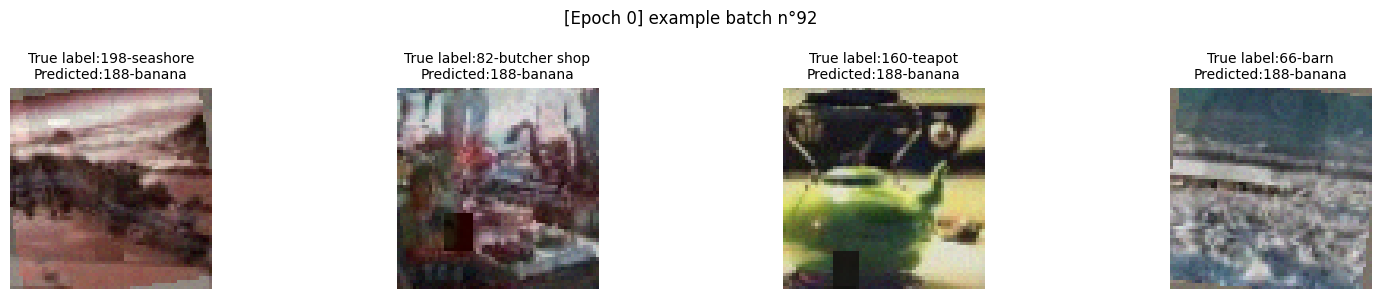

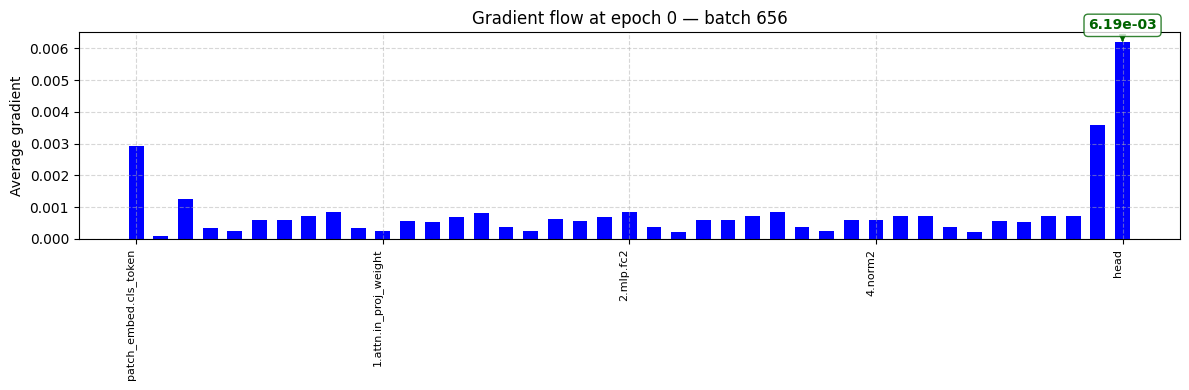


#################### [Train epoch 0]  || Loss 3580.462476  --> 3.580e+03  || Accuracy 0.0051-> (0.5095)%



Validation epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 0]  || Loss 430.084746  --> 4.301e+02 || Accuracy 0.0049-> (0.4900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 1:   0%|          | 0/657 [00:00<?, ?it/s]

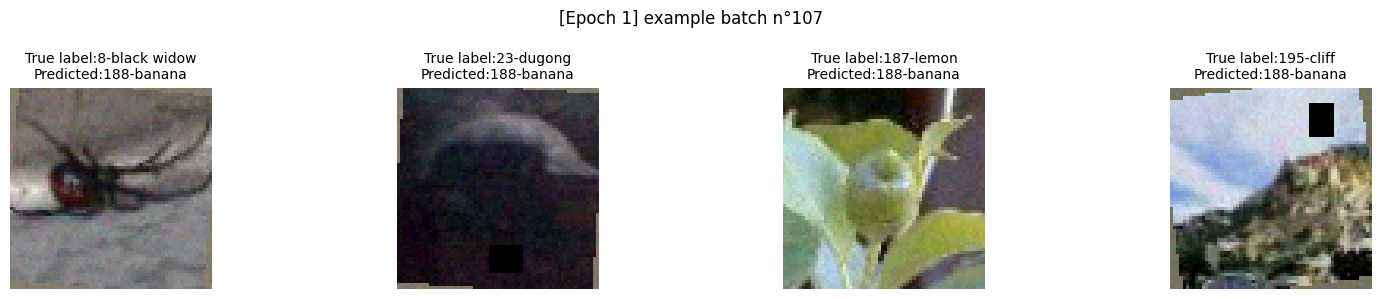

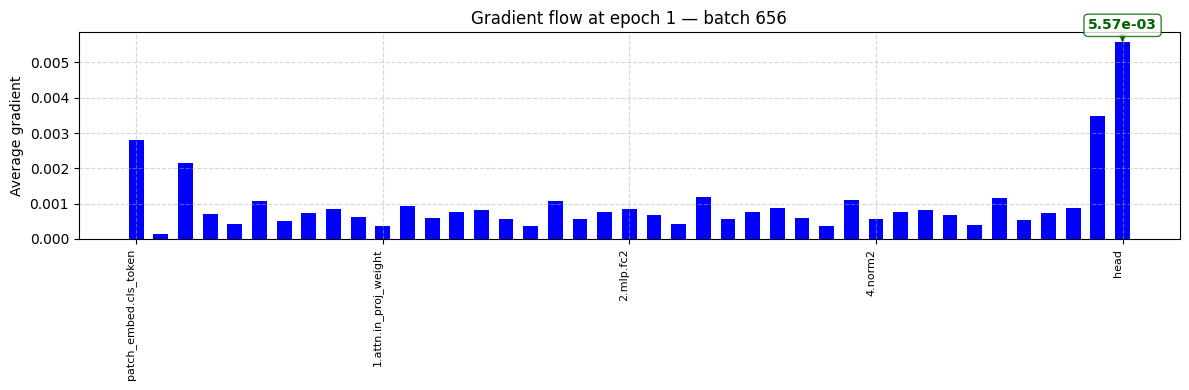


#################### [Train epoch 1]  || Loss 3382.594541  --> 3.383e+03  || Accuracy 0.0209-> (2.0940)%



Validation epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 1]  || Loss 390.199724  --> 3.902e+02 || Accuracy 0.0359-> (3.5900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 2:   0%|          | 0/657 [00:00<?, ?it/s]

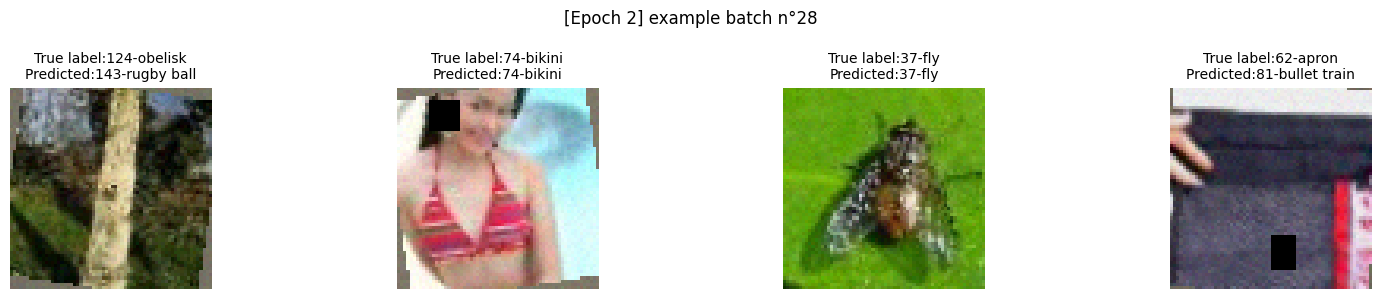

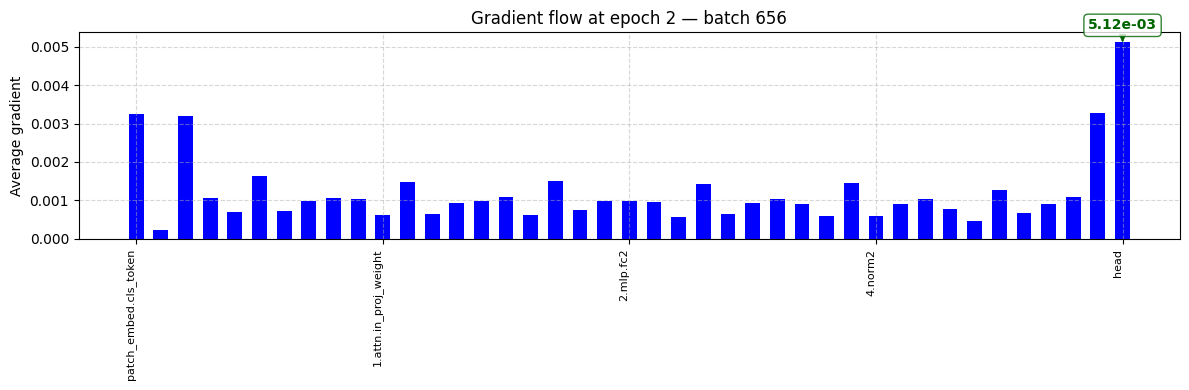


#################### [Train epoch 2]  || Loss 3229.663858  --> 3.230e+03  || Accuracy 0.0474-> (4.7357)%



Validation epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 2]  || Loss 363.601218  --> 3.636e+02 || Accuracy 0.0719-> (7.1900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 3:   0%|          | 0/657 [00:00<?, ?it/s]

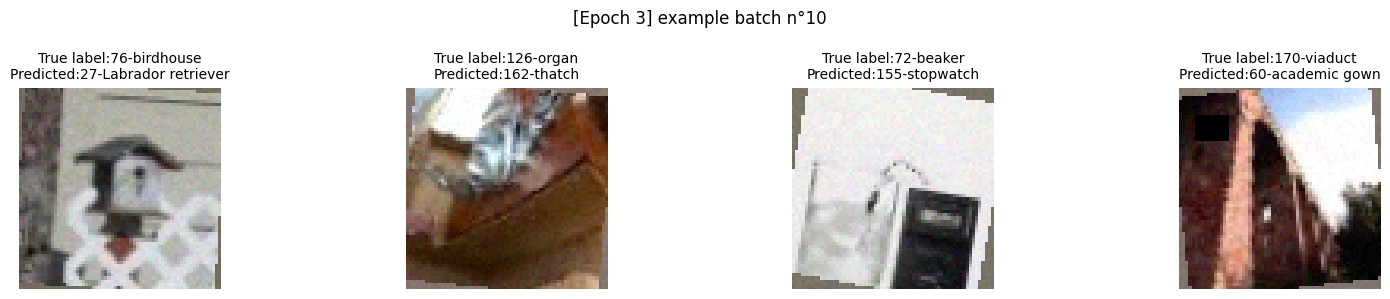

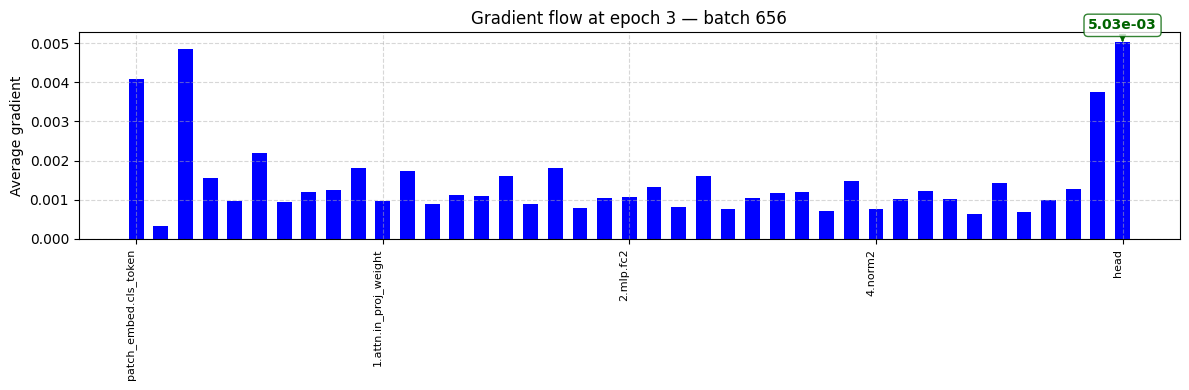


#################### [Train epoch 3]  || Loss 3068.600822  --> 3.069e+03  || Accuracy 0.0832-> (8.3179)%



Validation epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 3]  || Loss 341.447131  --> 3.414e+02 || Accuracy 0.1138-> (11.3800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 4:   0%|          | 0/657 [00:00<?, ?it/s]

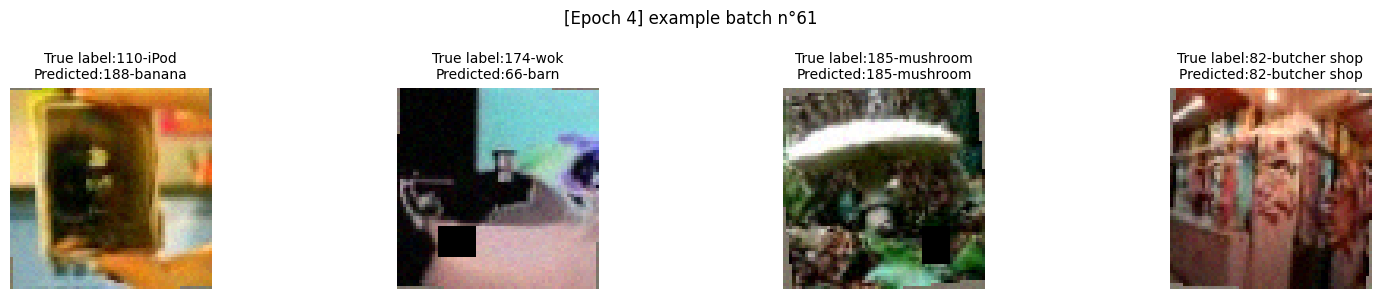

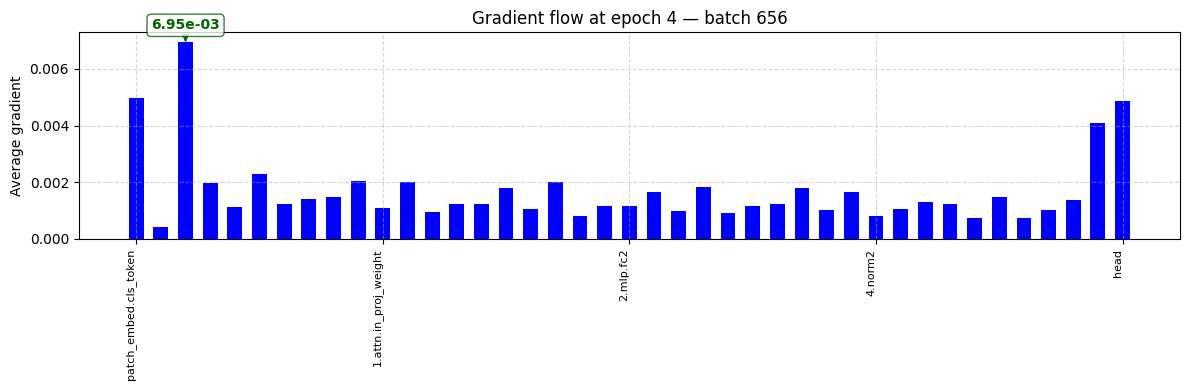


#################### [Train epoch 4]  || Loss 2958.026811  --> 2.958e+03  || Accuracy 0.1110-> (11.0976)%



Validation epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 4]  || Loss 326.536857  --> 3.265e+02 || Accuracy 0.1330-> (13.3000)%

Saving model..on Pietro pc


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Model Saved in Pietro pc!


Training epoch 5:   0%|          | 0/657 [00:00<?, ?it/s]

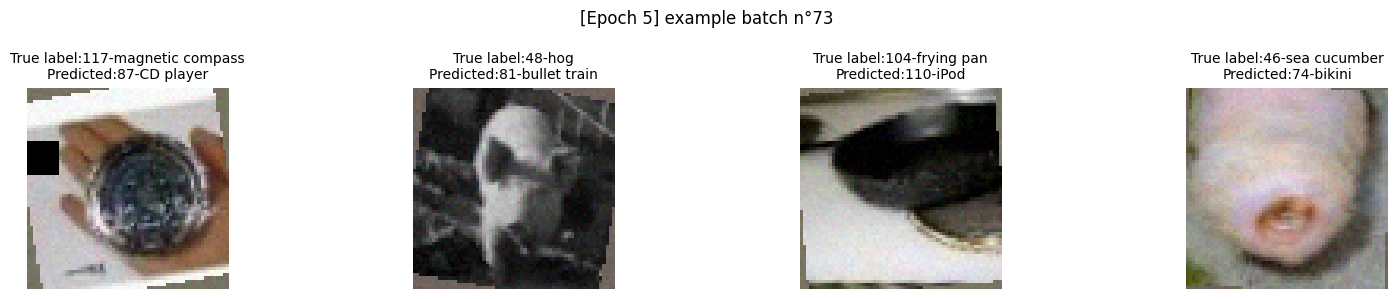

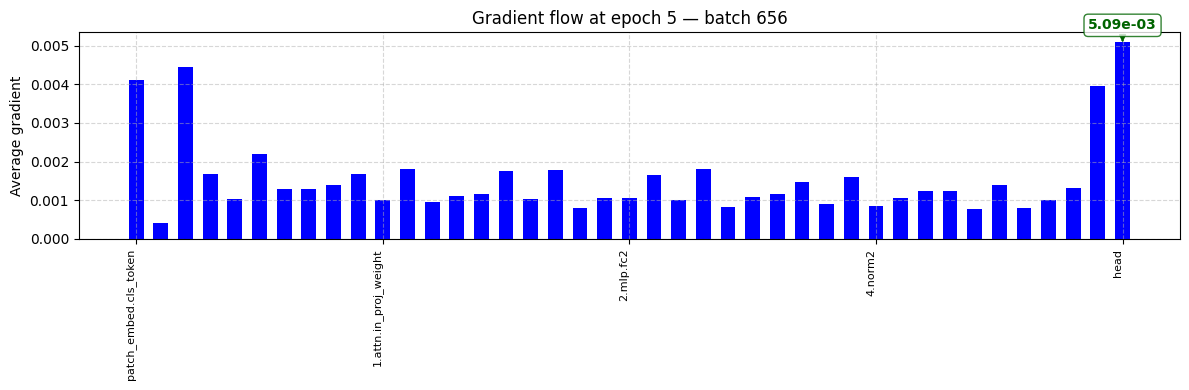


#################### [Train epoch 5]  || Loss 2863.866357  --> 2.864e+03  || Accuracy 0.1333-> (13.3262)%



Validation epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 5]  || Loss 313.346651  --> 3.133e+02 || Accuracy 0.1590-> (15.9000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 6:   0%|          | 0/657 [00:00<?, ?it/s]

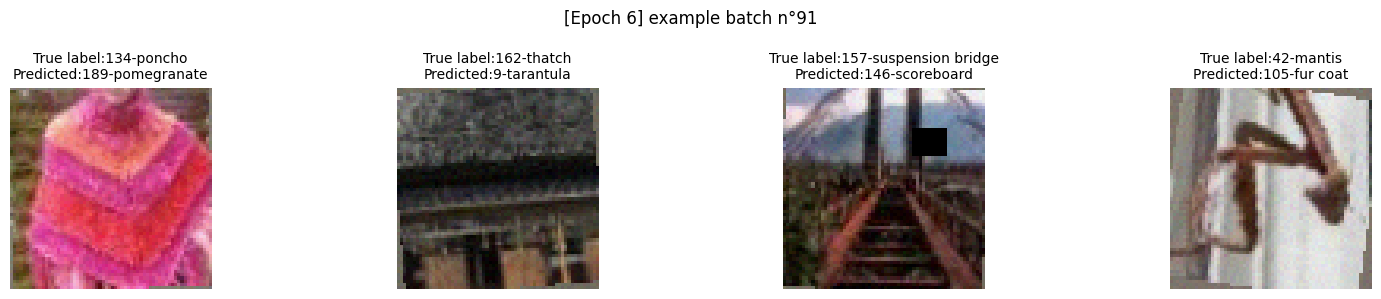

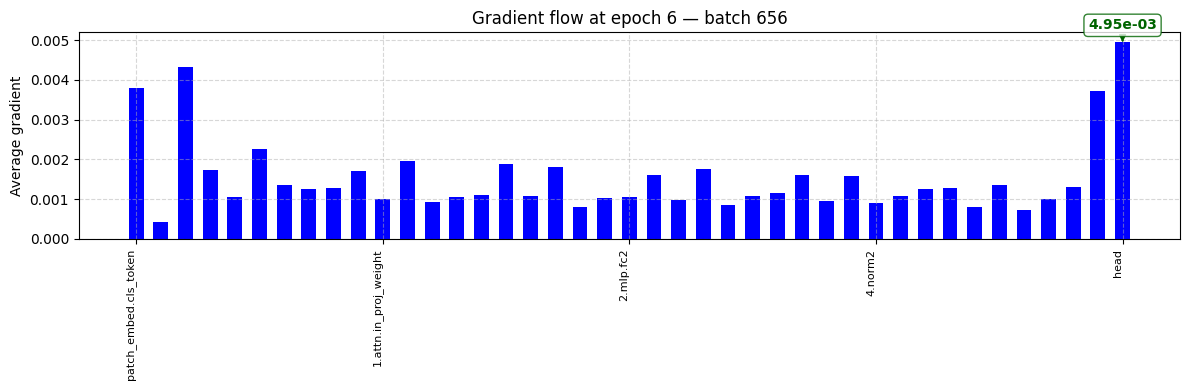


#################### [Train epoch 6]  || Loss 2787.562495  --> 2.788e+03  || Accuracy 0.1561-> (15.6107)%



Validation epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 6]  || Loss 303.050717  --> 3.031e+02 || Accuracy 0.1744-> (17.4400)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 7:   0%|          | 0/657 [00:00<?, ?it/s]

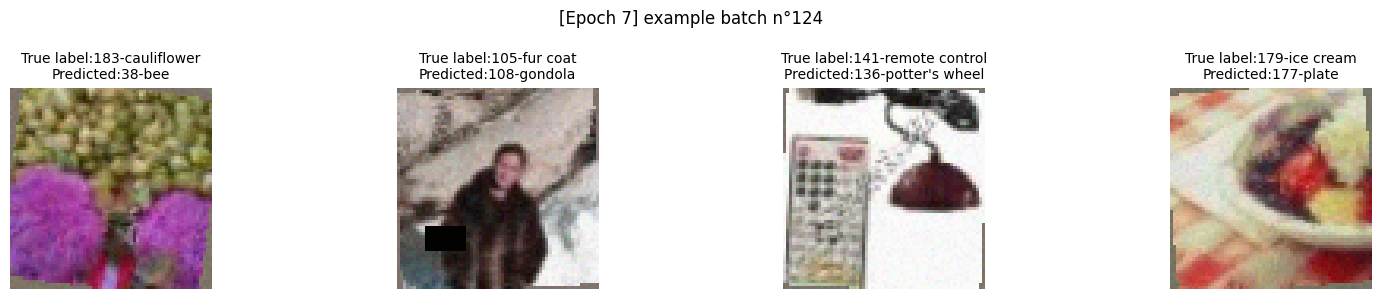

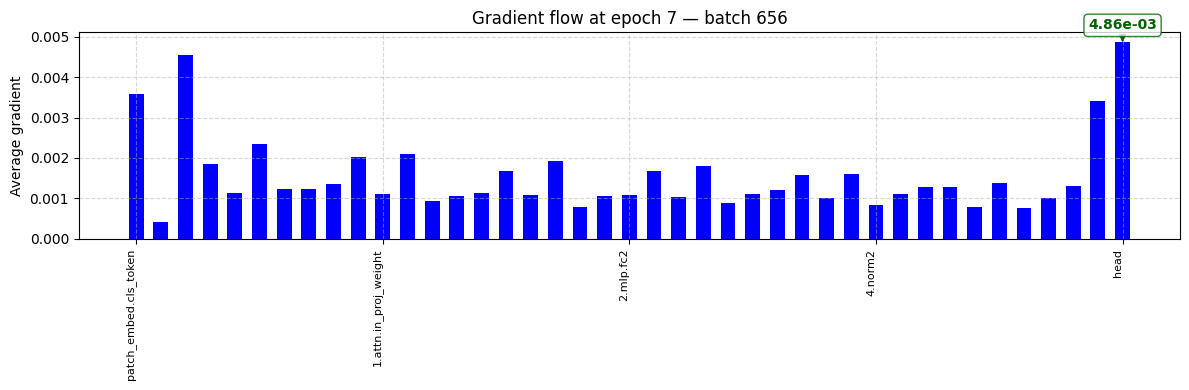


#################### [Train epoch 7]  || Loss 2723.458498  --> 2.723e+03  || Accuracy 0.1722-> (17.2250)%



Validation epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 7]  || Loss 296.774241  --> 2.968e+02 || Accuracy 0.1866-> (18.6600)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 8:   0%|          | 0/657 [00:00<?, ?it/s]

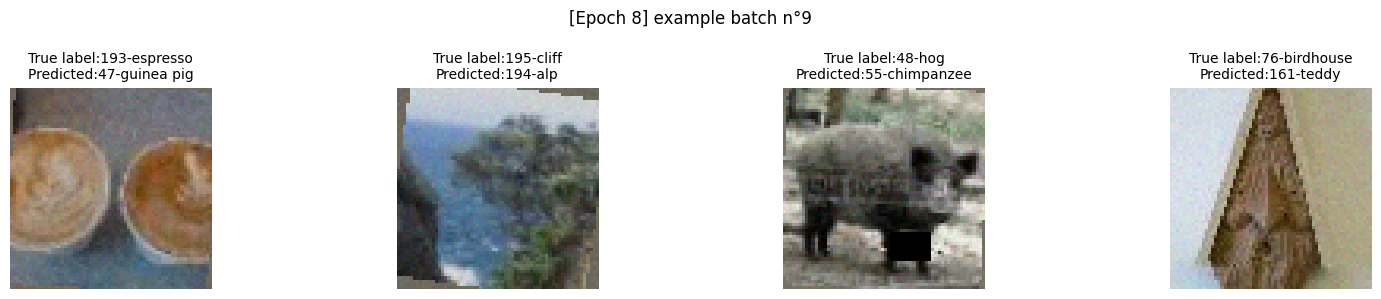

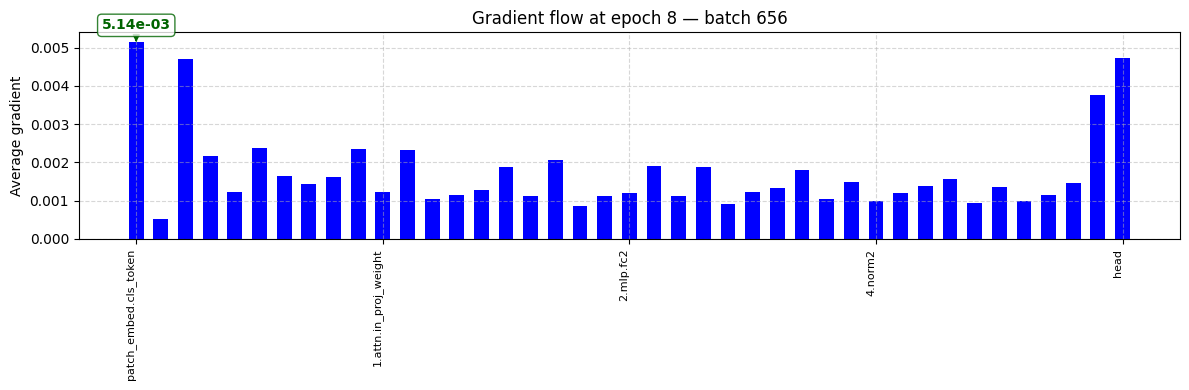


#################### [Train epoch 8]  || Loss 2662.560043  --> 2.663e+03  || Accuracy 0.1897-> (18.9702)%



Validation epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 8]  || Loss 289.553656  --> 2.896e+02 || Accuracy 0.2066-> (20.6600)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 9:   0%|          | 0/657 [00:00<?, ?it/s]

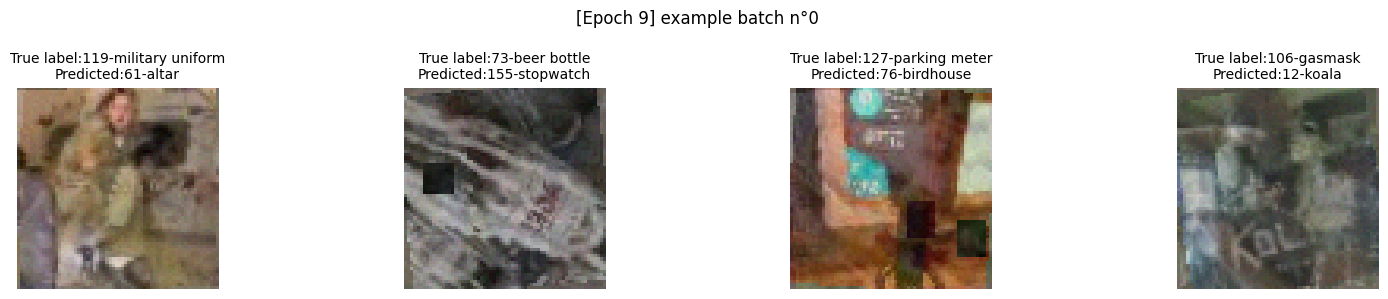

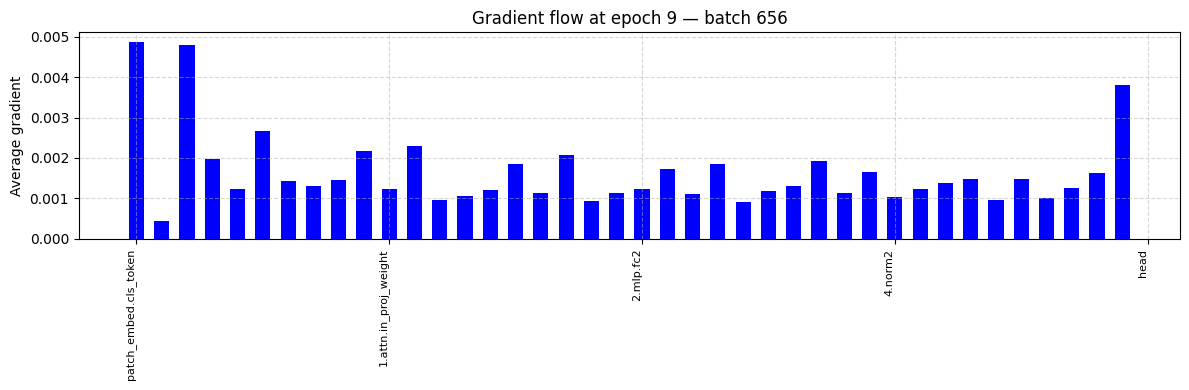


#################### [Train epoch 9]  || Loss 2604.575192  --> 2.605e+03  || Accuracy 0.2059-> (20.5917)%



Validation epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 9]  || Loss 283.228719  --> 2.832e+02 || Accuracy 0.2173-> (21.7300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 10:   0%|          | 0/657 [00:00<?, ?it/s]

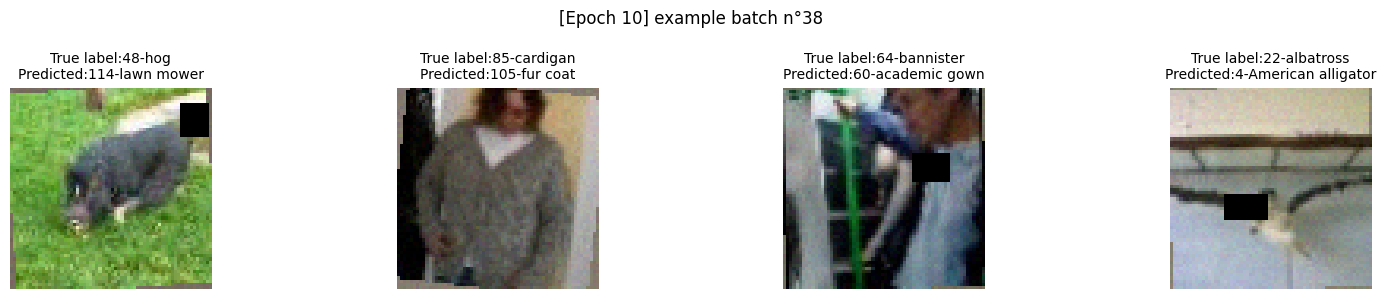

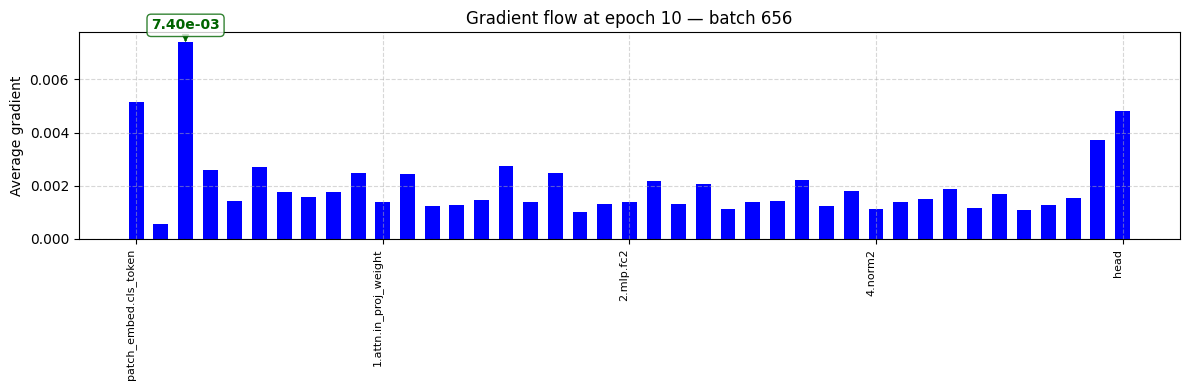


#################### [Train epoch 10]  || Loss 2560.286809  --> 2.560e+03  || Accuracy 0.2206-> (22.0560)%



Validation epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 10]  || Loss 278.945040  --> 2.789e+02 || Accuracy 0.2238-> (22.3800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 11:   0%|          | 0/657 [00:00<?, ?it/s]

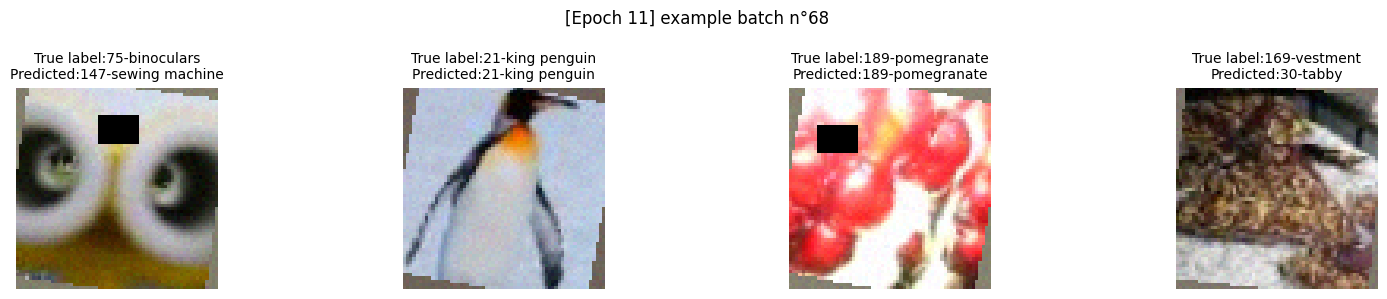

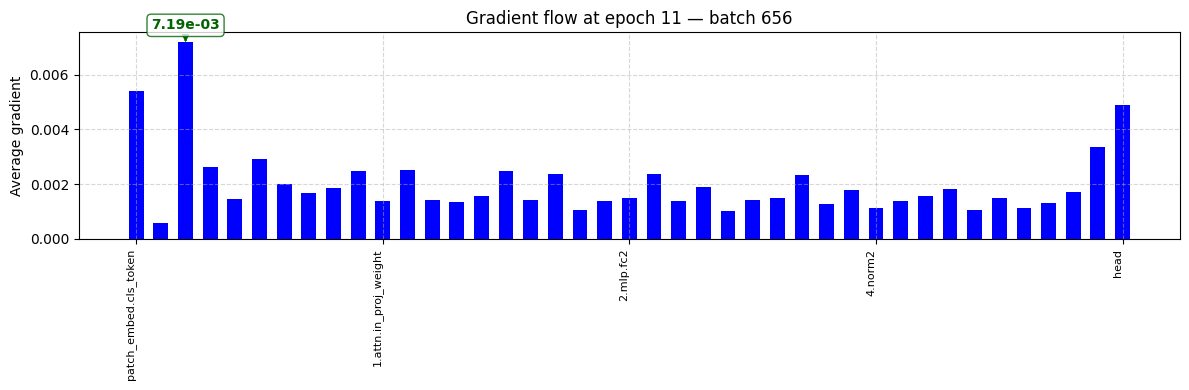


#################### [Train epoch 11]  || Loss 2515.131938  --> 2.515e+03  || Accuracy 0.2321-> (23.2119)%



Validation epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 11]  || Loss 274.997190  --> 2.750e+02 || Accuracy 0.2327-> (23.2700)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 12:   0%|          | 0/657 [00:00<?, ?it/s]

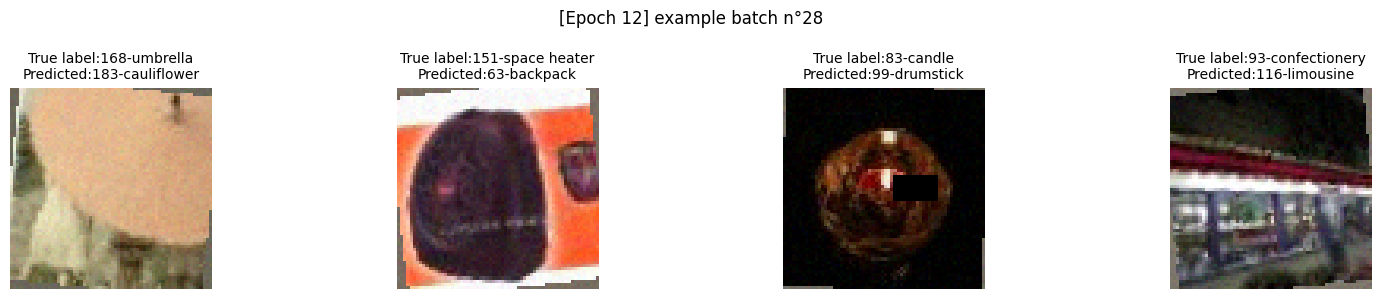

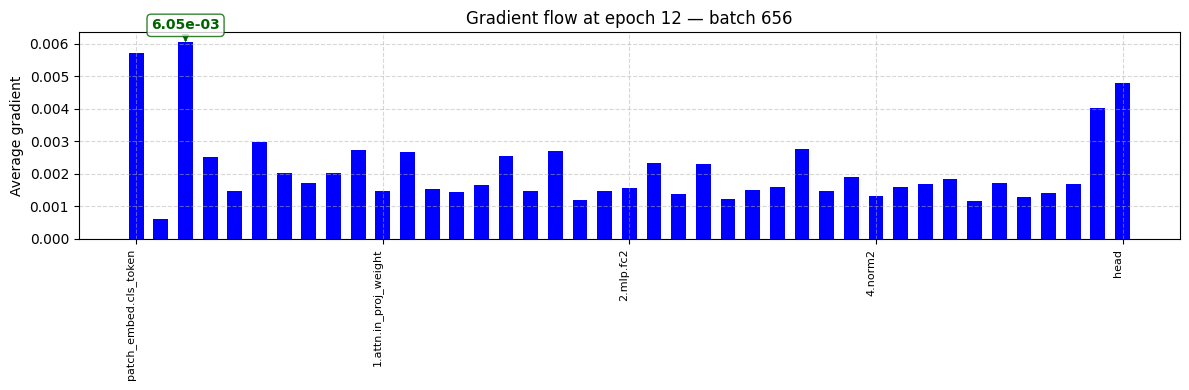


#################### [Train epoch 12]  || Loss 2468.479061  --> 2.468e+03  || Accuracy 0.2473-> (24.7286)%



Validation epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 12]  || Loss 268.858988  --> 2.689e+02 || Accuracy 0.2428-> (24.2800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 13:   0%|          | 0/657 [00:00<?, ?it/s]

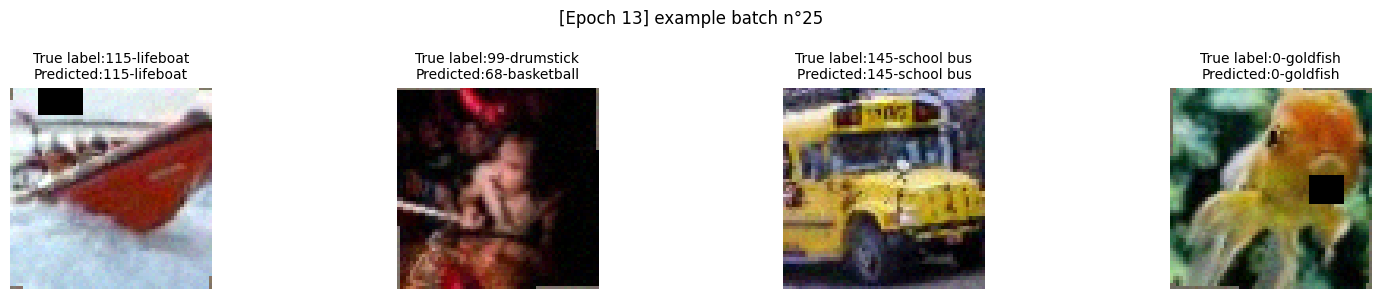

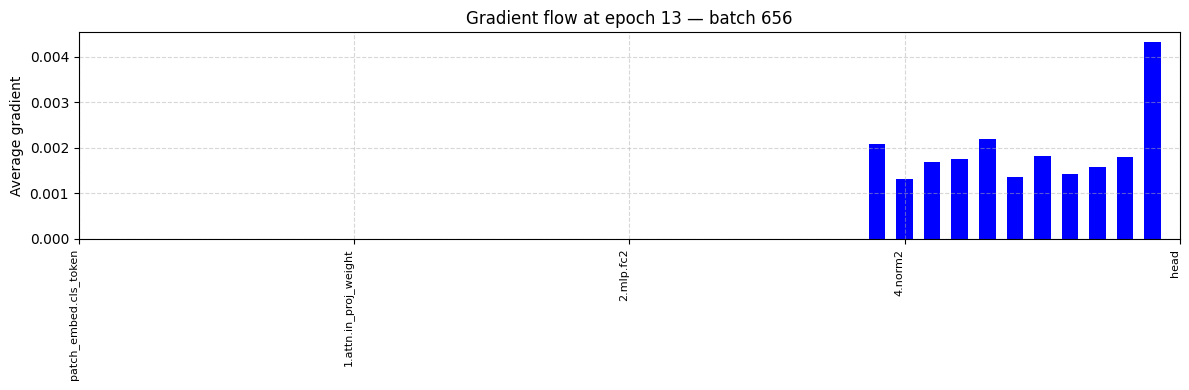


#################### [Train epoch 13]  || Loss 2435.640706  --> 2.436e+03  || Accuracy 0.2595-> (25.9548)%



Validation epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 13]  || Loss 265.261270  --> 2.653e+02 || Accuracy 0.2539-> (25.3900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 14:   0%|          | 0/657 [00:00<?, ?it/s]

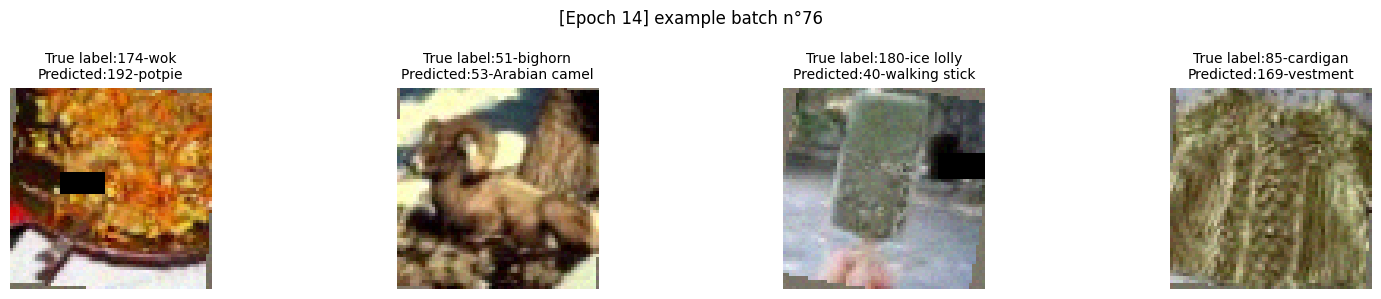

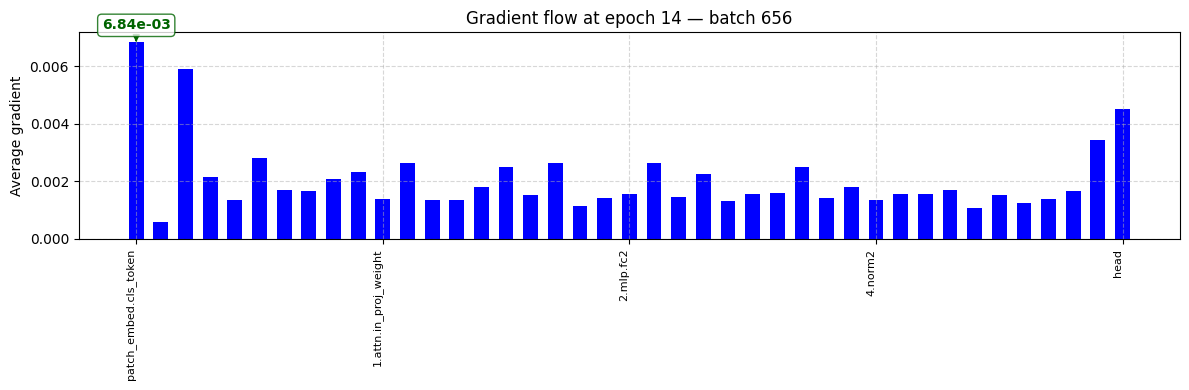


#################### [Train epoch 14]  || Loss 2388.328198  --> 2.388e+03  || Accuracy 0.2720-> (27.1988)%



Validation epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 14]  || Loss 263.867393  --> 2.639e+02 || Accuracy 0.2582-> (25.8200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 15:   0%|          | 0/657 [00:00<?, ?it/s]

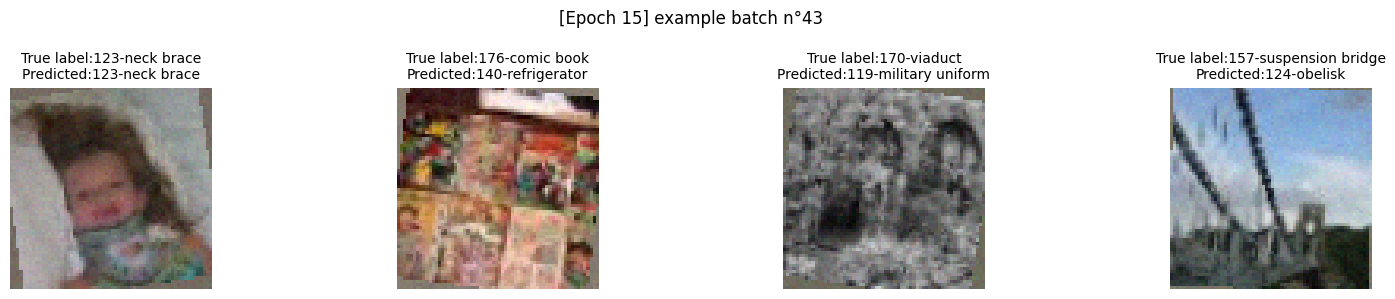

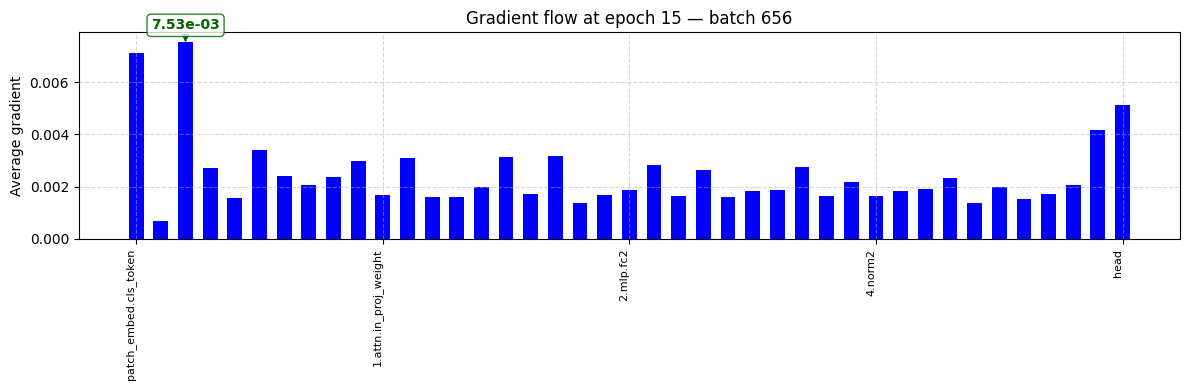


#################### [Train epoch 15]  || Loss 2360.581710  --> 2.361e+03  || Accuracy 0.2829-> (28.2940)%



Validation epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 15]  || Loss 259.190845  --> 2.592e+02 || Accuracy 0.2721-> (27.2100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 16:   0%|          | 0/657 [00:00<?, ?it/s]

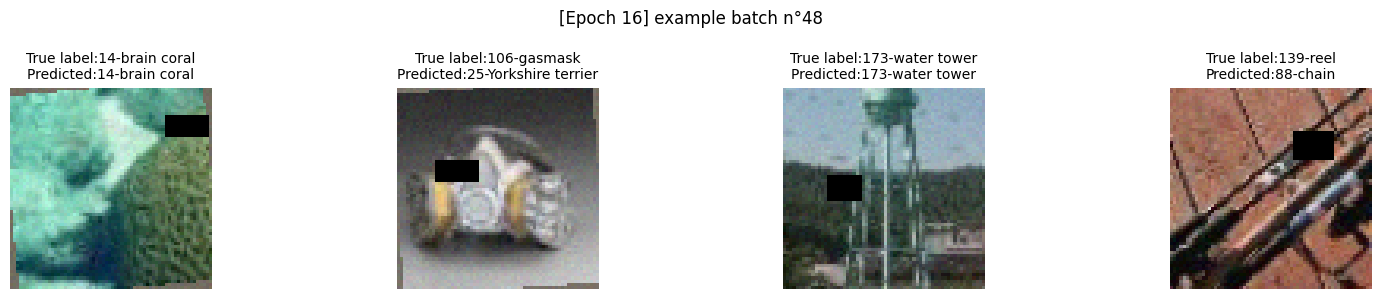

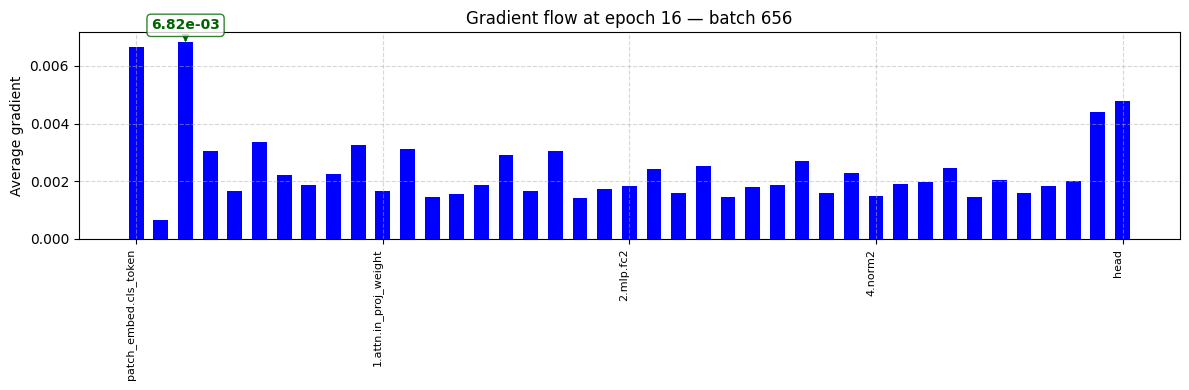


#################### [Train epoch 16]  || Loss 2334.493186  --> 2.334e+03  || Accuracy 0.2921-> (29.2107)%



Validation epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 16]  || Loss 258.679127  --> 2.587e+02 || Accuracy 0.2692-> (26.9200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 17:   0%|          | 0/657 [00:00<?, ?it/s]

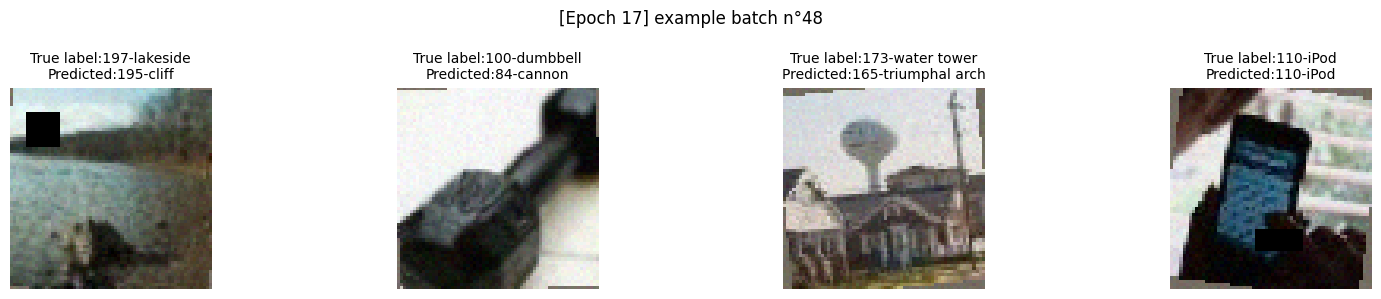

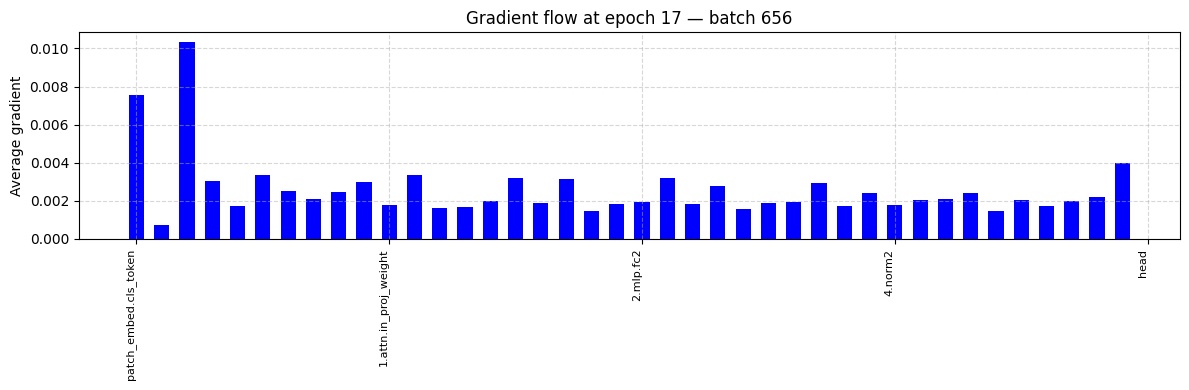


#################### [Train epoch 17]  || Loss 2280.807530  --> 2.281e+03  || Accuracy 0.3042-> (30.4155)%



Validation epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 17]  || Loss 255.457104  --> 2.555e+02 || Accuracy 0.2828-> (28.2800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 18:   0%|          | 0/657 [00:00<?, ?it/s]

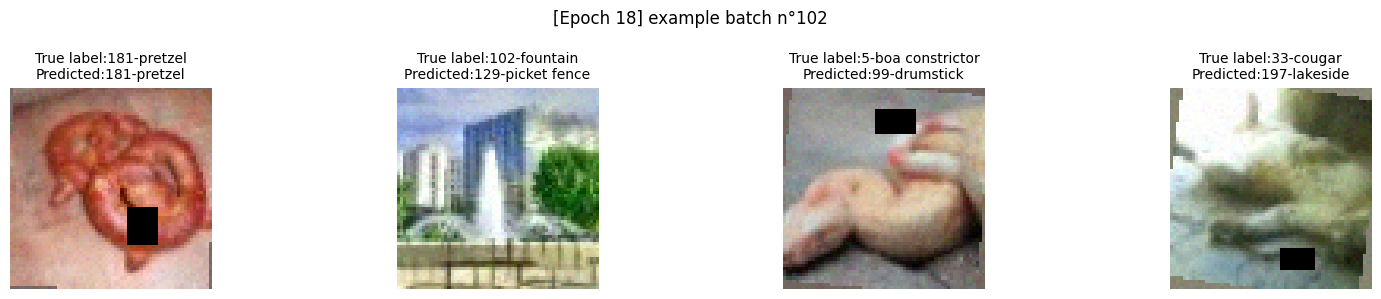

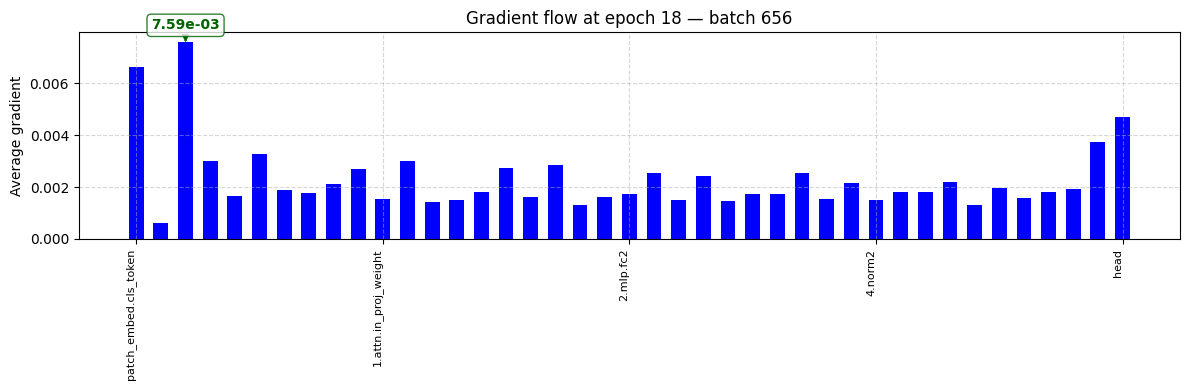


#################### [Train epoch 18]  || Loss 2250.652191  --> 2.251e+03  || Accuracy 0.3163-> (31.6274)%



Validation epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 18]  || Loss 255.386089  --> 2.554e+02 || Accuracy 0.2775-> (27.7500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 19:   0%|          | 0/657 [00:00<?, ?it/s]

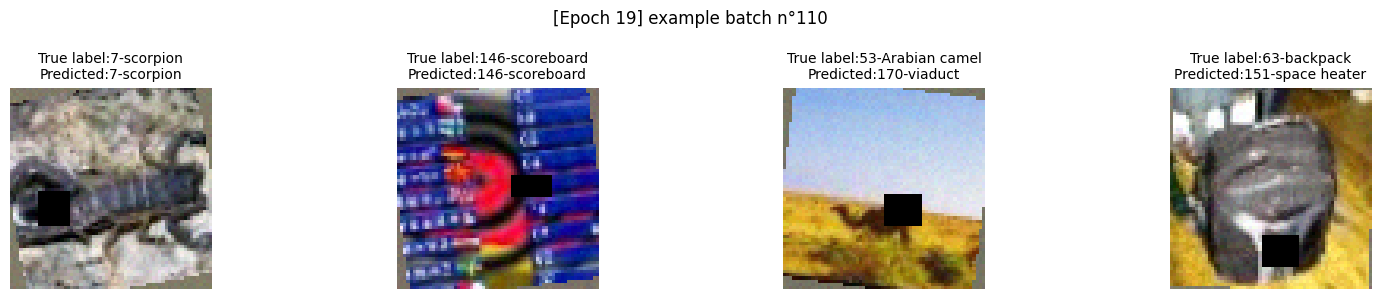

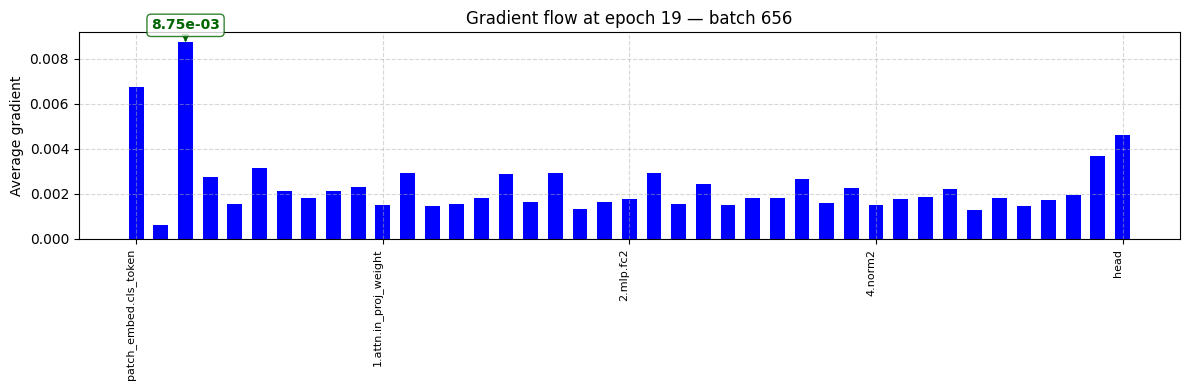


#################### [Train epoch 19]  || Loss 2234.001821  --> 2.234e+03  || Accuracy 0.3257-> (32.5750)%



Validation epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 19]  || Loss 250.566473  --> 2.506e+02 || Accuracy 0.2902-> (29.0200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 20:   0%|          | 0/657 [00:00<?, ?it/s]

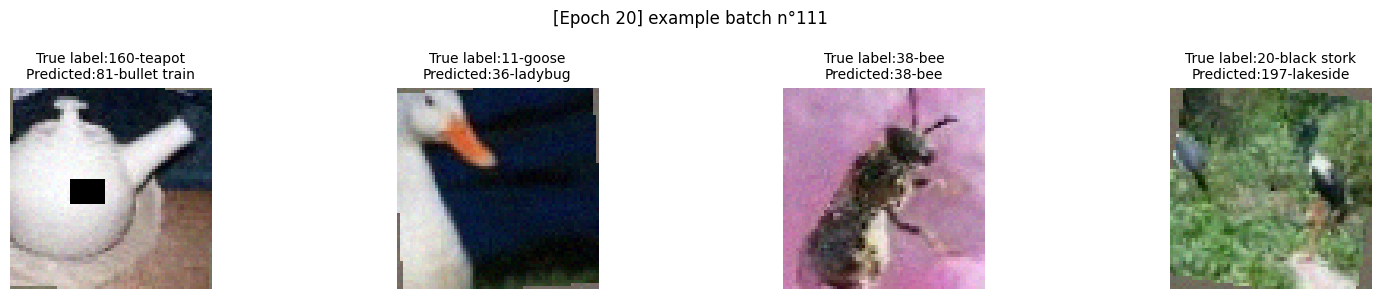

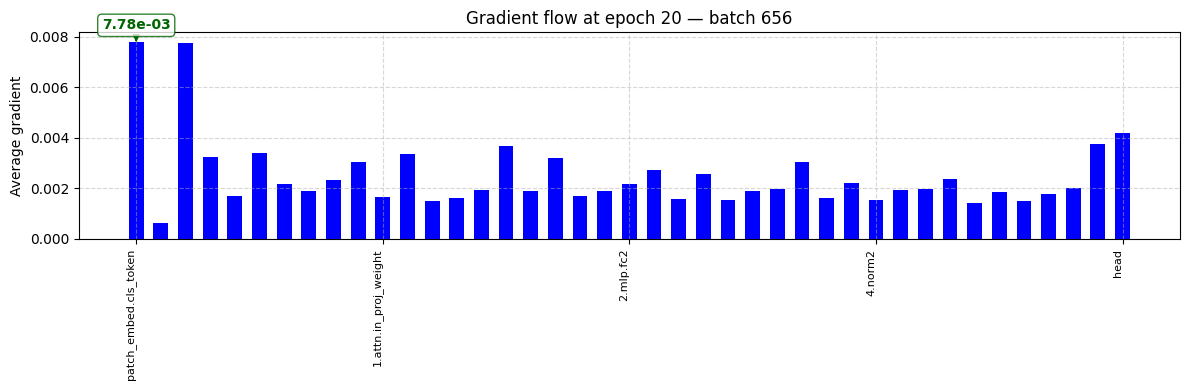


#################### [Train epoch 20]  || Loss 2196.264953  --> 2.196e+03  || Accuracy 0.3382-> (33.8214)%



Validation epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 20]  || Loss 247.748158  --> 2.477e+02 || Accuracy 0.2931-> (29.3100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 21:   0%|          | 0/657 [00:00<?, ?it/s]

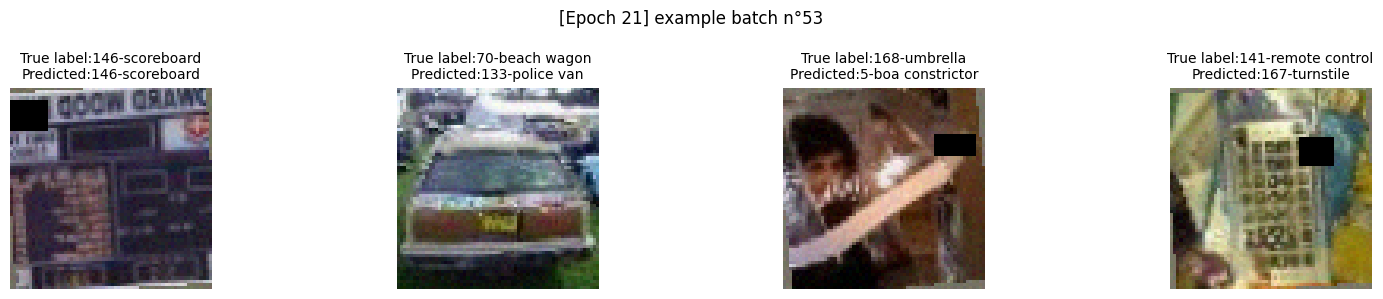

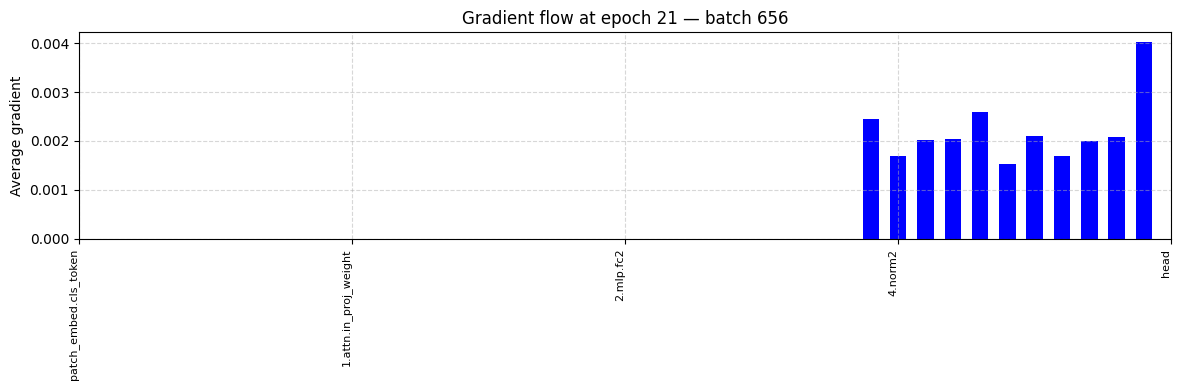


#################### [Train epoch 21]  || Loss 2173.299210  --> 2.173e+03  || Accuracy 0.3454-> (34.5357)%



Validation epoch 21:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 21]  || Loss 249.573923  --> 2.496e+02 || Accuracy 0.2916-> (29.1600)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 22:   0%|          | 0/657 [00:00<?, ?it/s]

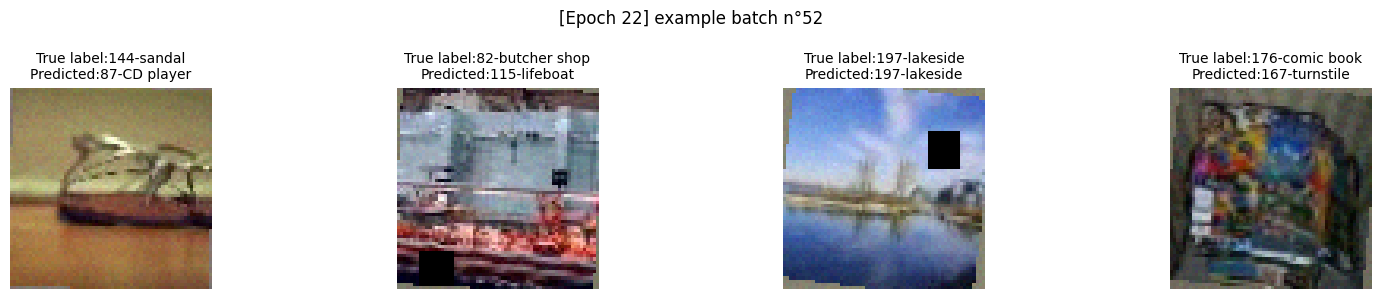

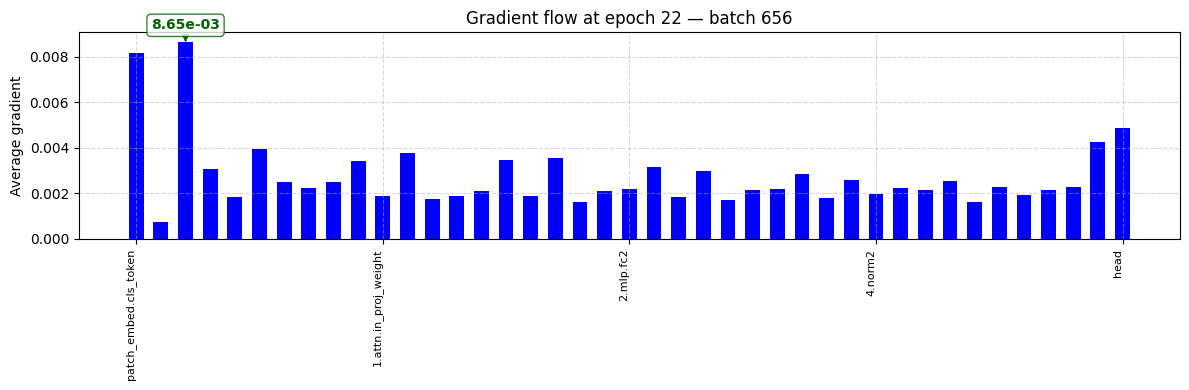


#################### [Train epoch 22]  || Loss 2167.004613  --> 2.167e+03  || Accuracy 0.3516-> (35.1643)%



Validation epoch 22:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 22]  || Loss 245.702194  --> 2.457e+02 || Accuracy 0.3019-> (30.1900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 23:   0%|          | 0/657 [00:00<?, ?it/s]

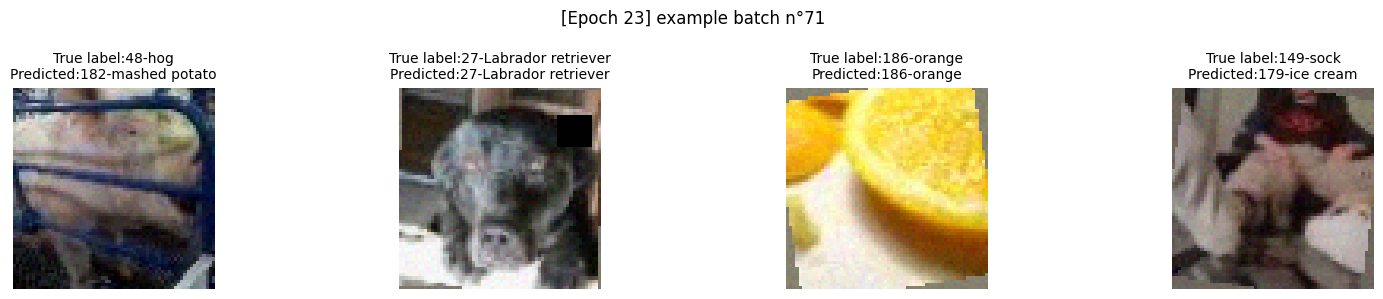

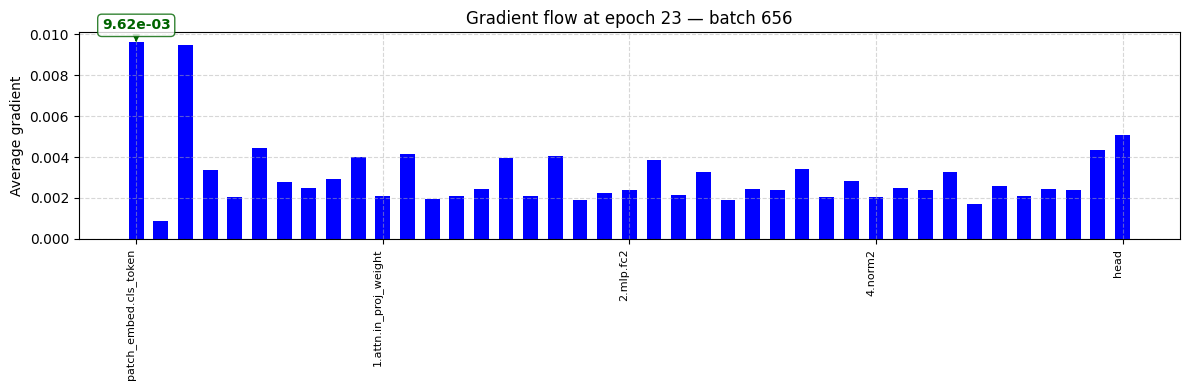


#################### [Train epoch 23]  || Loss 2126.308329  --> 2.126e+03  || Accuracy 0.3644-> (36.4369)%



Validation epoch 23:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 23]  || Loss 246.575181  --> 2.466e+02 || Accuracy 0.2979-> (29.7900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 24:   0%|          | 0/657 [00:00<?, ?it/s]

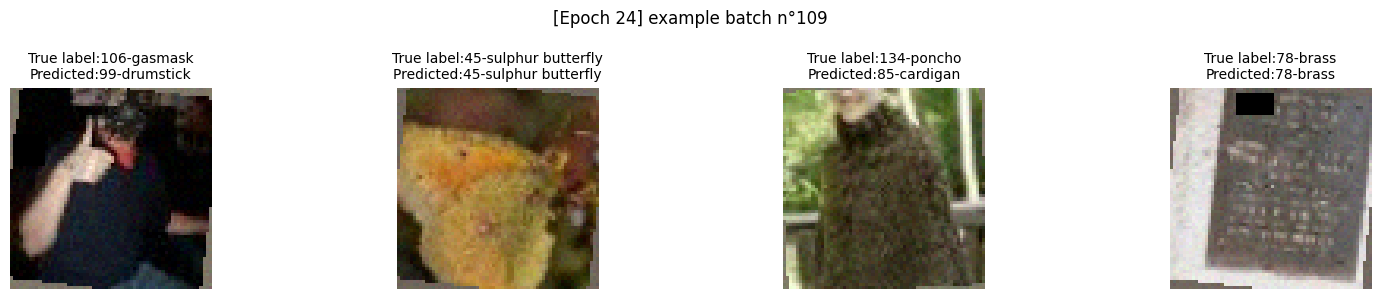

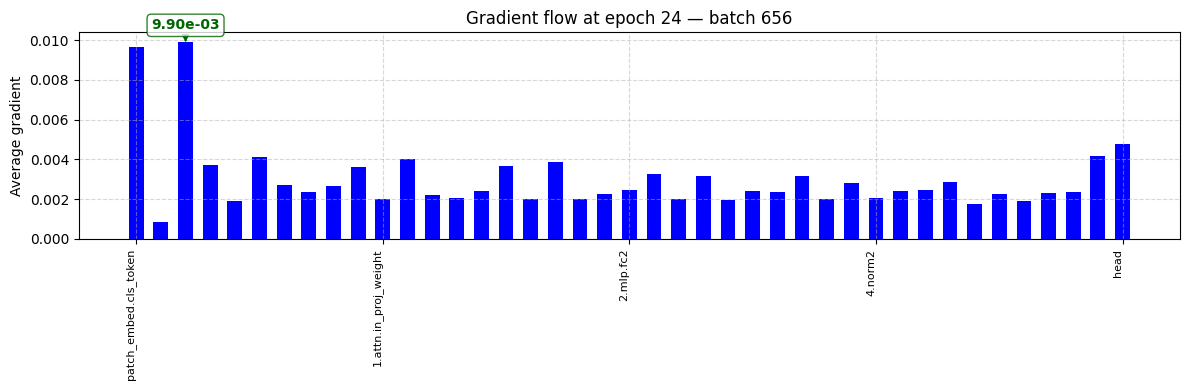


#################### [Train epoch 24]  || Loss 2102.853385  --> 2.103e+03  || Accuracy 0.3715-> (37.1452)%



Validation epoch 24:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 24]  || Loss 243.604410  --> 2.436e+02 || Accuracy 0.3109-> (31.0900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 25:   0%|          | 0/657 [00:00<?, ?it/s]

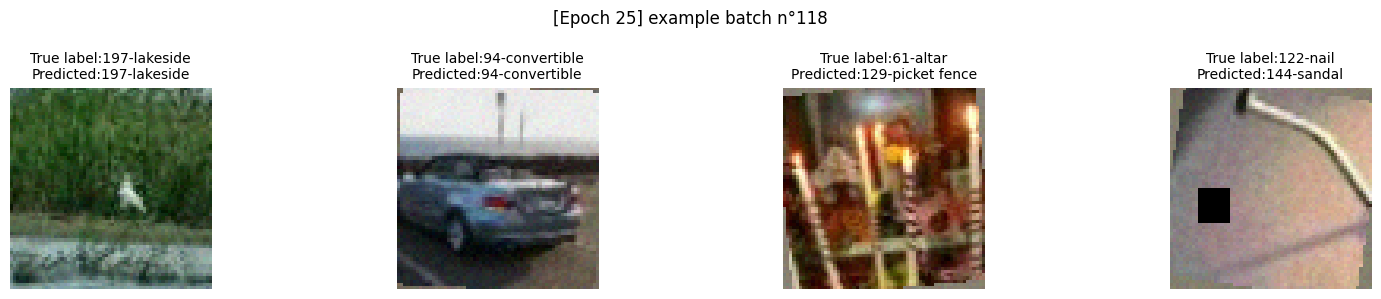

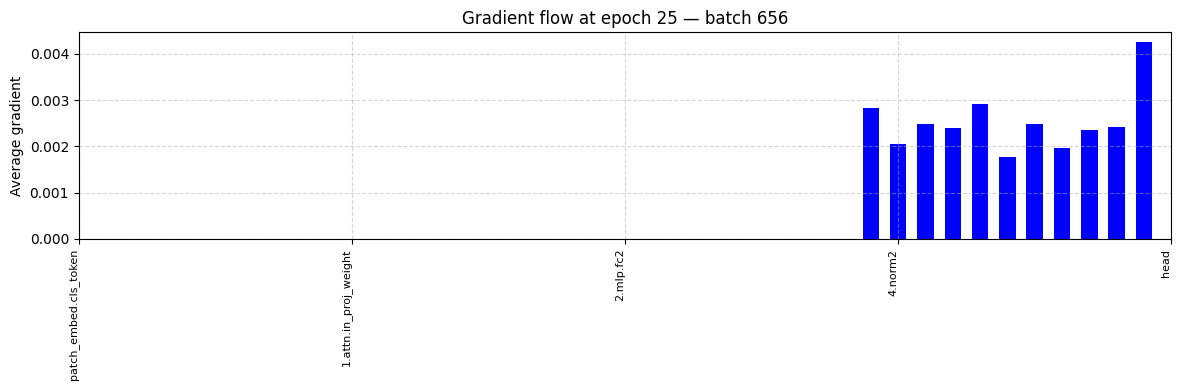


#################### [Train epoch 25]  || Loss 2070.976172  --> 2.071e+03  || Accuracy 0.3845-> (38.4464)%



Validation epoch 25:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 25]  || Loss 244.958009  --> 2.450e+02 || Accuracy 0.3072-> (30.7200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 26:   0%|          | 0/657 [00:00<?, ?it/s]

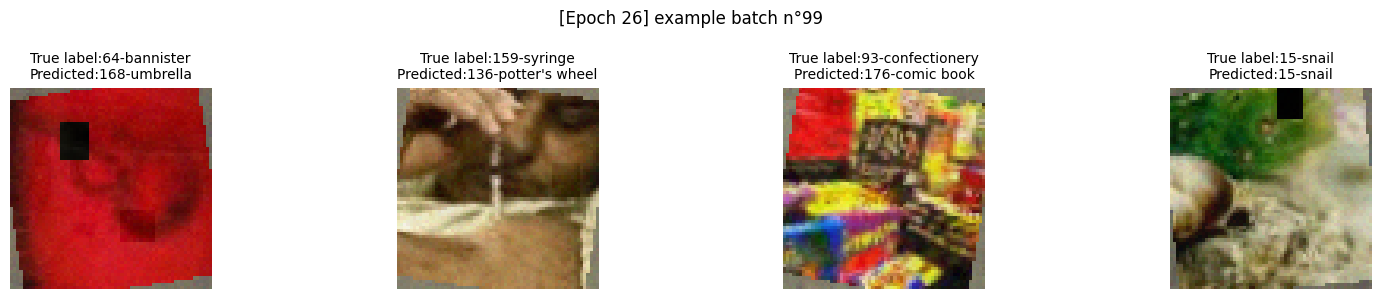

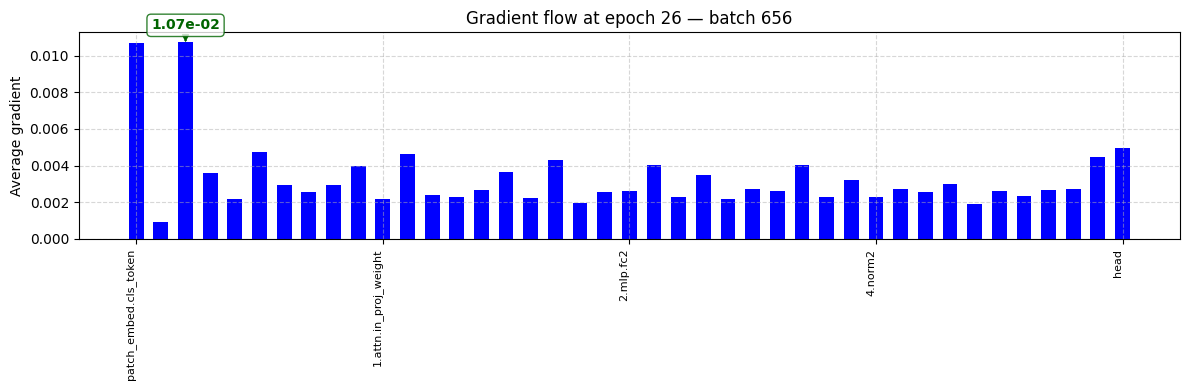


#################### [Train epoch 26]  || Loss 2049.403220  --> 2.049e+03  || Accuracy 0.3947-> (39.4702)%



Validation epoch 26:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 26]  || Loss 242.871195  --> 2.429e+02 || Accuracy 0.3113-> (31.1300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 27:   0%|          | 0/657 [00:00<?, ?it/s]

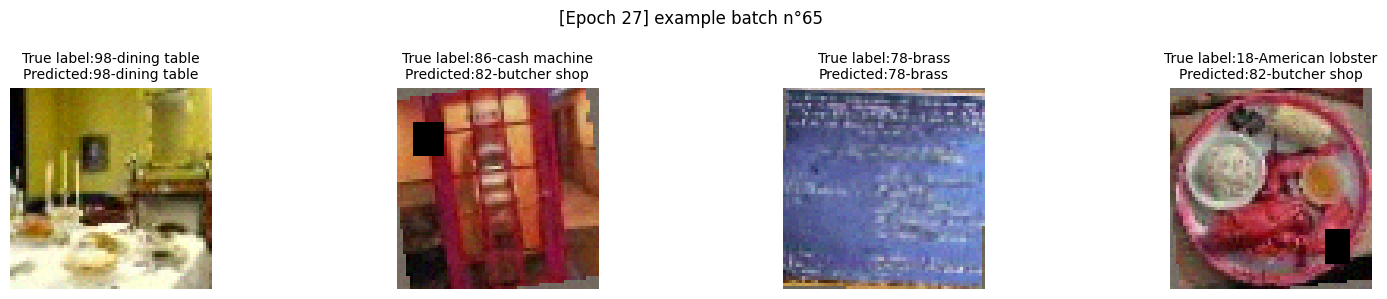

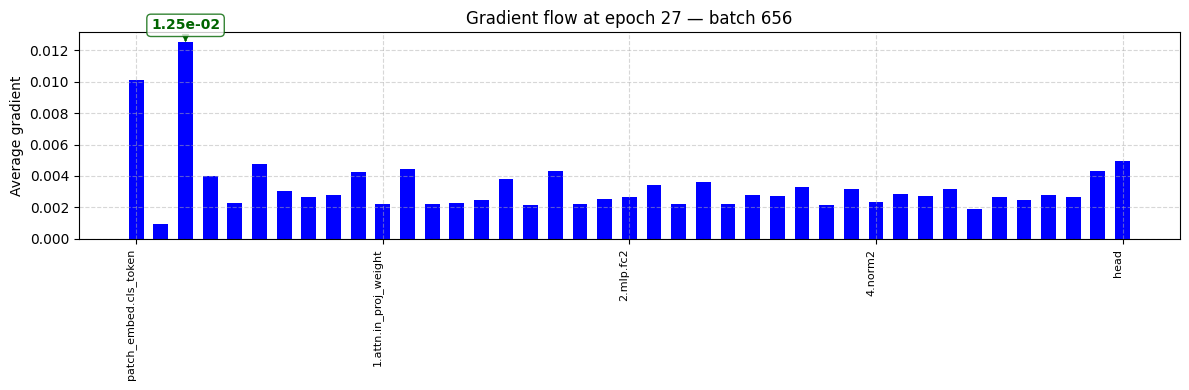


#################### [Train epoch 27]  || Loss 2013.845243  --> 2.014e+03  || Accuracy 0.4029-> (40.2917)%



Validation epoch 27:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 27]  || Loss 240.191878  --> 2.402e+02 || Accuracy 0.3203-> (32.0300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 28:   0%|          | 0/657 [00:00<?, ?it/s]

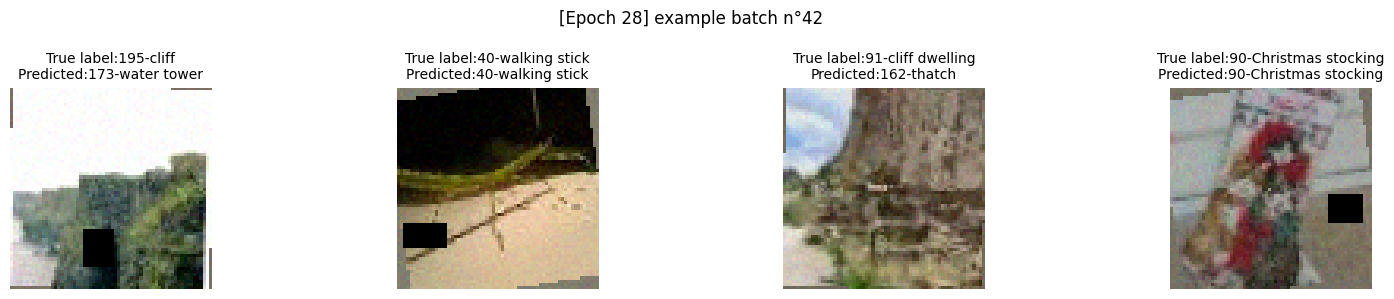

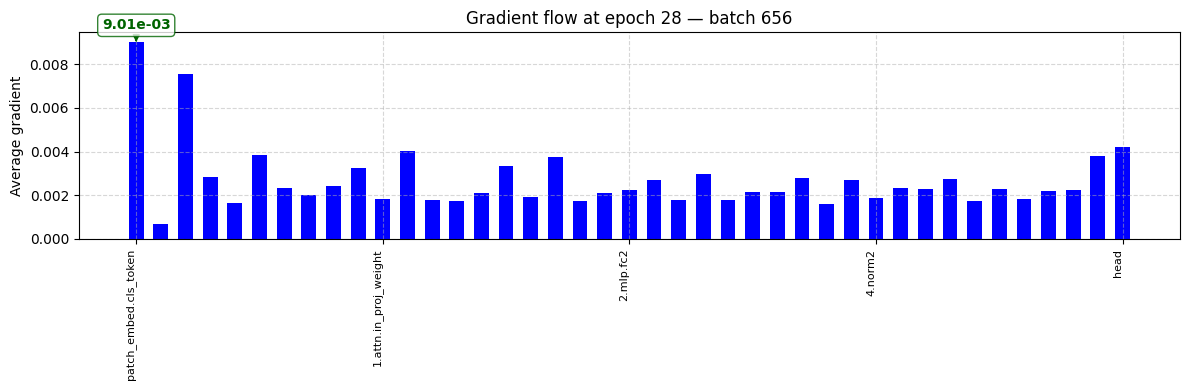


#################### [Train epoch 28]  || Loss 1998.981787  --> 1.999e+03  || Accuracy 0.4090-> (40.8964)%



Validation epoch 28:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 28]  || Loss 241.396672  --> 2.414e+02 || Accuracy 0.3173-> (31.7300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 29:   0%|          | 0/657 [00:00<?, ?it/s]

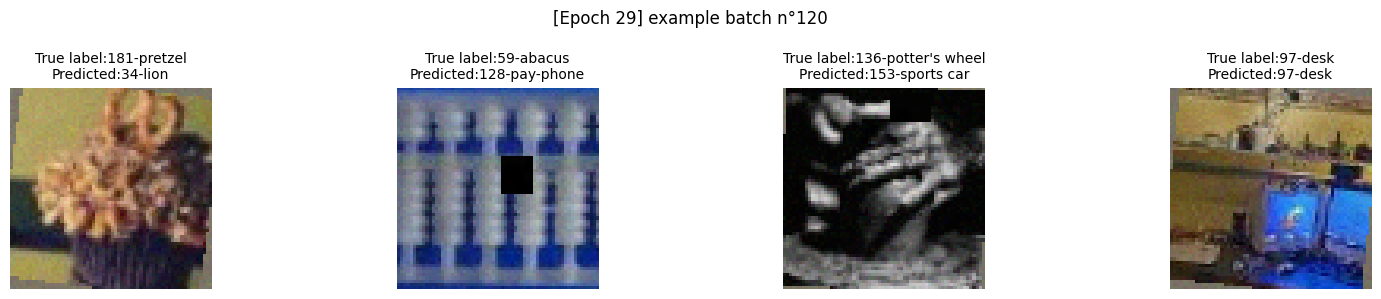

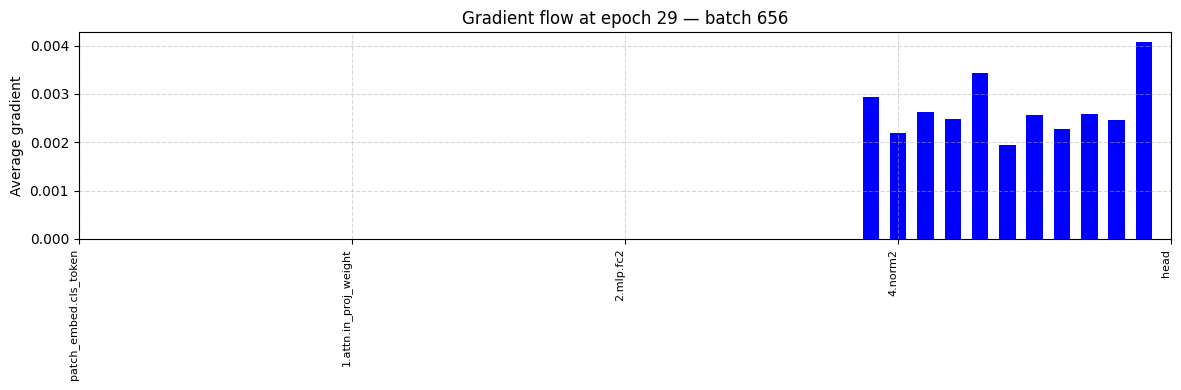


#################### [Train epoch 29]  || Loss 1969.547189  --> 1.970e+03  || Accuracy 0.4200-> (42.0024)%



Validation epoch 29:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 29]  || Loss 239.801956  --> 2.398e+02 || Accuracy 0.3223-> (32.2300)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 30:   0%|          | 0/657 [00:00<?, ?it/s]

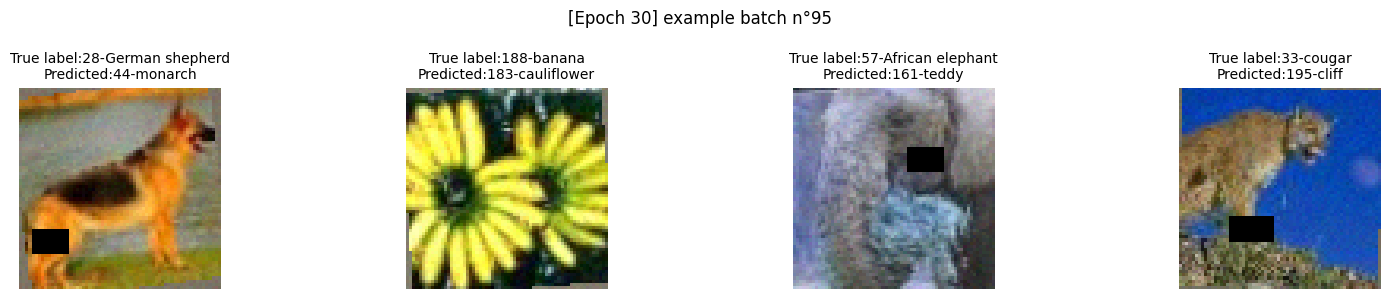

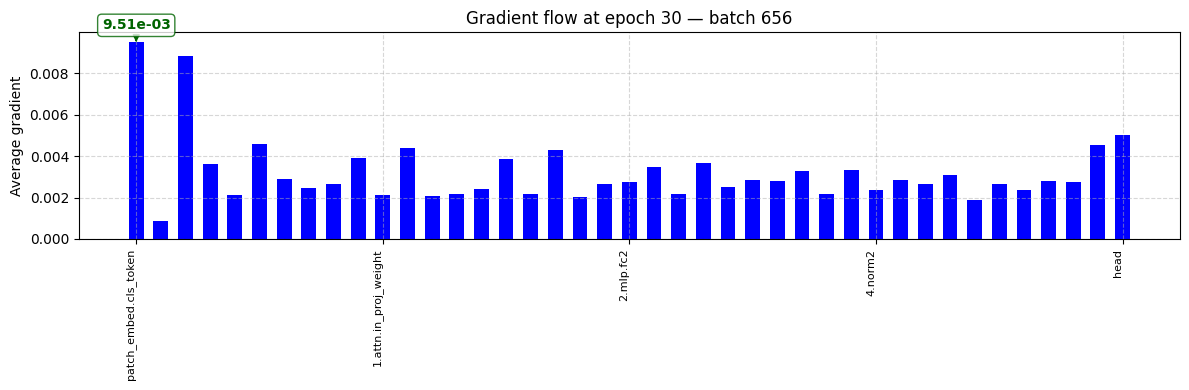


#################### [Train epoch 30]  || Loss 1953.586666  --> 1.954e+03  || Accuracy 0.4281-> (42.8119)%



Validation epoch 30:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 30]  || Loss 241.209799  --> 2.412e+02 || Accuracy 0.3164-> (31.6400)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 31:   0%|          | 0/657 [00:00<?, ?it/s]

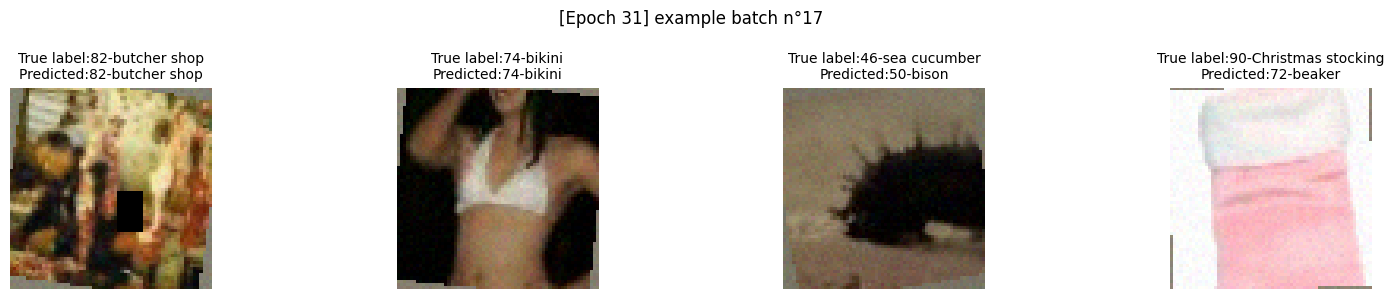

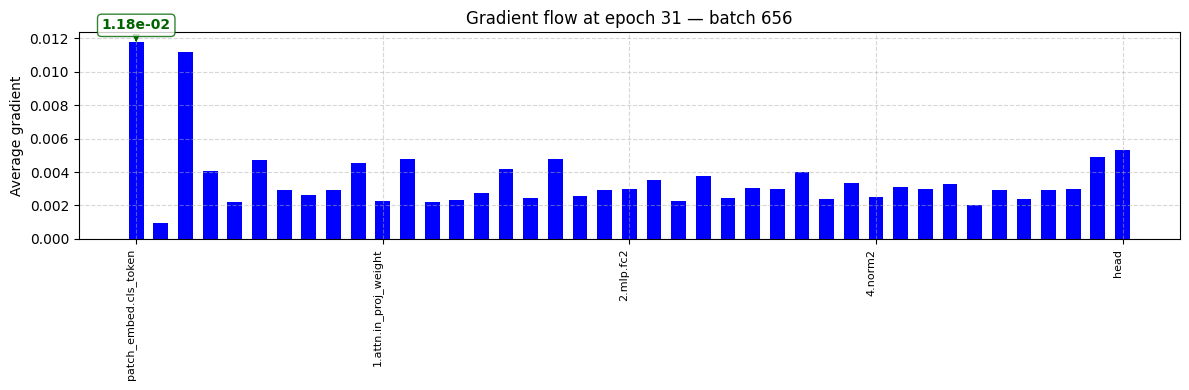


#################### [Train epoch 31]  || Loss 1939.786625  --> 1.940e+03  || Accuracy 0.4340-> (43.4048)%



Validation epoch 31:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 31]  || Loss 239.217554  --> 2.392e+02 || Accuracy 0.3200-> (32.0000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 32:   0%|          | 0/657 [00:00<?, ?it/s]

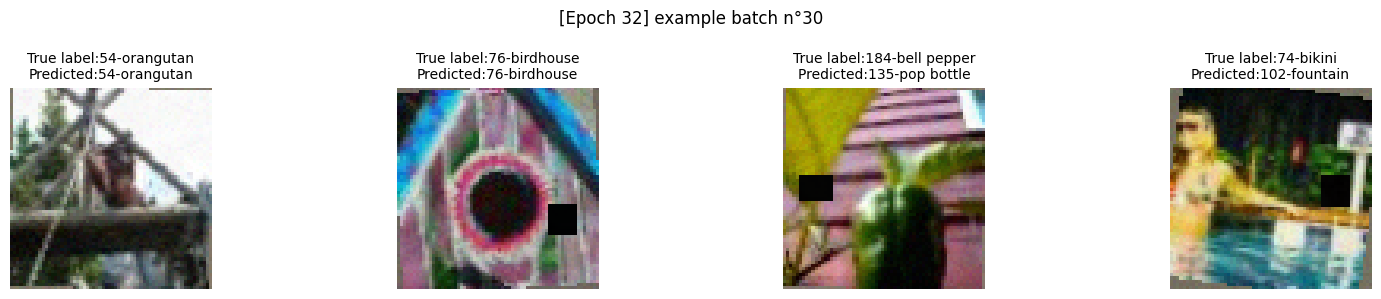

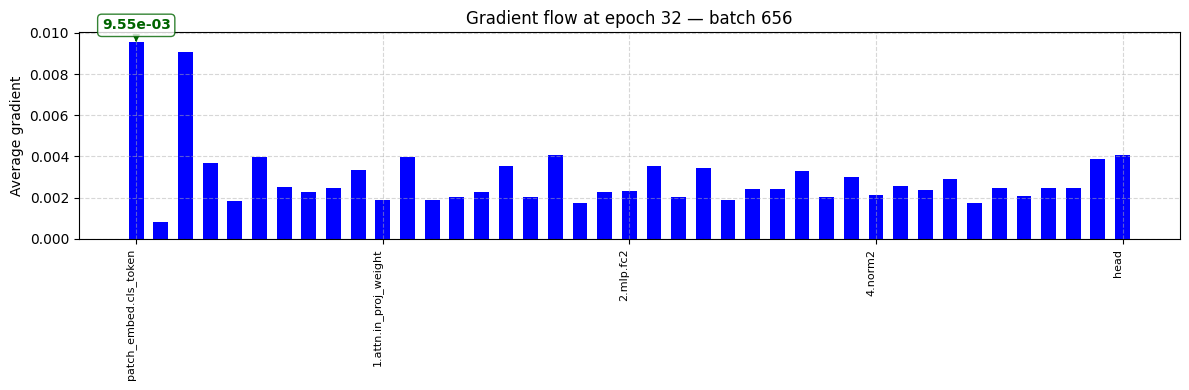


#################### [Train epoch 32]  || Loss 1926.462490  --> 1.926e+03  || Accuracy 0.4401-> (44.0119)%



Validation epoch 32:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 32]  || Loss 236.610820  --> 2.366e+02 || Accuracy 0.3268-> (32.6800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 33:   0%|          | 0/657 [00:00<?, ?it/s]

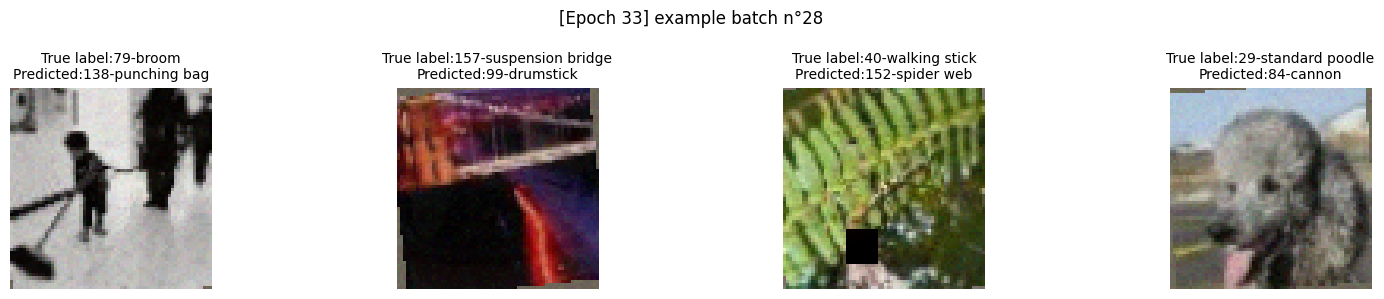

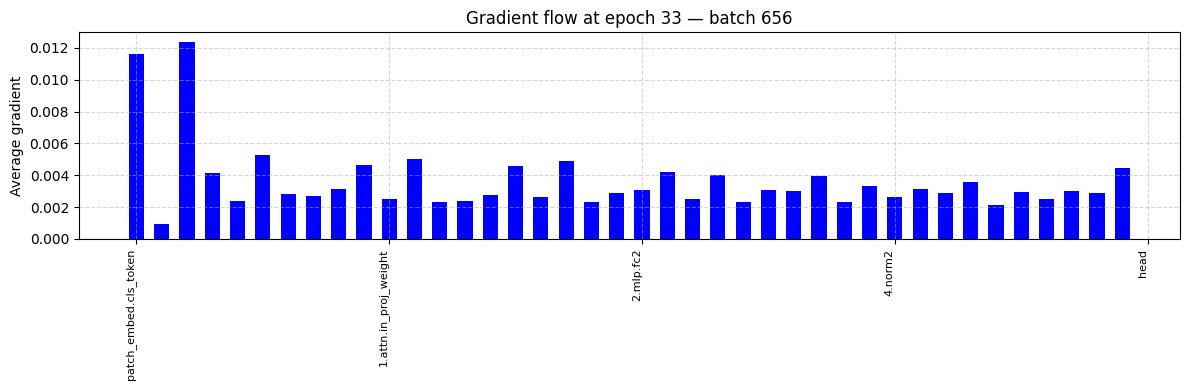


#################### [Train epoch 33]  || Loss 1898.825806  --> 1.899e+03  || Accuracy 0.4504-> (45.0405)%



Validation epoch 33:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 33]  || Loss 238.199372  --> 2.382e+02 || Accuracy 0.3241-> (32.4100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 34:   0%|          | 0/657 [00:00<?, ?it/s]

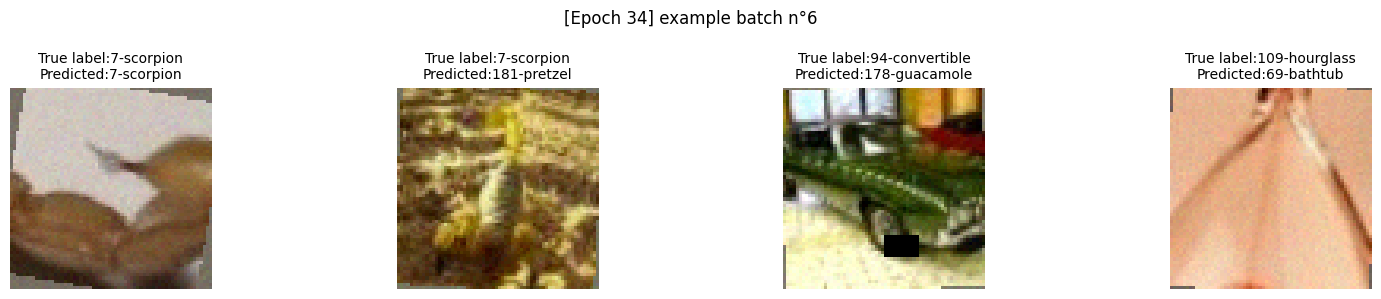

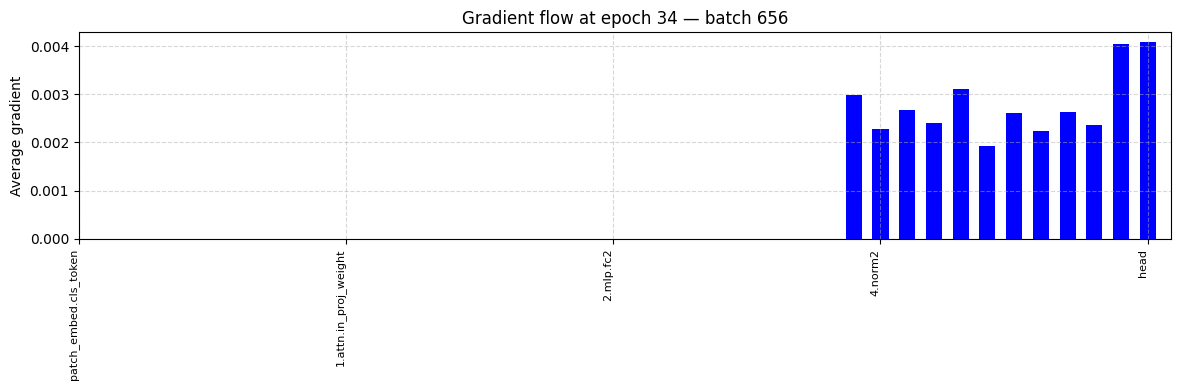


#################### [Train epoch 34]  || Loss 1881.495751  --> 1.881e+03  || Accuracy 0.4567-> (45.6702)%



Validation epoch 34:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 34]  || Loss 238.350296  --> 2.384e+02 || Accuracy 0.3239-> (32.3900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 35:   0%|          | 0/657 [00:00<?, ?it/s]

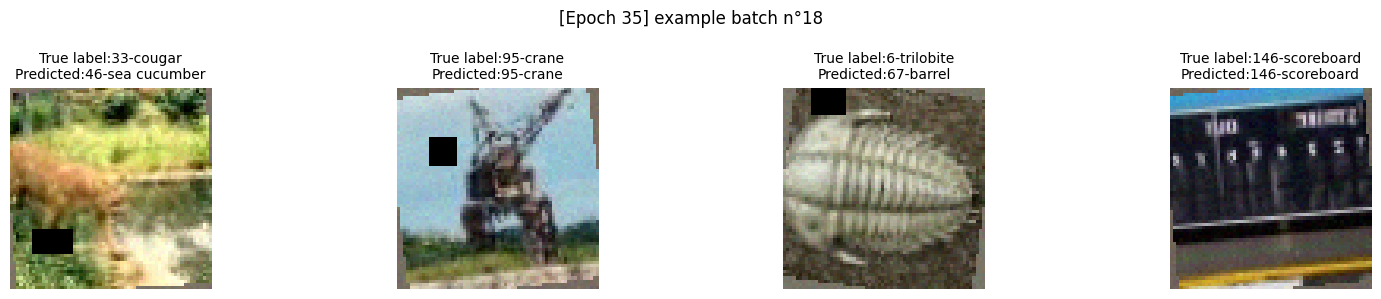

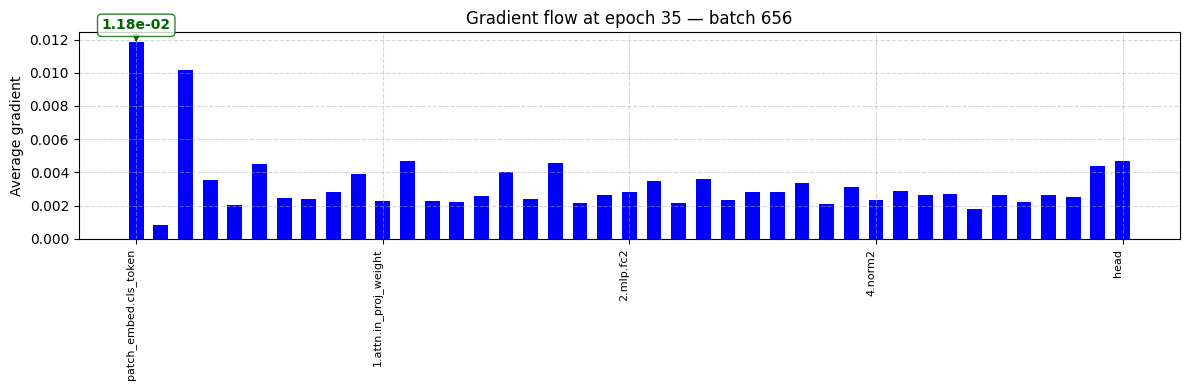


#################### [Train epoch 35]  || Loss 1862.674358  --> 1.863e+03  || Accuracy 0.4629-> (46.2893)%



Validation epoch 35:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 35]  || Loss 239.846633  --> 2.398e+02 || Accuracy 0.3211-> (32.1100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 36:   0%|          | 0/657 [00:00<?, ?it/s]

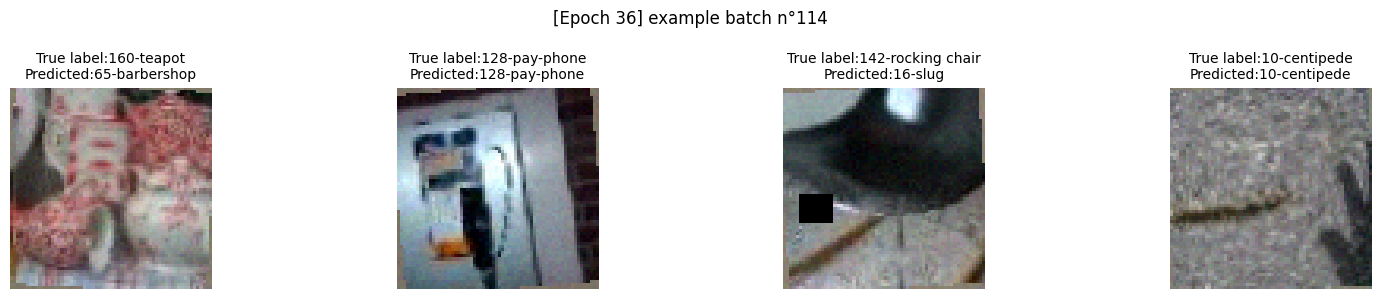

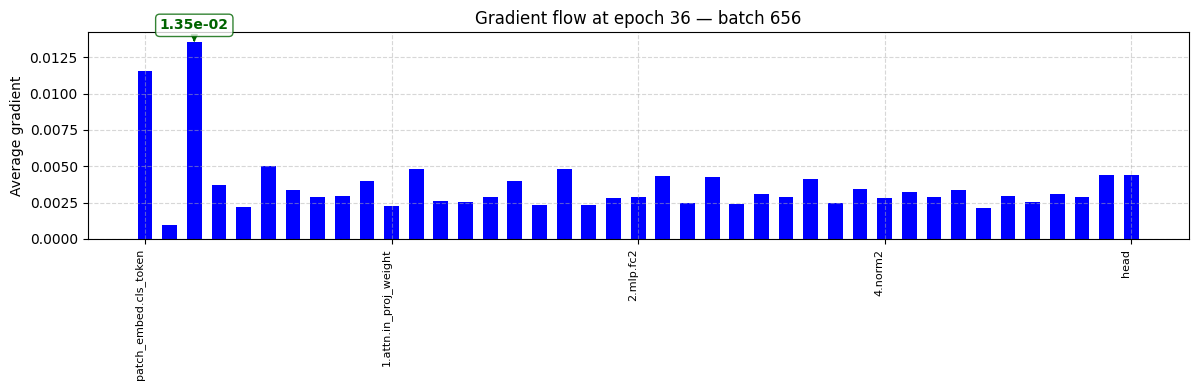


#################### [Train epoch 36]  || Loss 1871.221236  --> 1.871e+03  || Accuracy 0.4624-> (46.2429)%



Validation epoch 36:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 36]  || Loss 237.800201  --> 2.378e+02 || Accuracy 0.3255-> (32.5500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 37:   0%|          | 0/657 [00:00<?, ?it/s]

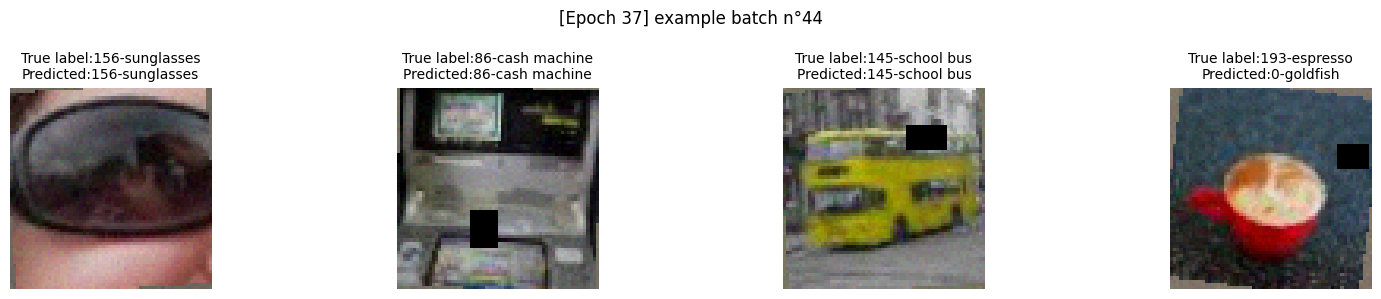

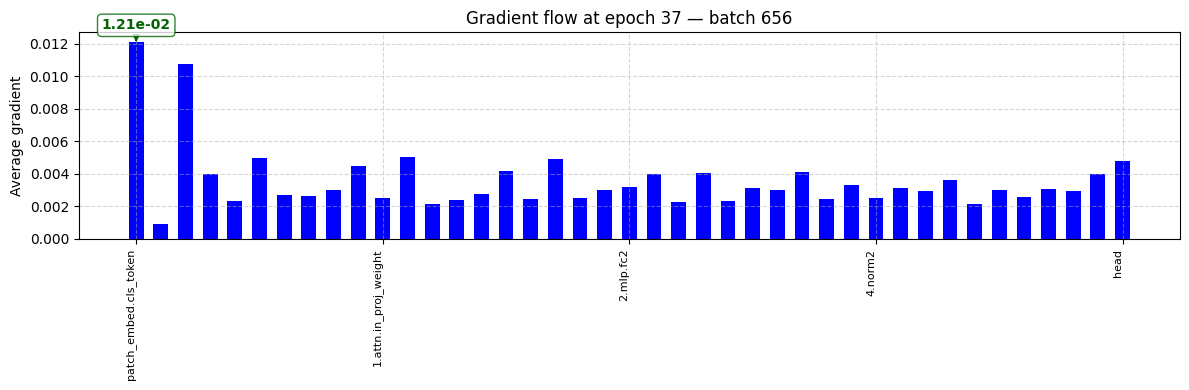


#################### [Train epoch 37]  || Loss 1845.683457  --> 1.846e+03  || Accuracy 0.4721-> (47.2119)%



Validation epoch 37:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 37]  || Loss 235.702518  --> 2.357e+02 || Accuracy 0.3295-> (32.9500)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 38:   0%|          | 0/657 [00:00<?, ?it/s]

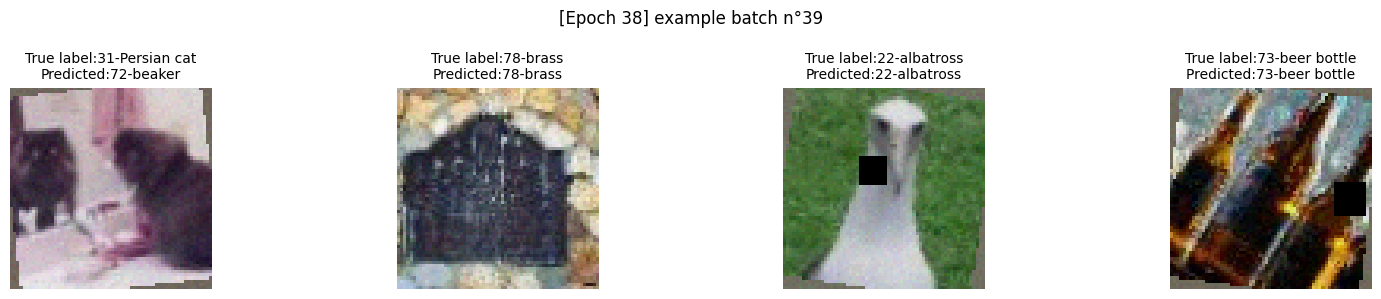

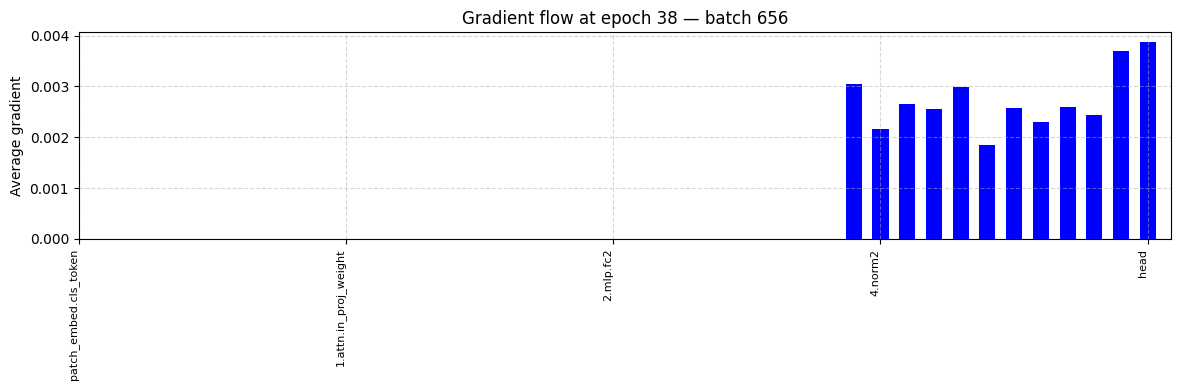


#################### [Train epoch 38]  || Loss 1836.945131  --> 1.837e+03  || Accuracy 0.4736-> (47.3560)%



Validation epoch 38:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 38]  || Loss 237.951375  --> 2.380e+02 || Accuracy 0.3240-> (32.4000)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 39:   0%|          | 0/657 [00:00<?, ?it/s]

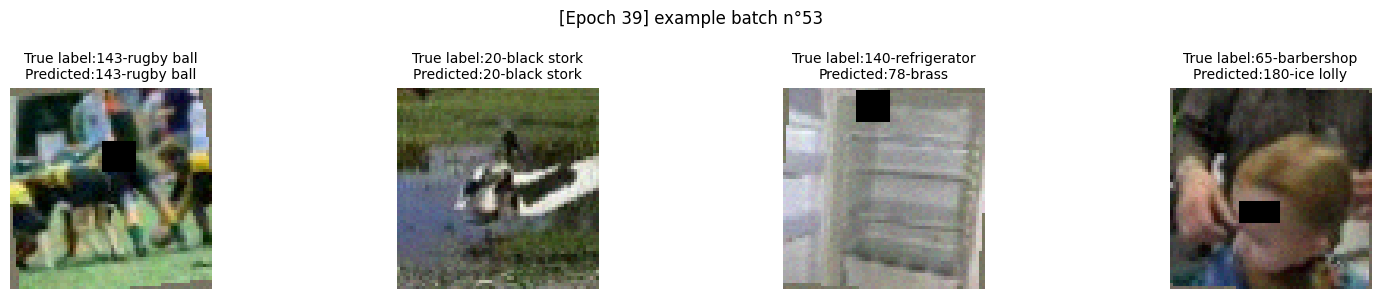

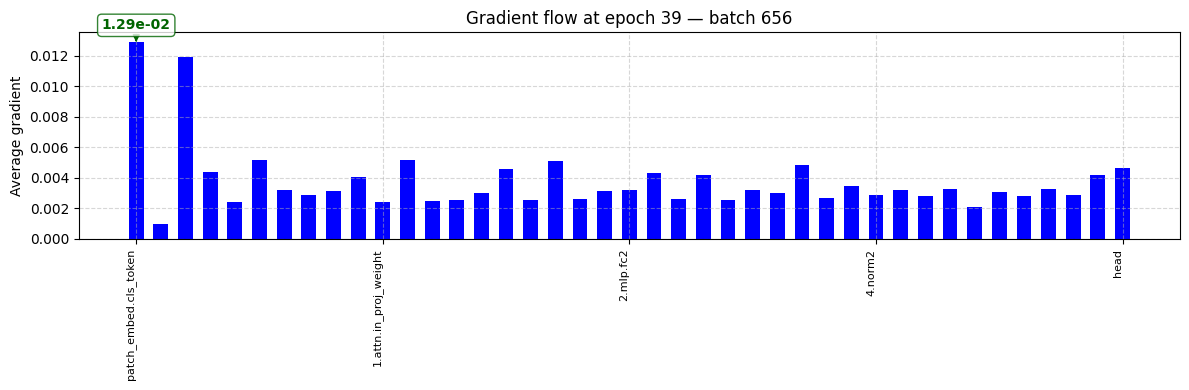


#################### [Train epoch 39]  || Loss 1816.208246  --> 1.816e+03  || Accuracy 0.4836-> (48.3619)%



Validation epoch 39:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 39]  || Loss 236.473724  --> 2.365e+02 || Accuracy 0.3269-> (32.6900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 40:   0%|          | 0/657 [00:00<?, ?it/s]

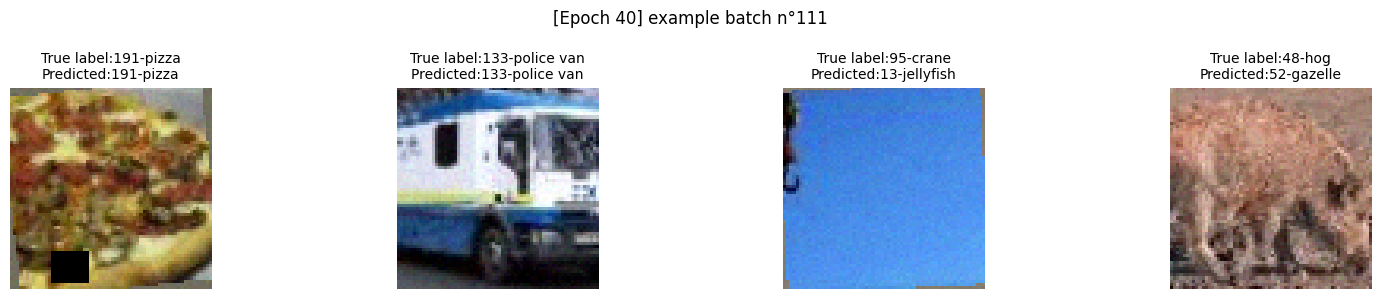

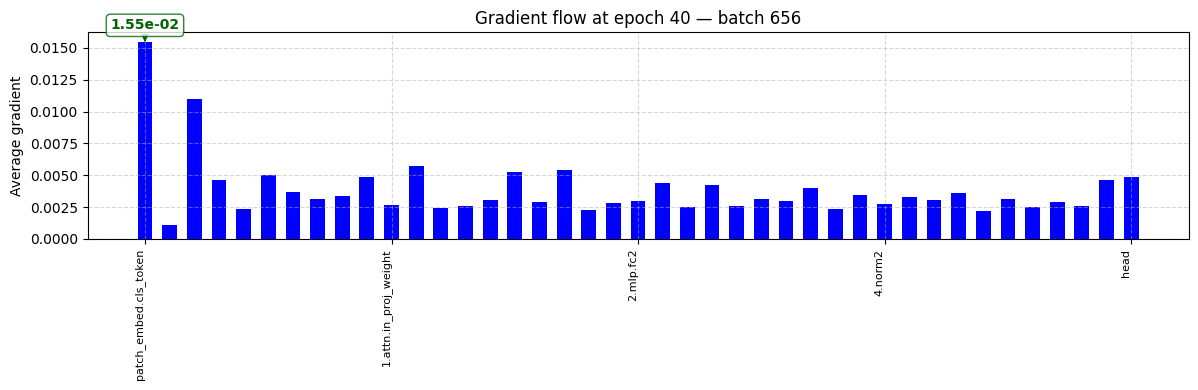


#################### [Train epoch 40]  || Loss 1835.017963  --> 1.835e+03  || Accuracy 0.4811-> (48.1131)%



Validation epoch 40:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 40]  || Loss 236.677308  --> 2.367e+02 || Accuracy 0.3292-> (32.9200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 41:   0%|          | 0/657 [00:00<?, ?it/s]

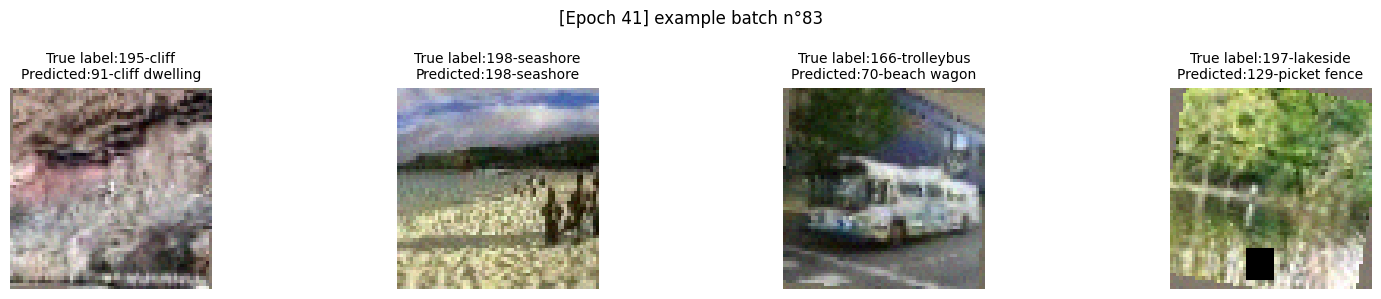

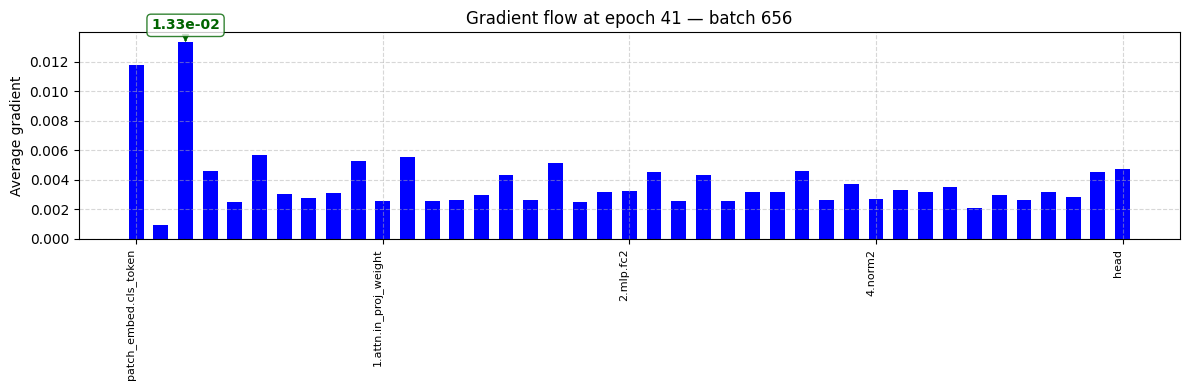


#################### [Train epoch 41]  || Loss 1808.856070  --> 1.809e+03  || Accuracy 0.4862-> (48.6179)%



Validation epoch 41:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 41]  || Loss 236.533839  --> 2.365e+02 || Accuracy 0.3292-> (32.9200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 42:   0%|          | 0/657 [00:00<?, ?it/s]

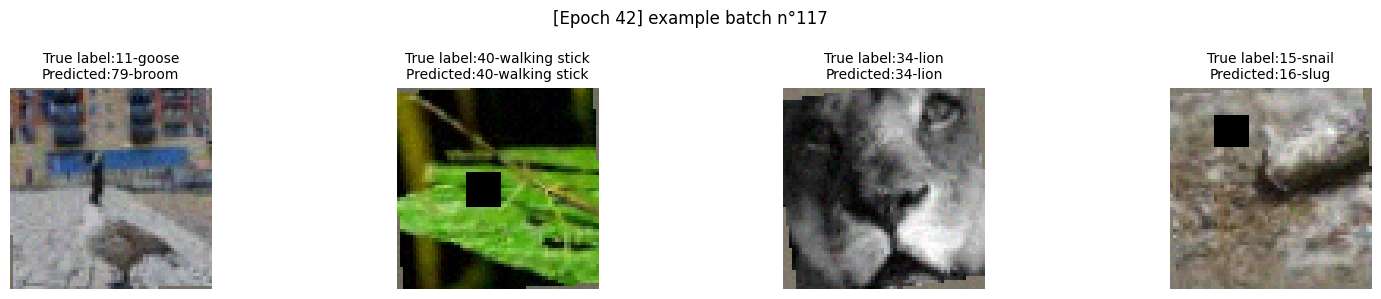

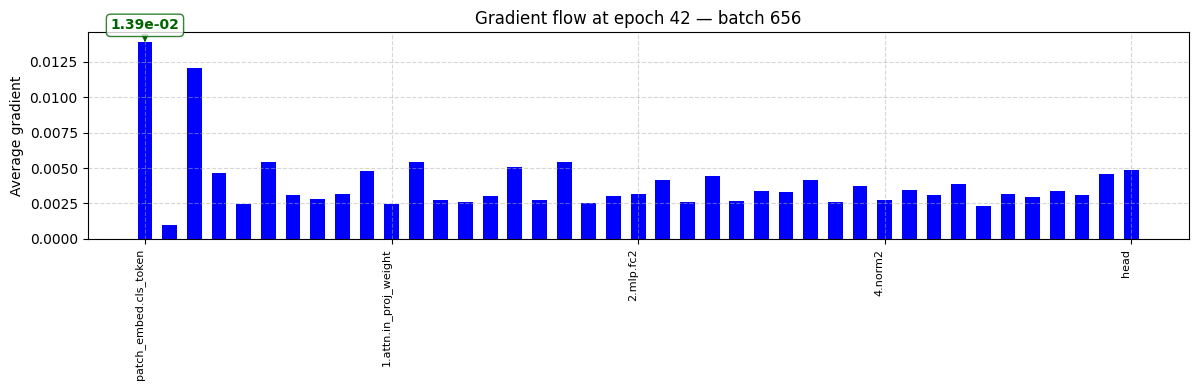


#################### [Train epoch 42]  || Loss 1829.697641  --> 1.830e+03  || Accuracy 0.4838-> (48.3810)%



Validation epoch 42:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 42]  || Loss 237.471678  --> 2.375e+02 || Accuracy 0.3282-> (32.8200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 43:   0%|          | 0/657 [00:00<?, ?it/s]

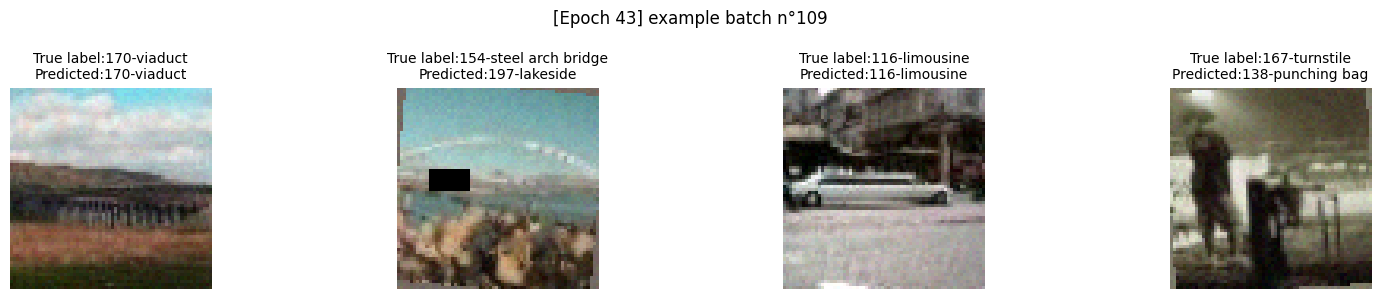

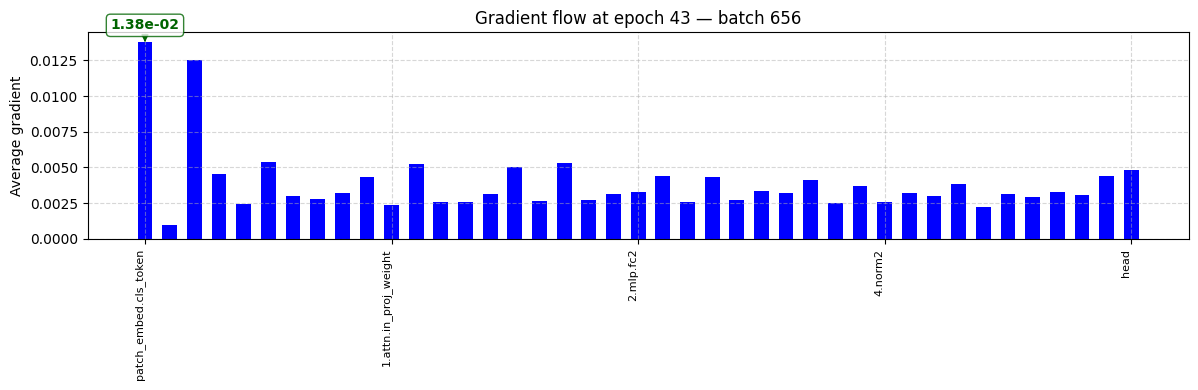


#################### [Train epoch 43]  || Loss 1805.112166  --> 1.805e+03  || Accuracy 0.4916-> (49.1571)%



Validation epoch 43:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 43]  || Loss 237.184138  --> 2.372e+02 || Accuracy 0.3298-> (32.9800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 44:   0%|          | 0/657 [00:00<?, ?it/s]

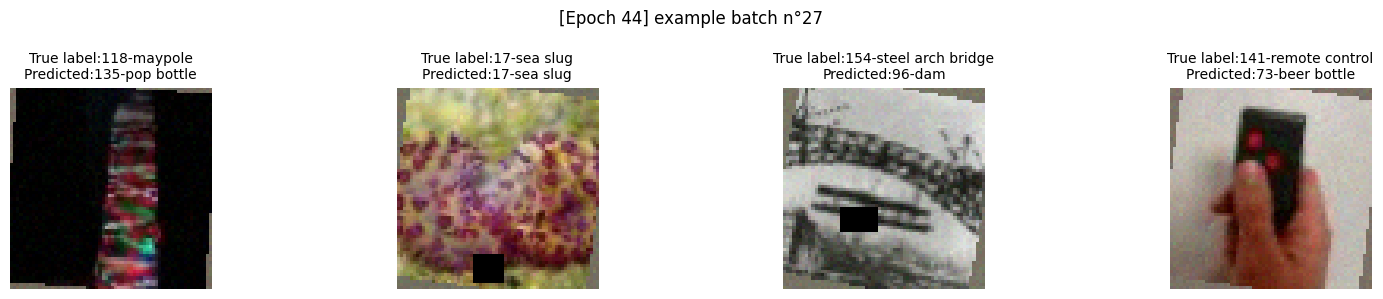

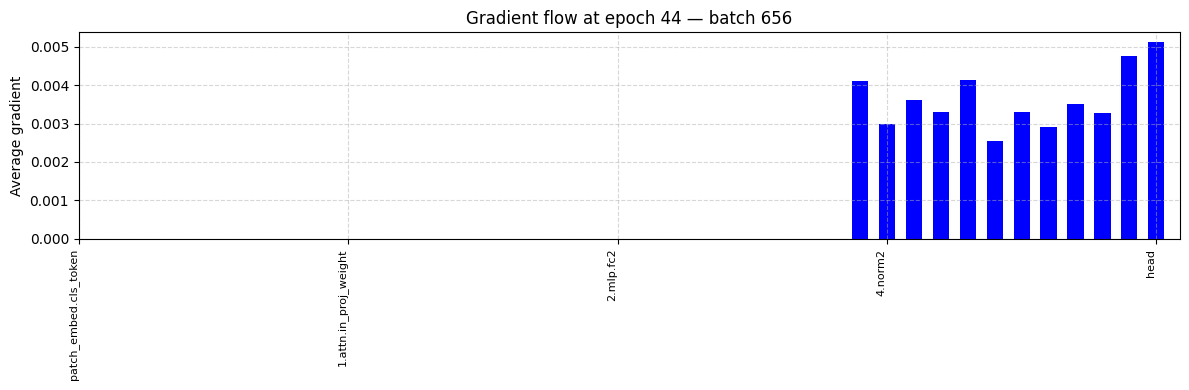


#################### [Train epoch 44]  || Loss 1773.193912  --> 1.773e+03  || Accuracy 0.4991-> (49.9060)%



Validation epoch 44:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 44]  || Loss 236.685396  --> 2.367e+02 || Accuracy 0.3291-> (32.9100)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 45:   0%|          | 0/657 [00:00<?, ?it/s]

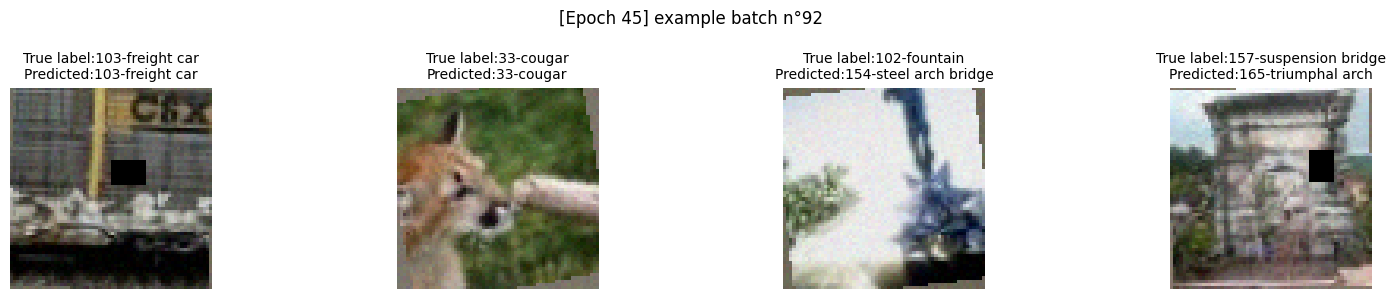

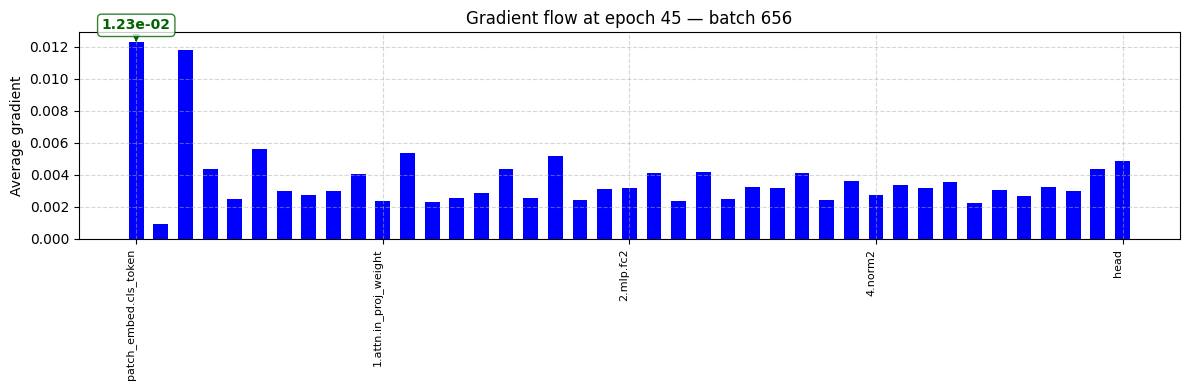


#################### [Train epoch 45]  || Loss 1778.441214  --> 1.778e+03  || Accuracy 0.4985-> (49.8476)%



Validation epoch 45:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 45]  || Loss 237.441416  --> 2.374e+02 || Accuracy 0.3274-> (32.7400)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 46:   0%|          | 0/657 [00:00<?, ?it/s]

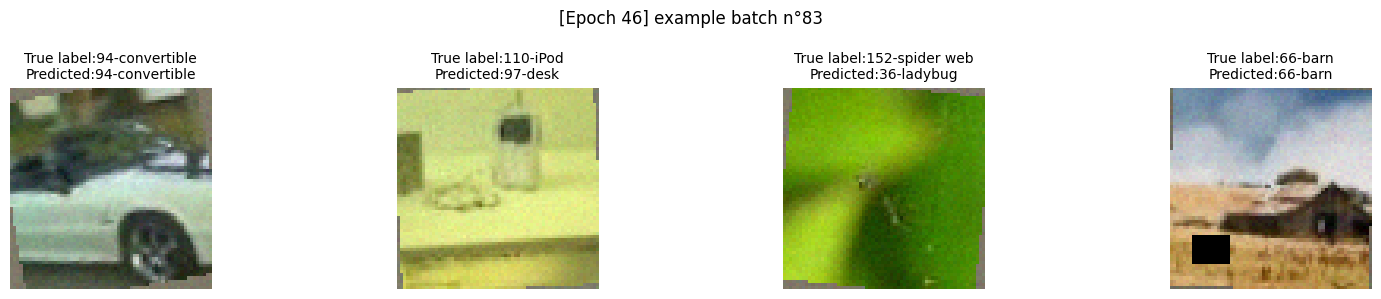

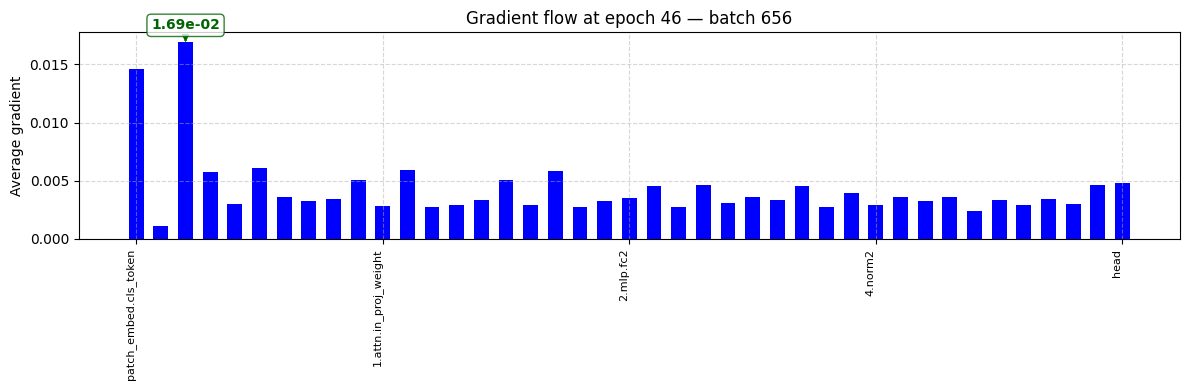


#################### [Train epoch 46]  || Loss 1791.738629  --> 1.792e+03  || Accuracy 0.4985-> (49.8524)%



Validation epoch 46:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 46]  || Loss 237.195162  --> 2.372e+02 || Accuracy 0.3294-> (32.9400)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 47:   0%|          | 0/657 [00:00<?, ?it/s]

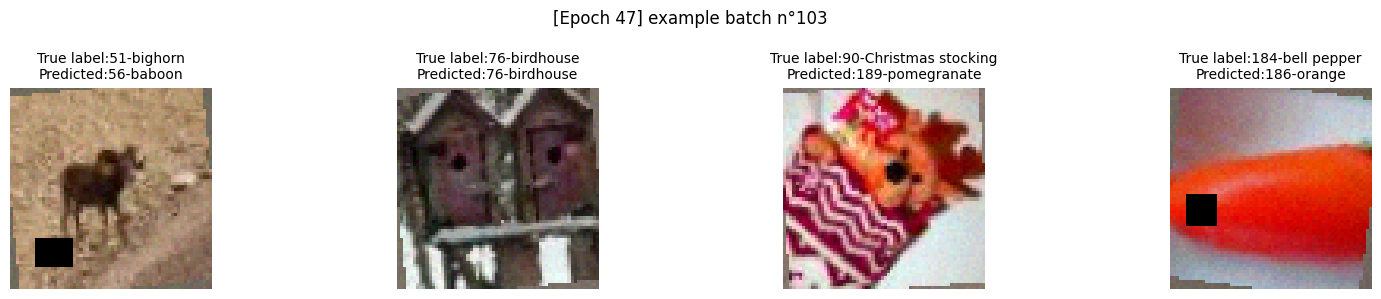

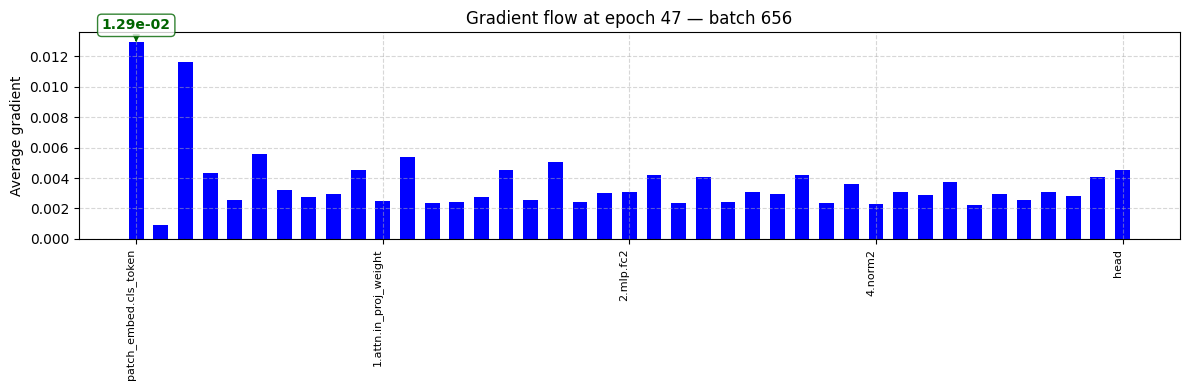


#################### [Train epoch 47]  || Loss 1762.220650  --> 1.762e+03  || Accuracy 0.5045-> (50.4488)%



Validation epoch 47:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 47]  || Loss 238.081850  --> 2.381e+02 || Accuracy 0.3292-> (32.9200)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 48:   0%|          | 0/657 [00:00<?, ?it/s]

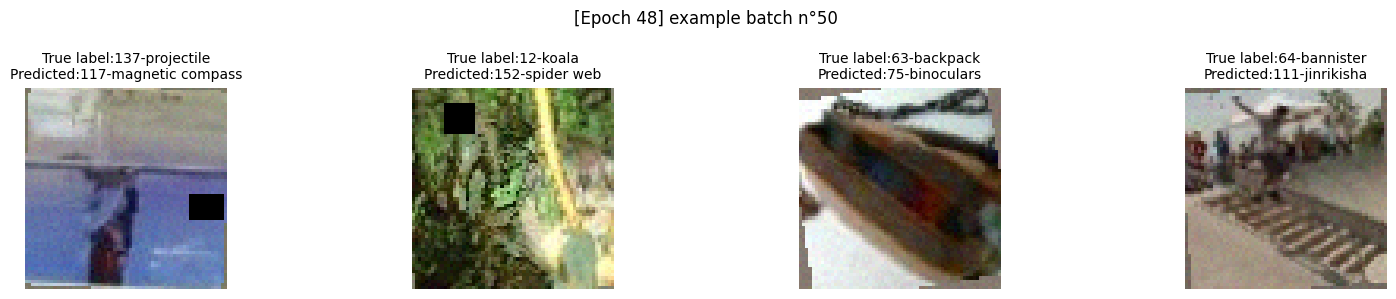

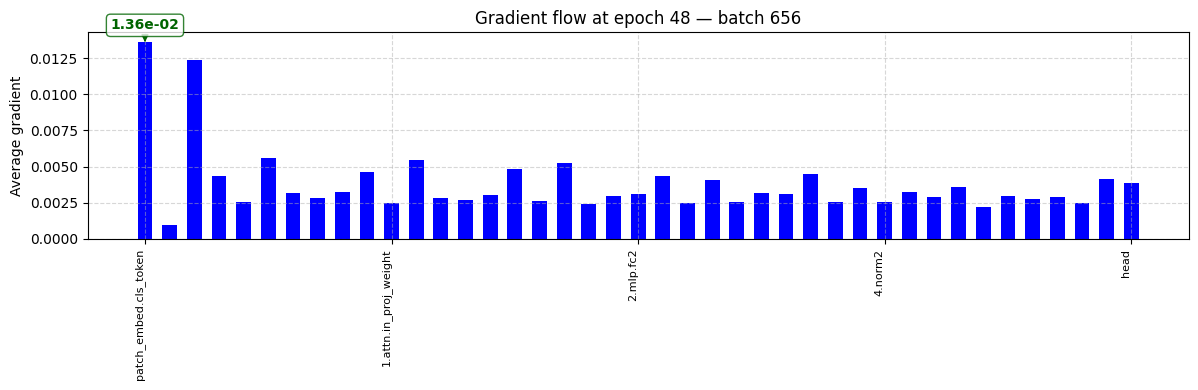


#################### [Train epoch 48]  || Loss 1774.239086  --> 1.774e+03  || Accuracy 0.4999-> (49.9929)%



Validation epoch 48:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 48]  || Loss 237.080263  --> 2.371e+02 || Accuracy 0.3299-> (32.9900)%

Saving model..on Pietro pc
Model Saved in Pietro pc!


Training epoch 49:   0%|          | 0/657 [00:00<?, ?it/s]

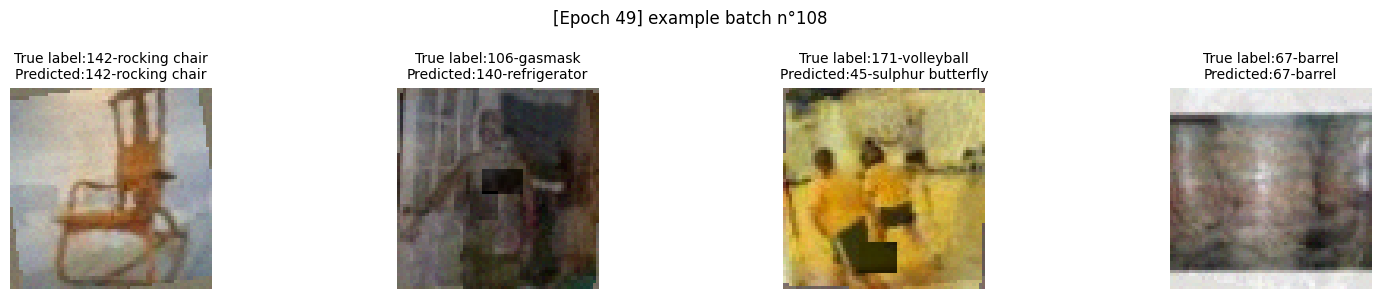

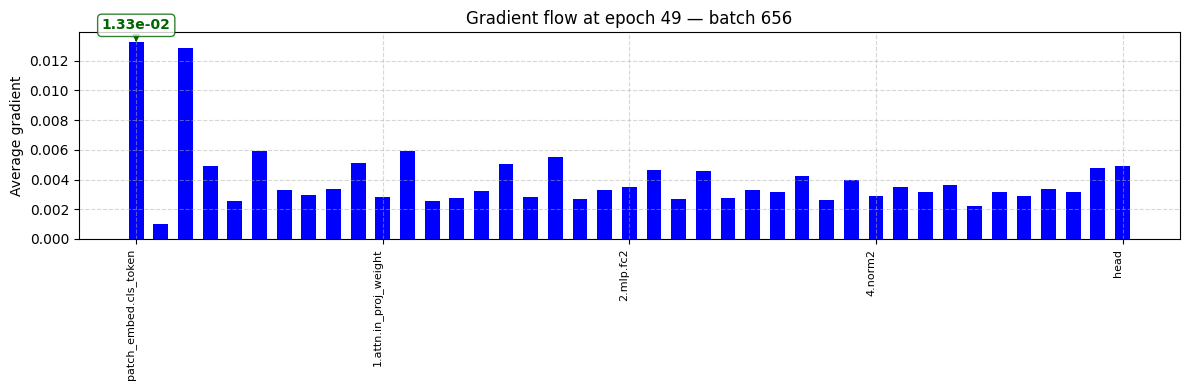


#################### [Train epoch 49]  || Loss 1790.994096  --> 1.791e+03  || Accuracy 0.4936-> (49.3631)%



Validation epoch 49:   0%|          | 0/79 [00:00<?, ?it/s]


#################### [Val epoch 49]  || Loss 237.367901  --> 2.374e+02 || Accuracy 0.3298-> (32.9800)%

Saving model..on Pietro pc
Model Saved in Pietro pc!
++++++++++Best epoch was 48 ++++++++++++++++++++

++++++++++Best val accuracy was 32.9900% ++++++++++++++++++++

++++++++++Best train accuracy was 50.4488% ++++++++++++++++++++

++++++++++Training time: 355.001513504982 min ++++++++++++++++++++



In [ ]:
## messo model_test per prova
model1 = model_test.to(device)

loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]
best_val_acc=0.0
best_epoch=0
best_train_acc=0.0


start_time = time.time()

version=8

pth_model = 'model'+str(version)+'_epochs'+str(num_epochs)+'.pth'
pth_optimizer='optimizer'+str(version)+'_epochs'+str(num_epochs)+'.pth'



for epoch in  range(num_epochs):

  train(model1, train_loader, optimizer, loss_train, epoch, loss_train_list, acc_train_list, debug_mode=False)
  validate(model1, validation_loader, loss_val_list, optimizer, loss_val, epoch, acc_val_list, debug_mode=False)
  scheduler.step()


  if(best_val_acc<acc_val_list[epoch]):
        ##print("Saving validation accuracy...\n")
        best_val_acc=acc_val_list[epoch]
        best_epoch=epoch
  if(best_train_acc<acc_train_list[epoch]):
        ##print("Saving training accuracy...\n")
        best_train_acc=acc_train_list[epoch]

  if device_name in device_list:
    print("Saving model..on Pietro pc")
    pth_checkpoint = 'model'+str(version)+'_epochs'+str(epoch)+'.pth'
    torch.save(model1.state_dict(), path_saves_pc_pi+pth_model)
    pth_optimizer_checkpoint='optimizer'+str(version)+'_epochs'+str(epoch)+'.pth'
    torch.save(optimizer.state_dict(), path_saves_pc_pi+pth_optimizer_checkpoint)
    print("Model Saved in Pietro pc!")



  '''
  <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
  <3<3<3<3<3<3
  <3<3<3<3<3<3<3<3 LY <3<3<3<3<3<3<3<3
  '''

end_time=time.time()
minutes=end_time-start_time/60.00
hours=minutes/60.00
print(RED+f"++++++++++Best epoch was {best_epoch} ++++++++++++++++++++\n")
print(RED+f"++++++++++Best val accuracy was {best_val_acc*100.0:.4f}% ++++++++++++++++++++\n")
print(RED+f"++++++++++Best train accuracy was {best_train_acc*100.0:.4f}% ++++++++++++++++++++\n")
print(RED+f"++++++++++Training time: {minutes} min  -> {hours }hours ++++++++++++++++++++\n")

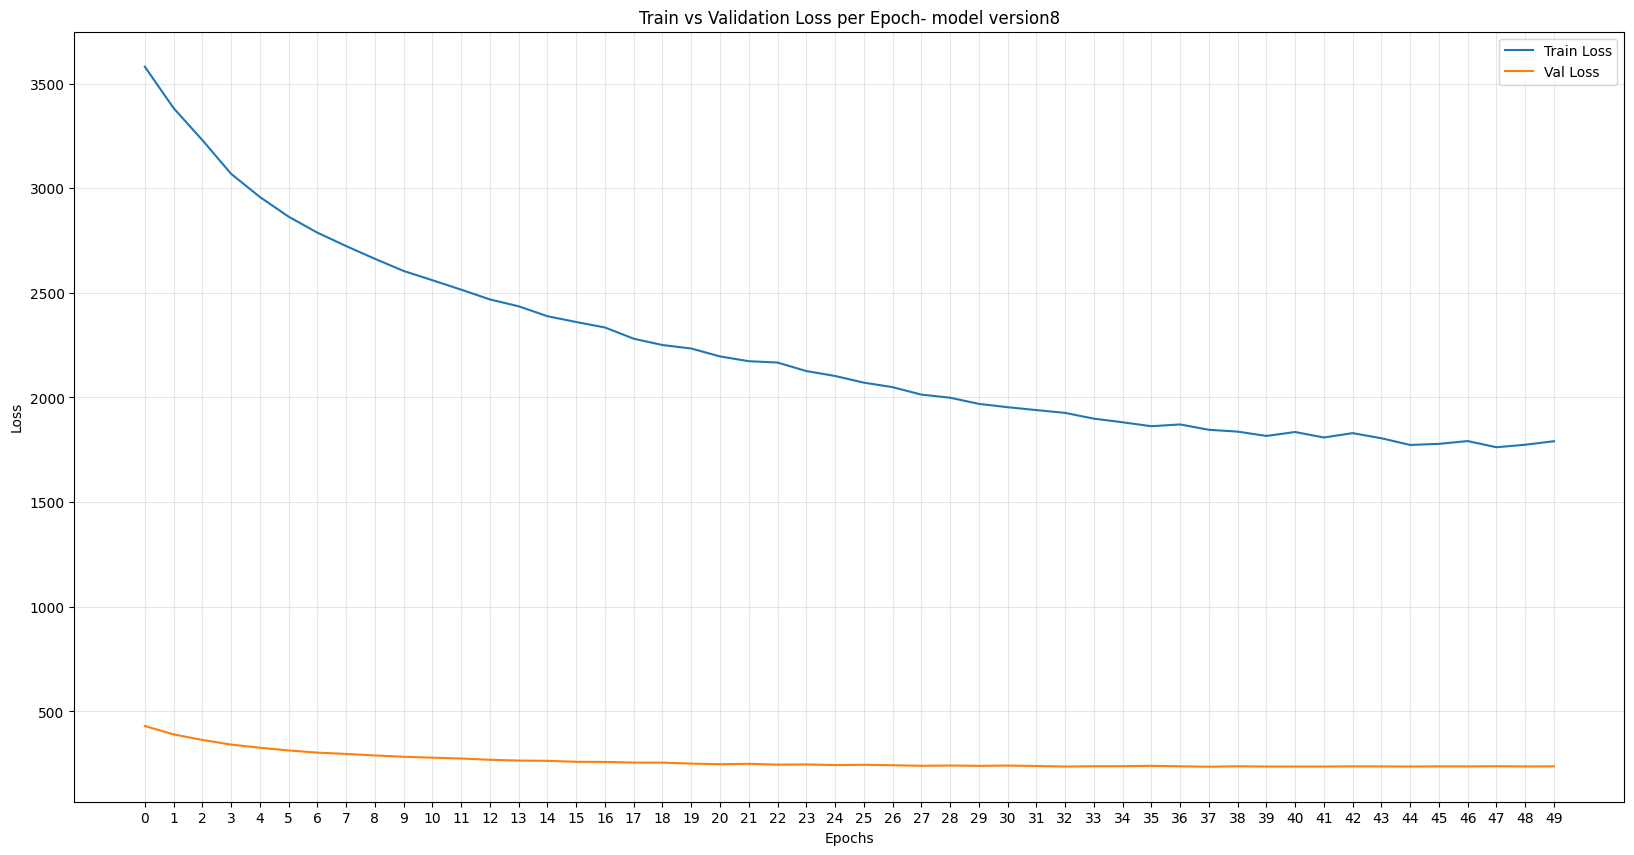

In [ ]:
list_epochs = list(range(len(loss_train_list)))

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(loss_train_list, label="Train Loss")
ax.plot(loss_val_list,   label="Val Loss")

ax.set_title(f"Train vs Validation Loss per Epoch – model version {version}")
ax.legend(loc="upper right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

ax.set_xticks(list_epochs)

# imposta un tick ogni 100 unità sulla y
ax.yaxis.set_major_locator(mtick.MultipleLocator(100))

ax.grid(linestyle='-', alpha=0.3)
plt.show()


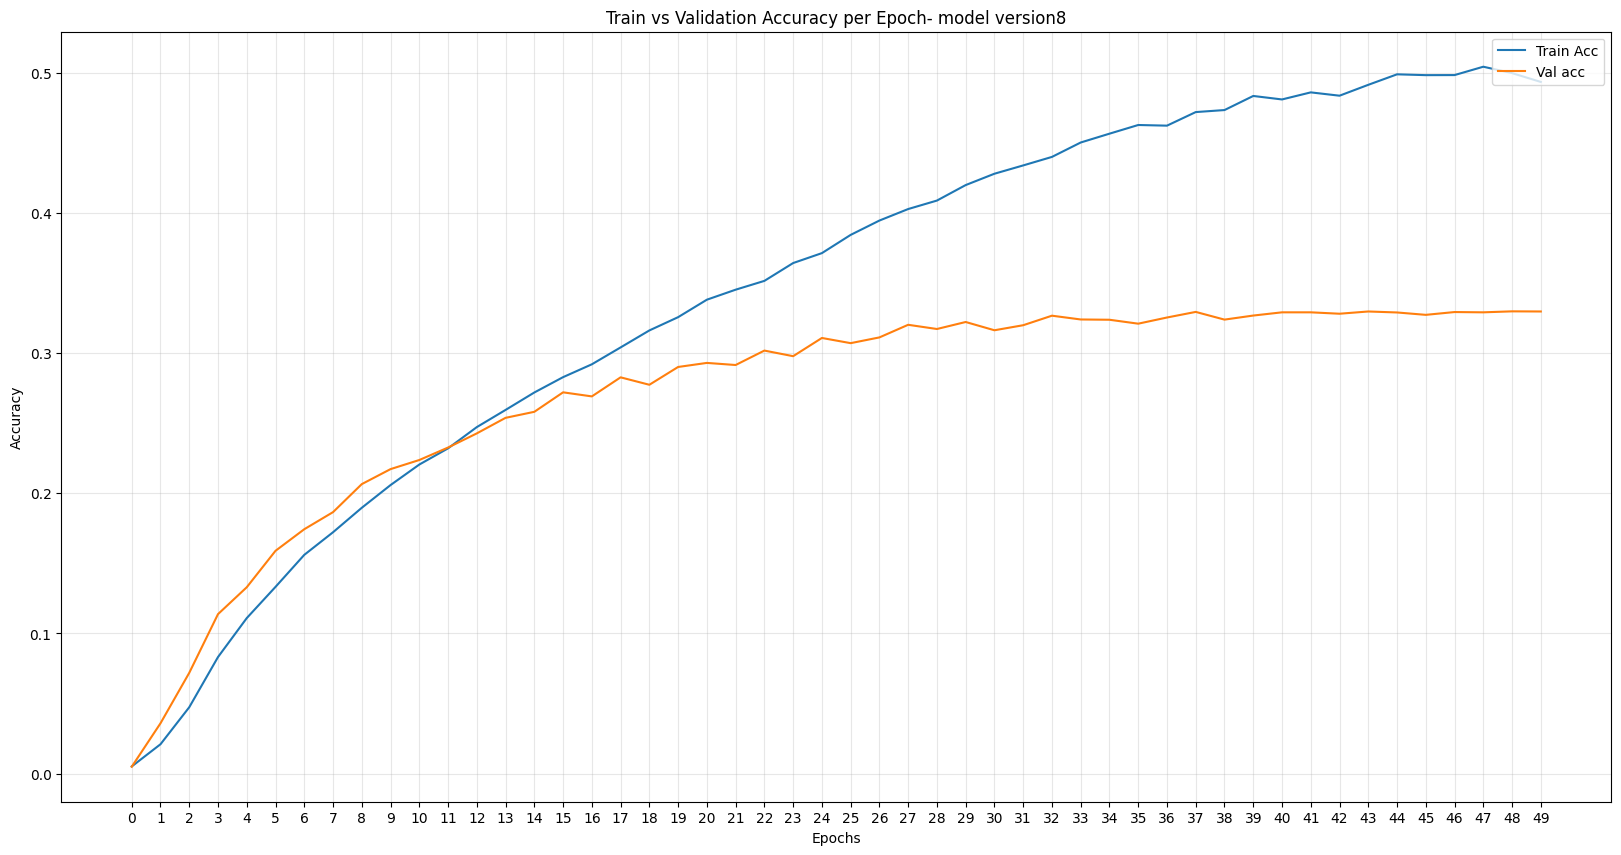

In [ ]:
list_epochs = list(range(len(acc_val_list)))

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(acc_train_list, label="Train Acc")
ax.plot(acc_val_list,   label="Val Acc")

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

ax.set_title(f"Train vs Validation Accuracy per Epoch – model version {version}")
ax.legend(loc="upper right")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

ax.set_xticks(list_epochs)
ax.grid(linestyle='-', alpha=0.3)

plt.show()


In [ ]:
print(loss_train_list)
print(loss_val_list)

[3580.4624757766724, 3382.5945410728455, 3229.663857936859, 3068.6008219718933, 2958.026810646057, 2863.8663568496704, 2787.5624947547913, 2723.458498477936, 2662.560042619705, 2604.5751917362213, 2560.2868087291718, 2515.131937980652, 2468.4790613651276, 2435.6407058238983, 2388.3281977176666, 2360.5817098617554, 2334.4931864738464, 2280.8075299263, 2250.652191400528, 2234.001821041107, 2196.264952659607, 2173.2992095947266, 2167.004613161087, 2126.30832862854, 2102.8533847332, 2070.976171731949, 2049.403219938278, 2013.8452427387238, 1998.981787443161, 1969.5471889972687, 1953.5866656303406, 1939.7866246700287, 1926.4624903202057, 1898.8258061408997, 1881.4957513809204, 1862.6743578910828, 1871.2212362289429, 1845.683456659317, 1836.9451305866241, 1816.2082455158234, 1835.0179634094238, 1808.856070280075, 1829.697641134262, 1805.112165927887, 1773.193912267685, 1778.4412143230438, 1791.7386286258698, 1762.220650434494, 1774.2390859127045, 1790.9940955638885]
[430.0847463607788, 390.1

###Saving current model

In [ ]:
if device_name not in device_list:
  print(f"Saving model {pth_model} ..on drive")
  torch.save(model1.state_dict(),directory_saved_models_drive+pth_model)
  torch.save(optimizer.state_dict(), directory_saved_optimizers_drive+pth_optimizer)
  print("Model saved..on drive")


else:
  !pwd && ls -la
  if device_name in device_list:
    print("Saving model..on Pietro pc")
    torch.save(model1.state_dict(), path_saves_pc_pi+pth_model)
    torch.save(optimizer.state_dict(), path_saves_pc_pi+pth_optimizer)
    print("Model Saved in Pietro pc!")





/content
total 16
drwxr-xr-x 1 root root 4096 Jun  3 14:04 .
drwxr-xr-x 1 root root 4096 Jul  8 11:07 ..
drwxr-xr-x 4 root root 4096 Jun  3 14:04 .config
drwxr-xr-x 1 root root 4096 Jun  3 14:04 sample_data
Saving model..on Pietro pc
Model Saved in Pietro pc!


### Need to restore a model?

In [ ]:
print("\nLoading a previous model...\n")
model_downloaded = model_test.to(device)


# 3) Ricrea l’optimizer con gli stessi iperparametri
optimizer_downloaded =  torch.optim.AdamW(
    model_test.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999)
)

if(not Pi_gpu):

  model_ckpt_path = directory_saved_models_drive+pth_model
  opt_ckpt_path   = directory_saved_optimizers_drive+pth_optimizer

else:
  model_ckpt_path = path_saves_pc_pi+pth_model
  opt_ckpt_path   = path_saves_pc_pi+pth_optimizer


model_sd = torch.load(model_ckpt_path, map_location=device)
model_downloaded.load_state_dict(model_sd)
opt_sd = torch.load(opt_ckpt_path, map_location=device)
optimizer_downloaded.load_state_dict(opt_sd)


#Test Phase

## Test fuction

In [ ]:
def test(model,test_loader,criterion,debug_mode=False):

    model.eval()
    test_loss = 0.0


    predic_labels= []
    true_labels = []
    pbar = tqdm(test_loader, desc=f"Testing the model...",colour='red')

    all_outputs = []
    all_targets = []

    #no gradient computazion
    with torch.no_grad():
      i=0
      for batch in pbar:

        inputs = batch['image']
        targets = batch['label']

        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)

        loss = criterion(output, targets)
        test_loss += loss.item()
        '''

        copia_output=output.cpu().detach().numpy()
        copia_target=targets.cpu().detach().numpy()
        all_outputs.append(copia_output)
        all_targets.append(copia_target)

        '''

        _,predicted=torch.max(output, dim=1)
        predic_labels.extend(predicted.cpu().tolist())
        true_labels.extend(targets.cpu().tolist())



        i+=1

    # Stack outputs and target into a single array
    #all_outputs = np.vstack(all_outputs)
    #all_targets = np.vstack(all_targets)


    accuracy=accuracy_score(true_labels, predic_labels)

    print(GREEN+f'[Test] Loss : {test_loss:.6f}  --> {test_loss:.3e} || Accuracy {accuracy:.4f}-> ({accuracy*100.0:.4f})%\n'+RESET)

    return predic_labels,true_labels

In [ ]:
predictions, targets=test(model=model_test,test_loader=test_loader,criterion=loss_val,debug_mode=True)

Testing the model...:   0%|          | 0/125 [00:00<?, ?it/s]

[Test] Loss : 375.577073  --> 3.756e+02 || Accuracy 0.3371-> (33.7062)%



In [ ]:
# Confusion matrix
cm = confusion_matrix(targets, predictions, labels=np.arange(200))

# visualizing results
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(200))
#disp.plot()
#plt.title("Confusion Matrix")
#plt.show()



df = pd.DataFrame(cm)
fig = px.imshow(df,
                labels=dict(x="Pred", y="True", color="Count"),
                width=800, height=800,
                color_continuous_scale='Blues')
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [ ]:


# togli diagonale e “appiattisci”
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)
flat = cm_no_diag.flatten()
inds = np.argsort(flat)[-20:]  # ultime 20
print("le 20 classe con più confusione")
pairs = [(ind // cm.shape[1], ind % cm.shape[1], flat[ind]) for ind in inds]
for true, pred, cnt in sorted(pairs, key=lambda x: -x[2]):
    print(f"True {true} → Pred {pred}: {cnt}")


le 20 classe con più confusione
True 61 → Pred 126: 17
True 86 → Pred 128: 12
True 153 → Pred 94: 11
True 14 → Pred 196: 11
True 77 → Pred 60: 11
True 70 → Pred 133: 10
True 104 → Pred 174: 10
True 70 → Pred 94: 10
True 85 → Pred 134: 10
True 73 → Pred 135: 10
True 167 → Pred 128: 9
True 82 → Pred 93: 9
True 155 → Pred 117: 9
True 153 → Pred 70: 9
True 42 → Pred 40: 9
True 187 → Pred 186: 9
True 177 → Pred 178: 9
True 196 → Pred 14: 9
True 182 → Pred 190: 9
True 94 → Pred 70: 9


In [ ]:
correct_counts = np.diag(cm)

# Se vuoi solo le top-20 per numero assoluto di corretti:
top_n = 20
inds_top_correct = np.argsort(correct_counts)[-top_n:][::-1]

print(f"Le {top_n} classi più corrette (in termini di conteggio):")
for cls in inds_top_correct:
    print(f" Classe {cls}: {correct_counts[cls]} predizioni corrette")


Le 20 classi più corrette (in termini di conteggio):
 Classe 44: 61 predizioni corrette
 Classe 143: 60 predizioni corrette
 Classe 103: 58 predizioni corrette
 Classe 191: 56 predizioni corrette
 Classe 45: 56 predizioni corrette
 Classe 22: 55 predizioni corrette
 Classe 166: 55 predizioni corrette
 Classe 173: 54 predizioni corrette
 Classe 115: 54 predizioni corrette
 Classe 13: 54 predizioni corrette
 Classe 176: 52 predizioni corrette
 Classe 1: 52 predizioni corrette
 Classe 78: 50 predizioni corrette
 Classe 23: 50 predizioni corrette
 Classe 68: 50 predizioni corrette
 Classe 118: 49 predizioni corrette
 Classe 60: 49 predizioni corrette
 Classe 145: 49 predizioni corrette
 Classe 81: 48 predizioni corrette
 Classe 58: 47 predizioni corrette


#Computational Graph Pi

opcode         name                     target                                                  args                                                     kwargs
-------------  -----------------------  ------------------------------------------------------  -------------------------------------------------------  ----------
placeholder    x                        x                                                       ()                                                       {}
call_method    size                     size                                                    (x, 0)                                                   {}
call_module    patch_embed_proj         patch_embed.proj                                        (x,)                                                     {}
call_method    flatten                  flatten                                                 (patch_embed_proj, 2)                                    {}
call_method    transpose                transpose   

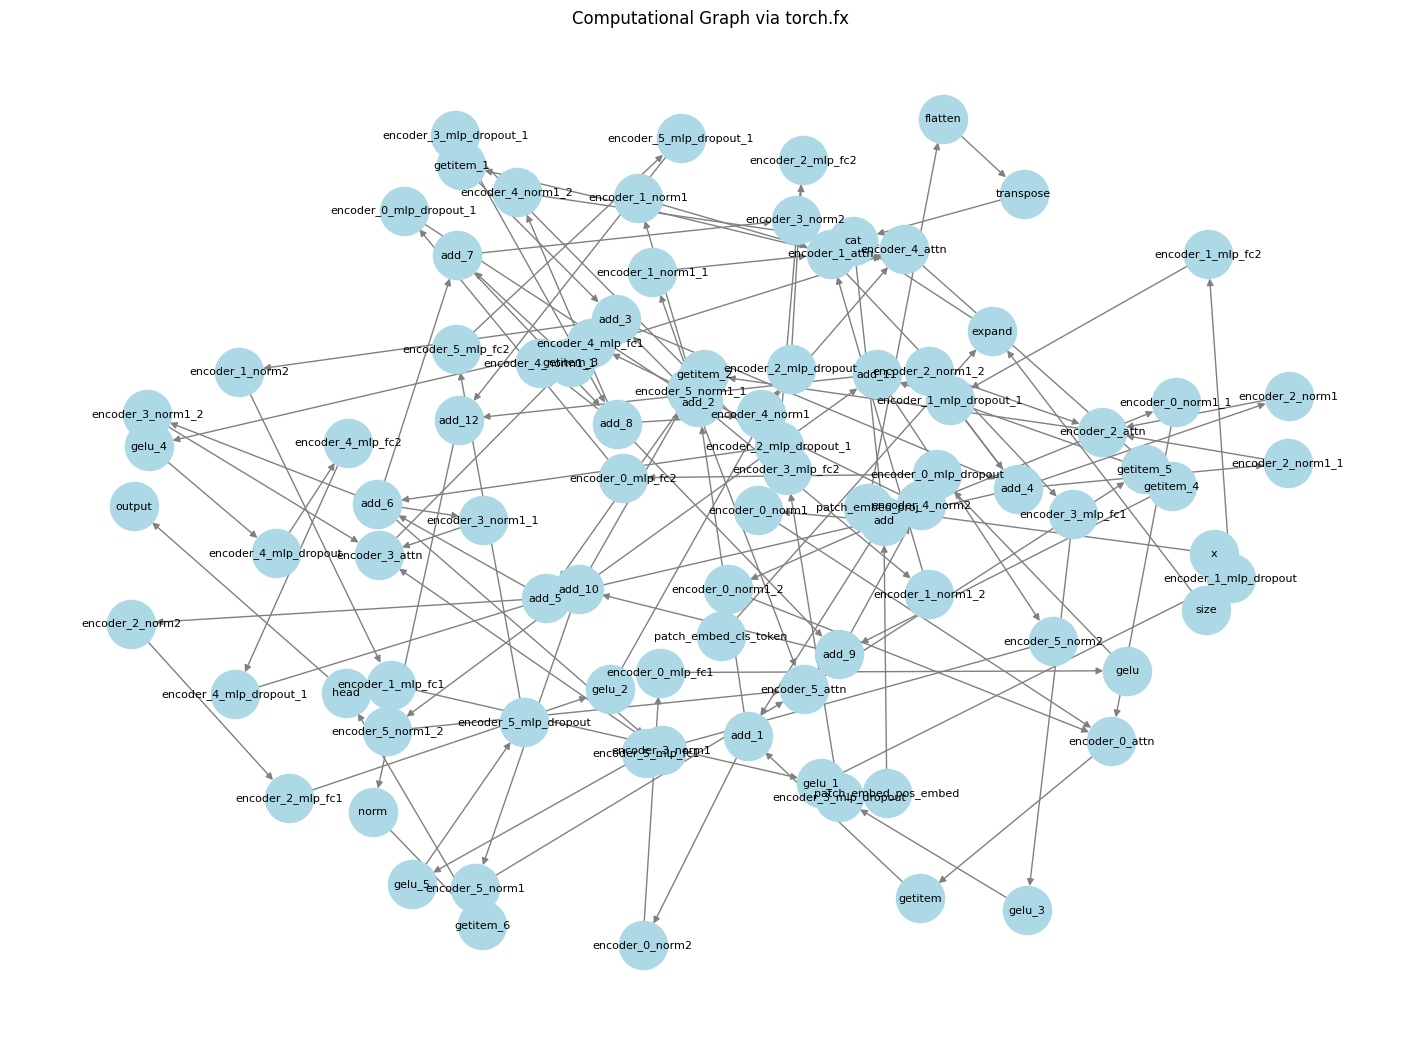

In [ ]:
model_fx = model_test.cpu()
# Input di esempio (es. batch size 1, 3 canali, 64x64 immagini)
example_input = torch.randn(1, 3, 64, 64)
# Traccia il grafo computazionale
traced = symbolic_trace(model_fx)
traced.graph.print_tabular()

def fx_to_nx_graph(graph_module):
    g = nx.DiGraph()
    for node in graph_module.graph.nodes:
        g.add_node(node.name, label=str(node))
        for user in node.users:
            g.add_edge(node.name, user.name)
    return g

g = fx_to_nx_graph(traced)

# Disegna
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(g, k=0.5)
nx.draw(g, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=1200, font_size=8)
plt.title("Computational Graph via torch.fx")
plt.show()

  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.14-cp311-cp311-linux_x86_64.whl size=169719 sha256=9cfe43bf21e82c26ca66e8ea0e48964e84280fd064de8b11d416a6aa9826cf43
  Stored in directory: /root/.cache/pip/wheels/9c/5f/df/6fffd2a4353f26dbb0e3672a1baf070c124a1d74a5f9318279
Successfully built pygraphviz


<ipython-input-62-3cdc65303480>:52: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



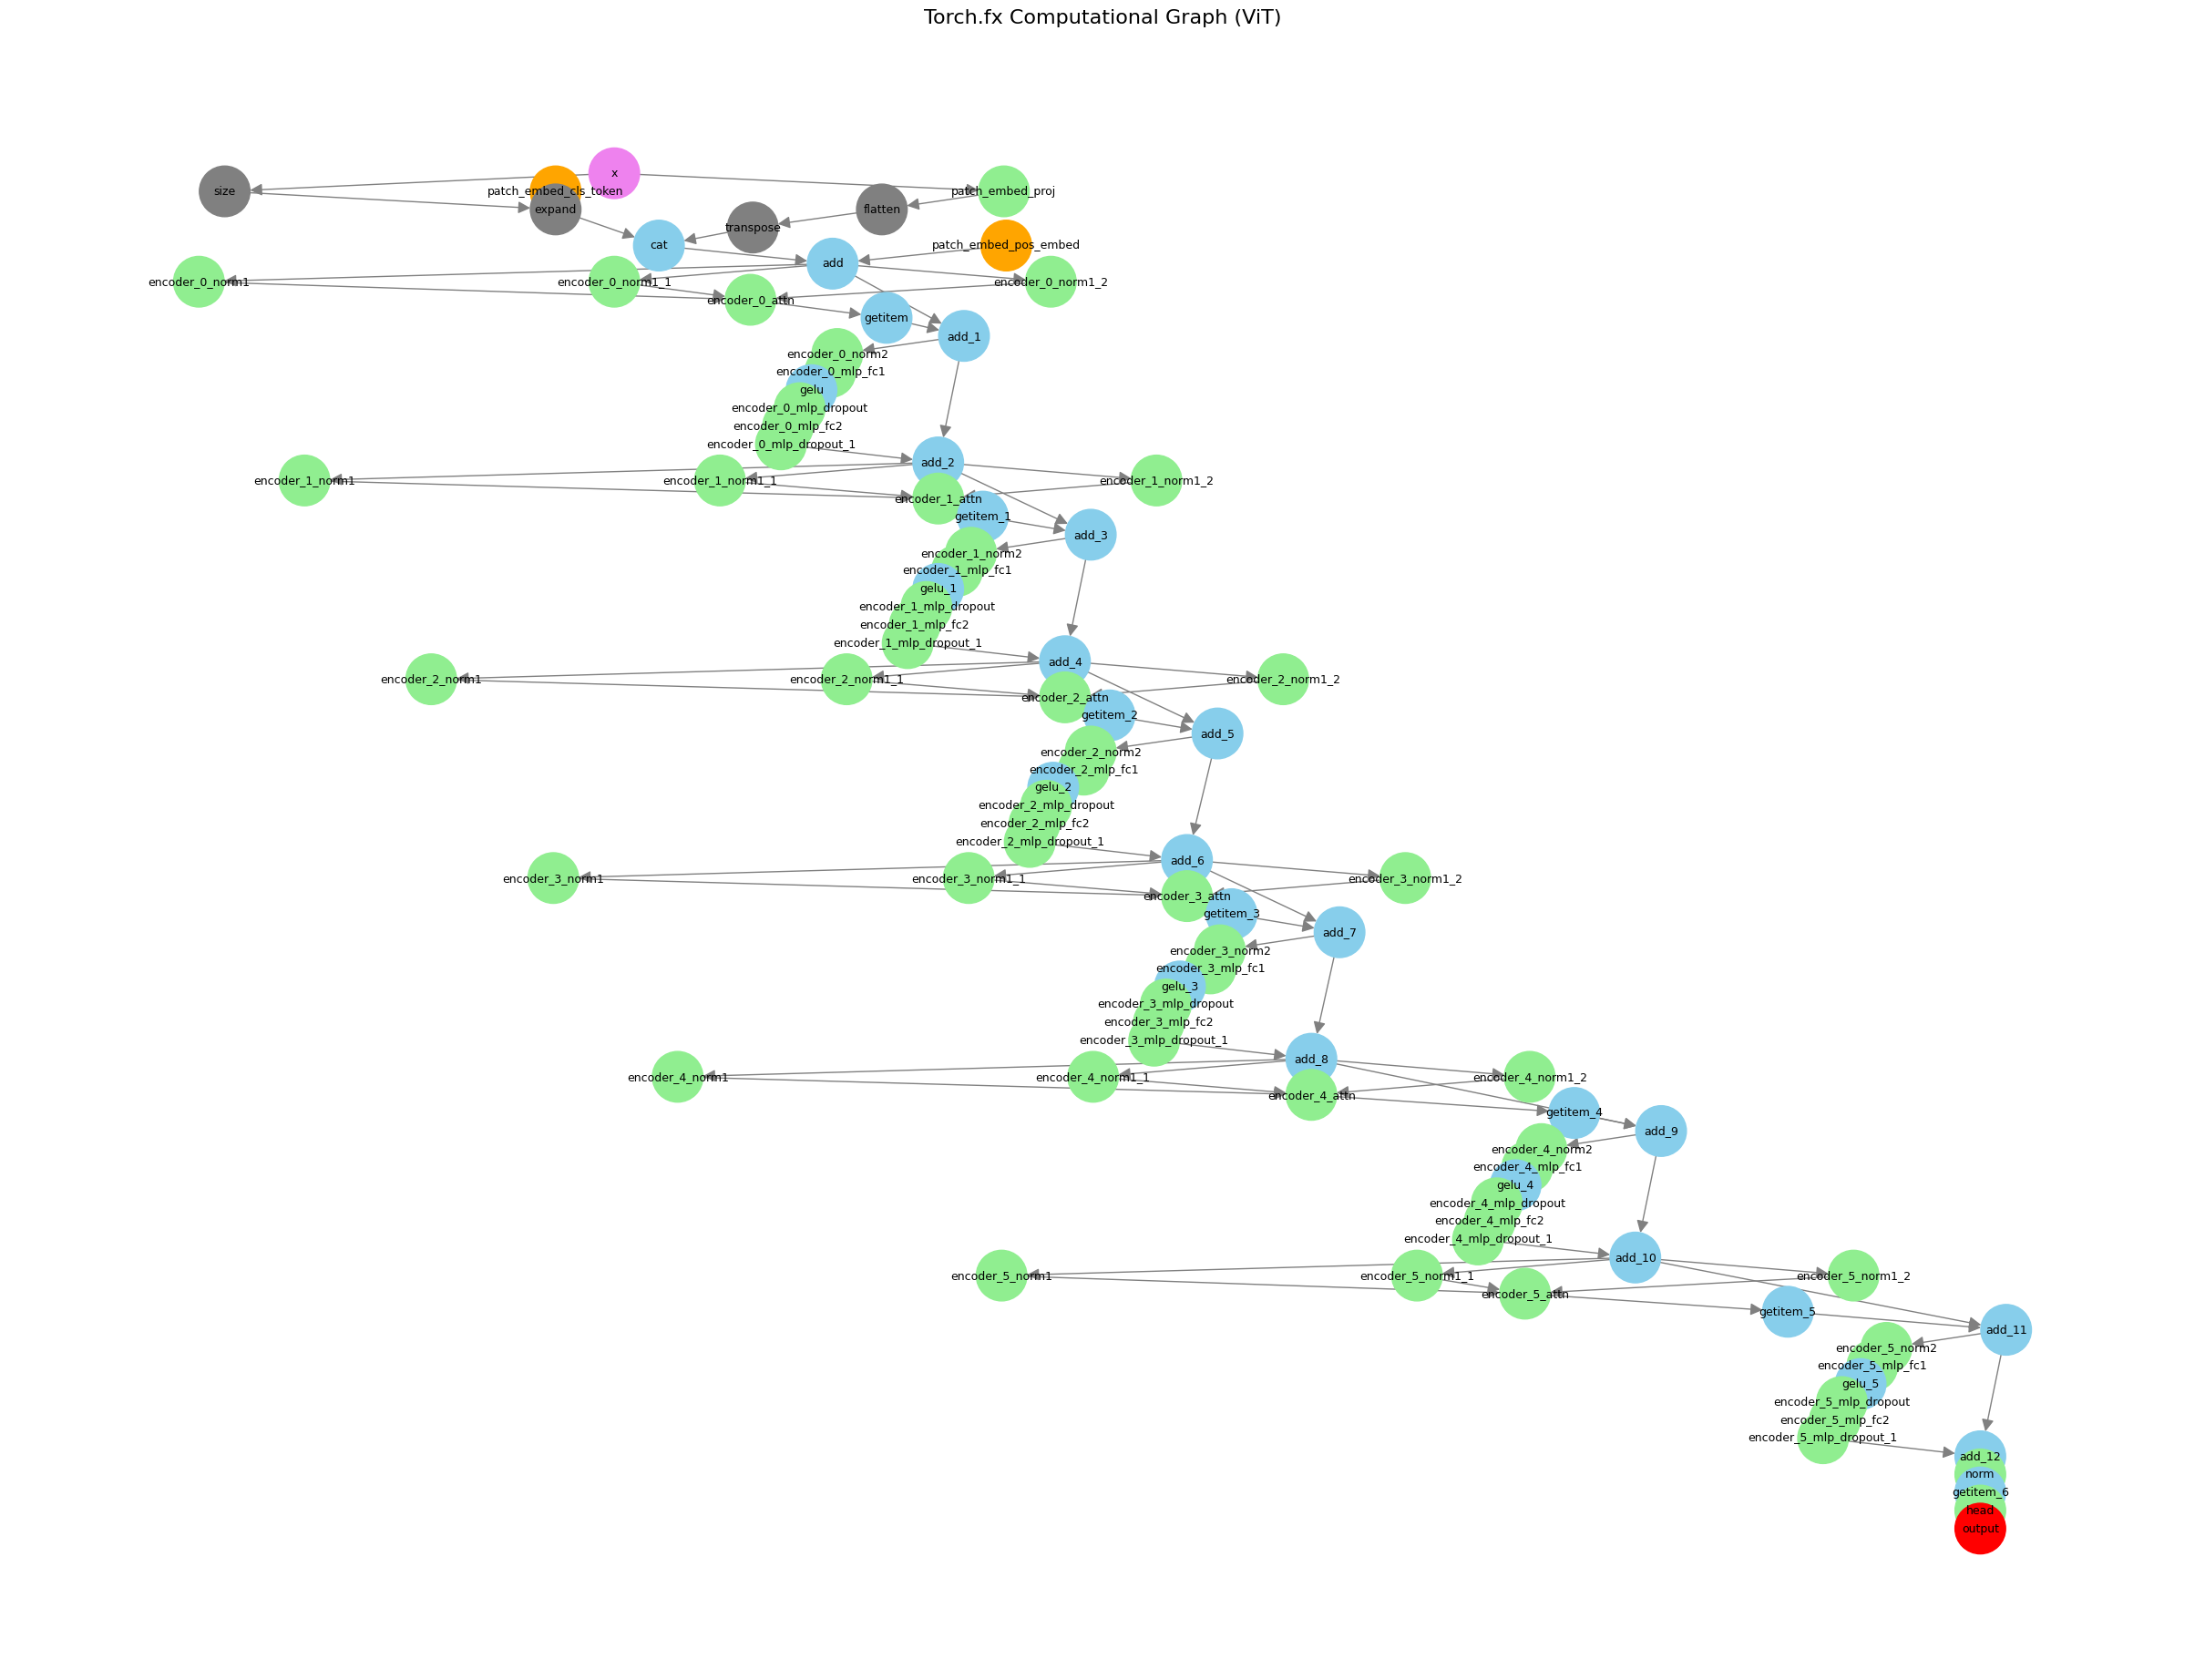

In [ ]:

!pip install pygraphviz
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout  # Usa pygraphviz

# 2. Input dummy
input_tensor = torch.randn(1, 3, 224, 224)

# 3. Traccia il modello con torch.fx
traced = symbolic_trace(model_test)

# 4. Costruisci il grafo NetworkX
g = nx.DiGraph()
for node in traced.graph.nodes:
    g.add_node(node.name, label=node.name, op=node.op)
    for arg in node.all_input_nodes:
        g.add_edge(arg.name, node.name)

# 5. Imposta layout ordinato con Graphviz (dot)
try:
    pos = graphviz_layout(g, prog='dot')
except:
    print("⚠️ pygraphviz non trovato, uso layout di default")
    pos = nx.spring_layout(g)

# 6. Colori per tipo di nodo
color_map = {
    "call_module": "lightgreen",
    "call_function": "skyblue",
    "get_attr": "orange",
    "placeholder": "violet",
    "output": "red"
}
node_colors = [color_map.get(g.nodes[n]['op'], "gray") for n in g.nodes]

# 7. Disegna
plt.figure(figsize=(24, 18))
nx.draw(
    g, pos,
    with_labels=True,
    labels={n: n for n in g.nodes},
    node_color=node_colors,
    node_size=1600,
    font_size=9,
    edge_color='gray',
    arrows=True,
    arrowsize=20
)

# 8. Mostra
plt.title("Torch.fx Computational Graph (ViT)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


#Final settings

In [ ]:

# 2) Imposta qui il path esatto del notebook
#    Puoi copiarlo dal file‐browser di Colab → Copy path
nb_path = Path("/content/drive/MyDrive/File_projects_CV/Mechanistic_Interpretability_for_Vision_Models_Optimization_code.ipynb")


# 3) Rimuovi ogni metadata.widgets
nb = nbformat.read(nb_path, as_version=4)
nb.metadata.pop("widgets", None)
for cell in nb.cells:
    cell.metadata.pop("widgets", None)
nbformat.write(nb, nb_path)
print("✅ metadata.widgets rimosso da", nb_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/File_projects_CV/Mechanistic_Interpretability_for_Vision_Models_Optimization_code.ipynb'